In [4]:
%matplotlib inline
import re
from collections import defaultdict
import numpy as np
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE

from prep import *
import pandas as pd

## Abstract

We will implement various unsupervised methods on Amazon Fine Food Reviews [1]. The dataset consists of reviews of fine foods from Amazon. The overview of the dataset is as at the end of this document.

In this project, we want to cluster the dataset into two clusters: positive review and negative review. To do that we will do dimensionality reduction using Principal Component Analysis, t-sne and Latent Dirichlet Allocation, and compare the results to know which method works better for this case and discuss why it works or not. For the clustering, we will try various clustering methods we have learnt in class. For example: k-means, GMM, or DBScan. Again, we will discuss the result to know which clustering methods work best for this kind of data. For the data pre-processing on the review dataset, we will follow the standard procedure on text, which are stopwords removal and stemming and then convert it into vectors of tf-idf or bag of words.

Furthermore on this analysis, we will not only utilize the reviews from the user, but also we will use a transaction data to see what combinations of products a user usually buy using FP-Growth algorithm.

[1] http://snap.stanford.edu/data/web-FineFoods.html


Data Cleaning:
1. Remove duplicated reviews:  We can see the  the dataset has duplication reviews for one review. Remove empty reviews. Also for one review, two records have different Helpfulness Denominator and Helpfulness Numerator. In that case, we assume the record is cumulated and only kept the record with largest number of Helpfulness Denominator.  
2. Remove the empty reviews:
The purpose of the project is to do semantic analysis for customer reviews. When reviews are not applicable, that review is not helpful. We remove the empty review.


Here, we have cleaned our numerical and categorical datasets and made it as pickle, so that we can just load it

In [104]:
all_reviews_df = pd.read_pickle("./dataframes/All_reviews.pkl")
all_reviews_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [9]:
len(set(all_reviews_df['ProductId']))

74255

In [14]:
with open("product_id.txt", "w") as p:
    for i in set(all_reviews_df['ProductId']):
        p.write(i + "\n")

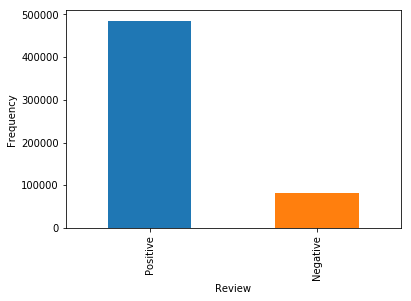

In [4]:
def polarity(x):
    if x < 3:
        # Means negative
        return "Negative"
    else:
        # Means positive
        return "Positive"
    
all_reviews_df["ScoreAsCategory"] = all_reviews_df["Score"].map(polarity)

ax = all_reviews_df["ScoreAsCategory"].value_counts().plot(kind="bar")
ax.set_xlabel("Review")
ax.set_ylabel("Frequency")
plt.show()

In [13]:
from bs4 import BeautifulSoup

with open("index.html", "r") as index:
    soup = BeautifulSoup(index)


for a in soup.findAll('a', {'class': 'a-link-normal a-color-tertiary'}):
    print(a.text.strip())


Sports & Outdoors
Sports & Fitness
Hunting & Fishing
Hunting
Game Calls


Here, we will do text and summary pre-processing, both will be stored to two text files text_prep.txt and summary_prep.txt

In [64]:
rtitle = re.compile(r'^review\/text:\s*(.+)')
stemmer = SnowballStemmer('english')
texts = []
stopwords = []
parsed_titles = []

with open('stopwords_english.txt') as fsw:
    for word in fsw.readlines():
        word = word.strip('\n')
        stopwords.append(word)
fsw.close()

In [8]:


with open('finefoods.txt', encoding='latin-1') as fin:
    for line in fin.readlines():
        line = line.strip('\n')
        mtext = rtitle.match(line)
        ## if it is a title string
        if mtext:
            text = mtext.group(1).lower()
            texts.append(text[:-1])
fin.close()

fout = open('text_prep.txt', 'w+')
for i, words in enumerate(texts):
    words = words.split(" ")
    words = [re.match('[a-zA-Z0-9]+', stemmer.stem(word)).group() for word in words if re.match('[a-zA-Z0-9]+', stemmer.stem(word)) is not None]
    words = ['NUM' if re.match('[0-9]+', word) is not None else word for word in words]
    words = list(filter(None, ["" if word in stopwords else word for word in words]))
    words = ' '.join(words)
    fout.write(words + '\n')
    parsed_titles.append(words)
    if i % 100000 == 0 :
        print(i)
fout.close()

0
100000
200000
300000
400000
500000


In [ ]:


with open('finefoods.txt', encoding='latin-1') as fin:
    for line in fin.readlines():
        line = line.strip('\n')
        mtext = rtitle.match(line)
        ## if it is a title string
        if mtext:
            text = mtext.group(1).lower()
            texts.append(text[:-1])
fin.close()

fout = open('with_stop_non_stemmed.txt', 'w+')
for i, words in enumerate(texts):
    words = words.split(" ")
    # words = [re.match('[a-zA-Z0-9]+', stemmer.stem(word)).group() for word in words if re.match('[a-zA-Z0-9]+', stemmer.stem(word)) is not None]
    words = ['NUM' if re.match('[0-9]+', word) is not None else word for word in words]
    # words = list(filter(None, ["" if word in stopwords else word for word in words]))
    words = ' '.join(words)
    fout.write(words + '\n')
    parsed_titles.append(words)
    if i % 100000 == 0 :
        print(i)
fout.close()

In [52]:
"""
load dataset and convert bag of words represenetations.
"""
with open("./text_prep.txt", "r") as t:
    df = t.read()
    df = df.split("\n")

# Set seed
np.random.seed(999)
    
df = pd.DataFrame(df)
df = df[0]
vec = CountVectorizer()
df_vec = vec.fit_transform(df)
msk = np.random.rand(len(df)) < 0.6

df_train = df_vec[msk]
df_test = df_vec[~msk]

In [53]:
def topwords_pca(cv, pca, num_topwords):
    """
    print the top words based on the eigenvectors 
    """
    Topwords = []
    vocab = {v: k for k, v in cv.vocabulary_.items()}
    eigenvectors = pca.components_
    for k,ev in enumerate(eigenvectors):
        ev_indices = np.argsort(- np.abs(ev))[:num_topwords]
        ev_topwords =', '.join([vocab[ind] for ind in ev_indices])
        Topwords.append(ev_topwords)
        print("Component : %d, topwords : %s" % (k, ev_topwords))

In [54]:
lda = LatentDirichletAllocation(n_components=50, n_jobs=10)
lda.fit(df_train)
# reduced_X = lda.transform(df)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=50, n_jobs=10, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [56]:
print("======================================================")
print("Components: {0}".format(50))
print("======================================================")
topwords_pca(vec, lda, num_topwords=10)
print("------------------------------------------------------")

Components: 50
Component : 0, topwords : litter, box, one, scoop, use, clump, get, gelatin, clean, odor
Component : 1, topwords : tea, green, flavor, drink, bag, like, tast, cup, good, veri
Component : 2, topwords : cat, food, eat, like, one, love, dri, chicken, tri, well
Component : 3, topwords : protein, chees, powder, cracker, tast, milk, good, like, shake, vitamin
Component : 4, topwords : gift, friend, love, famili, bought, christma, year, share, enjoy, back
Component : 5, topwords : veri, product, money, look, wast, return, receiv, disappoint, time, batch
Component : 6, topwords : coffe, coffee, cup, like, flavor, roast, one, tast, good, strong
Component : 7, topwords : fat, sodium, calori, snack, bag, chip, serv, per, gram, eat
Component : 8, topwords : oatmeal, oat, breakfast, raisin, biscuit, food, quaker, like, oats, cut
Component : 9, topwords : like, tast, smell, flavor, tri, realli, good, didn, bad, think
Component : 10, topwords : day, eat, food, three, everi, got, year, 

In [57]:
reduced_X_test = lda.transform(df_test)

In [58]:
reduced_X_train = lda.transform(df_train)

In [66]:
perplexity50 = lda.perplexity(X=df_test)

In [67]:
# LDA n=70
lda70= LatentDirichletAllocation(n_components=70, n_jobs=10)
lda70.fit(df_train)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=70, n_jobs=10, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [68]:
perplexity70 = lda70.perplexity(X=df_test)

In [78]:
lda70.perplexity(X=df_train)

1565.337358177704

In [79]:
lda.perplexity(X=df_train)

1536.30767195421

In [69]:
print(perplexity50, perplexity70)

1886.4847823331584 2048.339353083781


In [75]:
n_tokens = np.sum(df_train.sum(axis=1))
ll = lda.score(X=df_test)

perplexity50_manual = np.exp(-1 * (ll / n_tokens))

In [77]:
print(ll)

-67203080.04357368


In [76]:
print(perplexity50_manual)

155.15322858834867


In [73]:
n_tokens = np.sum(df_train.sum(axis=1))
ll = lda70.score(X=df_test)

perplexity70_manual = np.exp(-1 * (ll / n_tokens))

163.9341846830959

In [59]:
# Comment out if needed
import pickle

with open("reduced_X_test.p", "wb") as f:
    pickle.dump(reduced_X_test, f)

with open("reduced_X_train.p", "wb") as f:
    pickle.dump(reduced_X_train, f)

with open("lda.p", "wb") as f:
    pickle.dump(lda, f)


In [3]:
# Comment out if needed
import pickle

with open("reduced_X_test.p", "rb") as f:
    reduced_X_test = pickle.load(f)

with open("reduced_X_train.p", "rb") as f:
    reduced_X_train = pickle.load(f)

with open("lda.p", "rb") as f:
    lda = pickle.load(f)


--------------------------------------------------------------------------------------------------------

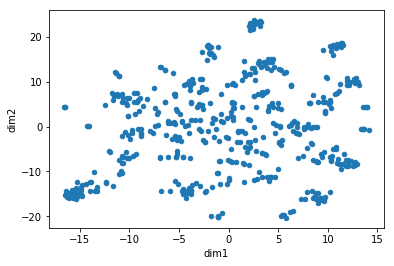

In [60]:
tsne = TSNE(n_jobs=8)
reduced_X_test = pd.DataFrame(reduced_X_test)
# TSNE is taking too long for bigger dataset
reduced_X = reduced_X_test.sample(n=500)
tsne_data = tsne.fit_transform(reduced_X)
tsne_data = pd.DataFrame(tsne_data, columns=["dim1", "dim2"])
tsne_data.plot("dim1", "dim2", kind="scatter")

In [61]:
# Get the best probability of topic
tsne_data['label'] = list(reduced_X.idxmax(axis=1))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

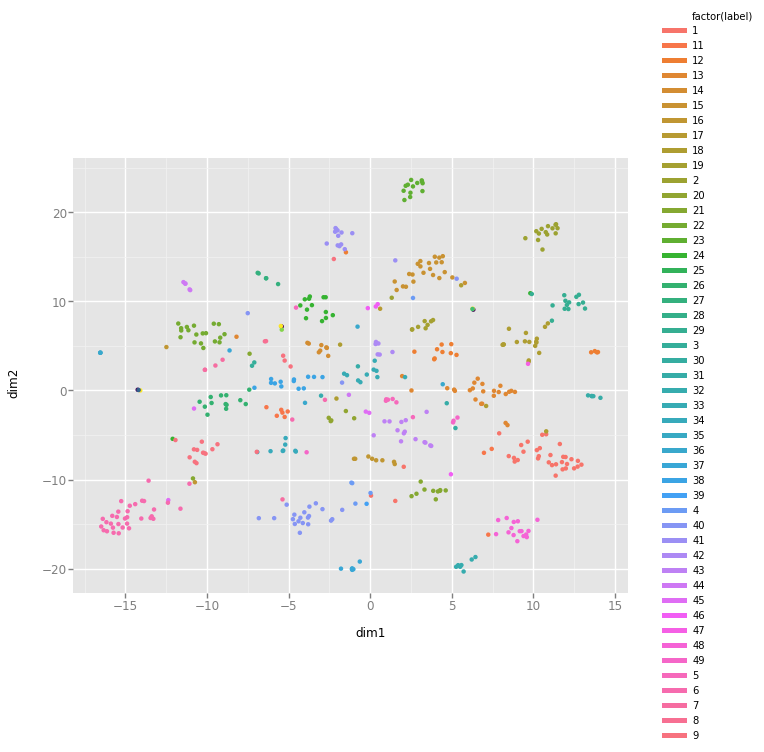

<ggplot: (8745157341206)>

In [62]:
from ggplot import *
ggplot(tsne_data, aes(x='dim1', y='dim2', color='factor(label)')) +\
    geom_point()

In [80]:
lda5 = LatentDirichletAllocation(n_components=5, n_jobs=10, doc_topic_prior=0.01, topic_word_prior=0.01)
lda5.fit(df_train)
lda5.perplexity(X=df_test)

2265.8651850323026

In [81]:
lda10 = LatentDirichletAllocation(n_components=10, n_jobs=10, doc_topic_prior=0.01, topic_word_prior=0.01)
lda10.fit(df_train)
lda10.perplexity(X=df_test)

2152.950988841926

In [82]:
lda30 = LatentDirichletAllocation(n_components=30, n_jobs=10, doc_topic_prior=0.01, topic_word_prior=0.01)
lda30.fit(df_train)
lda30.perplexity(X=df_test)

2133.3553649758946

In [85]:
lda50 = LatentDirichletAllocation(n_components=50, n_jobs=10, doc_topic_prior=0.01, topic_word_prior=0.01)
lda50.fit(df_train)
lda50.perplexity(X=df_test)

2204.8123635578413

In [86]:
lda70 = LatentDirichletAllocation(n_components=70, n_jobs=10, doc_topic_prior=0.01, topic_word_prior=0.01)
lda70.fit(df_train)
lda70.perplexity(X=df_test)

2242.463521906645

In [93]:
# Set seed
np.random.seed(999)
    
vec = CountVectorizer(max_features=10000)
df_vec = vec.fit_transform(df)
msk = np.random.rand(len(df)) < 0.6

df_train = df_vec[msk]
df_test = df_vec[~msk]

In [95]:
perplexity = []
for beta in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    # beta = i / 100
    print("Running for beta: {0}".format(beta))
    lda_temp = LatentDirichletAllocation(n_components=30, n_jobs=10, doc_topic_prior=0.1, topic_word_prior=beta)
    lda_temp.fit(df_train)
    perplexity.append(lda_temp.perplexity(X=df_test))

Running for beta: 0.01
Running for beta: 0.05
Running for beta: 0.1
Running for beta: 0.2
Running for beta: 0.3
Running for beta: 0.4
Running for beta: 0.5
Running for beta: 0.6
Running for beta: 0.7
Running for beta: 0.8
Running for beta: 0.9
Running for beta: 1.0


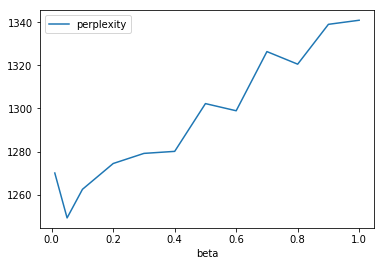

In [102]:
beta_plot = []
for beta, p in zip([0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], perplexity):
    beta_plot.append([beta, p])
    
beta_plot = pd.DataFrame(beta_plot, columns=["beta", "perplexity"])
beta_plot.plot("beta", "perplexity", kind="line")

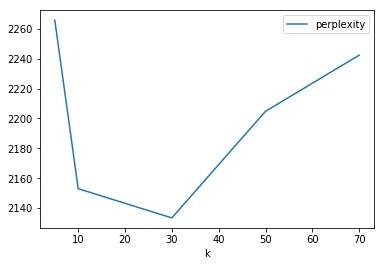

In [103]:
number_of_topics = [[5, 2265.8651850323026], [10, 2152.950988841926], [30, 2133.3553649758946], [50, 2204.8123635578413], [70, 2242.463521906645]]
number_of_topics_plot = pd.DataFrame(number_of_topics, columns=["k", "perplexity"])
number_of_topics_plot.plot("k", "perplexity", kind="line")


In [105]:
print("======================================================")
print("Components: {0}".format(30))
print("======================================================")
topwords_pca(vec, lda_temp, num_topwords=10)
print("------------------------------------------------------")

Components: 30
Component : 0, topwords : honey, corn, raw, syrup, ingredi, salmon, like, yum, flour, high
Component : 1, topwords : flavor, sugar, like, tast, fruit, sweet, drink, juic, soda, appl
Component : 2, topwords : vanilla, candi, hair, gum, bean, use, flavor, like, pumpkin, cinnamon
Component : 3, topwords : ingredi, product, organ, contain, food, list, natur, health, use, vitamin
Component : 4, topwords : use, day, drink, product, help, work, take, energi, sugar, get
Component : 5, topwords : cooki, cookies, like, soft, tast, cookie, good, veri, sweet, thin
Component : 6, topwords : tea, love, year, tri, drink, best, friend, ago, find, grey
Component : 7, topwords : coffe, coffee, cup, flavor, like, roast, tast, one, blend, brew
Component : 8, topwords : tea, green, flavor, bag, like, tast, drink, cup, black, make
Component : 9, topwords : dog, treat, love, get, chew, one, treats, give, like, teeth
Component : 10, topwords : like, tast, tri, eat, realli, becaus, good, one, ba

In [106]:
lda = LatentDirichletAllocation(n_components=30, n_jobs=10, doc_topic_prior=0.1, topic_word_prior=0.05)
lda.fit(df_train)
reduced_X_test = lda.transform(df_test)



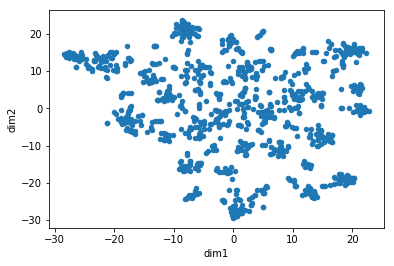

In [128]:
tsne = TSNE(n_jobs=8)
reduced_X_test = pd.DataFrame(reduced_X_test)
reduced_X_train = pd.DataFrame(reduced_X_train)

# TSNE is taking too long for bigger dataset
reduced_X = reduced_X_train.sample(n=1000)
tsne_data = tsne.fit_transform(reduced_X)
tsne_data = pd.DataFrame(tsne_data, columns=["dim1", "dim2"])
tsne_data.plot("dim1", "dim2", kind="scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

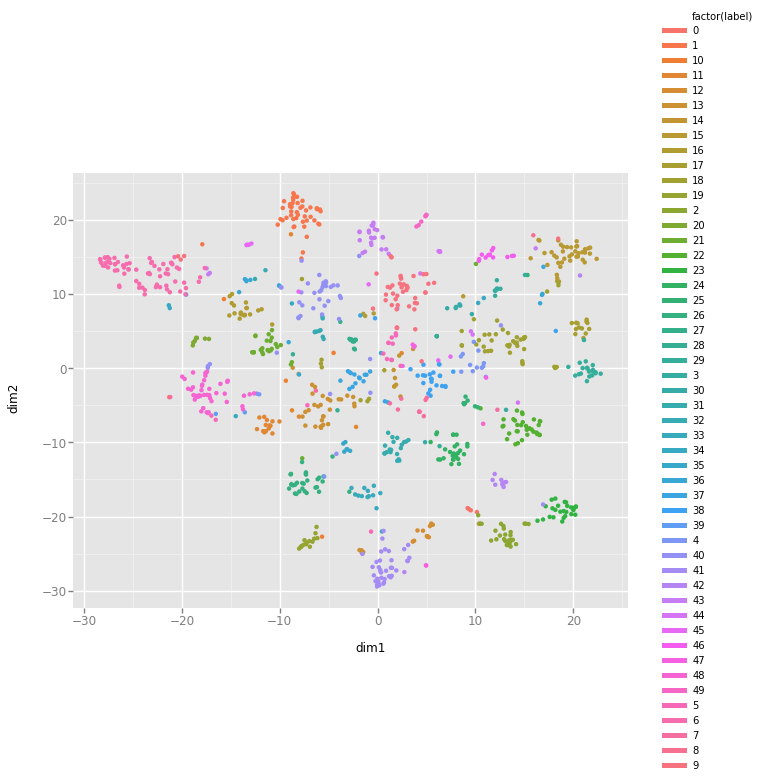

<ggplot: (8745257977962)>

In [129]:
tsne_data['label'] = list(reduced_X.idxmax(axis=1))
from ggplot import *
ggplot(tsne_data, aes(x='dim1', y='dim2', color='factor(label)')) +\
    geom_point()

--------------------------------------GENSIM LDA + TSNE STARTS FROM HERE-----------------------------------------------

In [ ]:
import pandas as pd
import gzip


def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  product_ids = set(all_reviews_df['ProductId'])
  df = {}
  for d in parse(path):
    # print(d)
    cat = []
    if len(df) == len(product_ids):
        break
        
    if d['asin'] in product_ids:
        if "categories" in d:
            cat = d["categories"]
        df[i] = {"asin": d['asin'], "categories": cat}
        print("Found: {0}".format(d['asin']))
        i += 1
        
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/home/prdx/Downloads/metadata.json.gz')

Found: 141278509X
Found: 2734888454
Found: 2841233731
Found: 7800648702
Found: B00002N8SM
Found: B00002NCJC
Found: B00002Z754
Found: B00004RAMV
Found: B00004RAMX
Found: B00004RAMS
Found: B00004RAMY
Found: B00004RBDU
Found: B00004RBDW
Found: B00004RBDZ
Found: B00004S1C5
Found: B00004S1C6
Found: B000052Y74
Found: B00005344V
Found: B0000535LF
Found: B0000537KC
Found: B00005C2M2
Found: B00005C2JE
Found: B00005C2M3
Found: B00005IX98
Found: B00005IX97
Found: B00005IX96
Found: B00005OMWO
Found: B00005OMWQ
Found: B00005U2FA
Found: B0000643LM
Found: B0000691JF
Found: B000069KQW
Found: B00006FMLY
Found: B00006G930
Found: B00006IDK9
Found: B00006IDJU
Found: B00006L2ZT
Found: B00006LL38
Found: B00008433V
Found: B000084346
Found: B00008434E
Found: B00008434F
Found: B00008437P
Found: B000084E7R
Found: B000084DYL
Found: B000084E1U
Found: B000084E66
Found: B000084EBO
Found: B000084EAD
Found: B000084E6Y
Found: B000084EHL
Found: B000084EIQ
Found: B000084388
Found: B000084EIZ
Found: B000084EJP
Found: B00

Found: B0000DD8Y6
Found: B0000DD8YP
Found: B0000DD8RB
Found: B0000DD93T
Found: B0000DDSDX
Found: B0000DDSDQ
Found: B0000DDSC9
Found: B0000DDSCE
Found: B0000DF4BN
Found: B0000DF3M8
Found: B0000DF4CD
Found: B0000DG4EJ
Found: B0000DG4MS
Found: B0000DG4MK
Found: B0000DG4N9
Found: B0000DG553
Found: B0000DG4M5
Found: B0000DG55P
Found: B0000DG4MV
Found: B0000DG4NJ
Found: B0000DG554
Found: B0000DG4MO
Found: B0000DG56A
Found: B0000DG55X
Found: B0000DG55L
Found: B0000DG4E9
Found: B0000DG55M
Found: B0000DG563
Found: B0000DG566
Found: B0000DG560
Found: B0000DG5AE
Found: B0000DG596
Found: B0000DG57P
Found: B0000DG58Q
Found: B0000DG5AX
Found: B0000DG58T
Found: B0000DG5B2
Found: B0000DG5AO
Found: B0000DG57V
Found: B0000DG573
Found: B0000DG5BP
Found: B0000DG5EL
Found: B0000DG5BN
Found: B0000DG5AP
Found: B0000DG4N7
Found: B0000DG4AO
Found: B0000DG57Q
Found: B0000DG5CD
Found: B0000DG5B6
Found: B0000DG5AI
Found: B0000DG55U
Found: B0000DG5AA
Found: B0000DG58W
Found: B0000DG5AN
Found: B0000DG5AQ
Found: B00

Found: B0000TSQ6G
Found: B0000TSC9M
Found: B0000TU6PA
Found: B0000TU74U
Found: B0000TU8EO
Found: B0000TU7EK
Found: B0000TSQ6Q
Found: B0000TU76S
Found: B0000TU9D4
Found: B0000TU9TI
Found: B0000TU8NK
Found: B0000TU7XG
Found: B0000TU85I
Found: B0000TU8VW
Found: B0000TU7XQ
Found: B0000TU8VM
Found: B0000TVV0E
Found: B0000TU9CU
Found: B0000TU80S
Found: B0000TU8D0
Found: B0000TVVD6
Found: B0000TVUE6
Found: B0000TVVB8
Found: B0000TU6P0
Found: B0000TU9TS
Found: B0000TUB8C
Found: B0000TVV4U
Found: B0000TUA06
Found: B0000TU8PI
Found: B0000TVUH8
Found: B0000TVU8W
Found: B0000TVZJG
Found: B0000TVUQE
Found: B0000TU98E
Found: B0000TWLJE
Found: B0000TWLJY
Found: B0000TWLJO
Found: B0000TW1NU
Found: B0000TZ6U0
Found: B0000TZ1G4
Found: B0000TYYFI
Found: B0000TZFSI
Found: B0000TW1O4
Found: B0000TZ1FU
Found: B0000U10XG
Found: B0000U10X6
Found: B0000U0UV4
Found: B0000U11DA
Found: B0000U10VI
Found: B0000U1OL4
Found: B0000U1OGE
Found: B0000U1OFK
Found: B0000U3BBA
Found: B0000U7MKG
Found: B0000U1OLE
Found: B00

Found: B00016UT6I
Found: B00016V1YM
Found: B00016UX14
Found: B00016V1WE
Found: B00016V26Y
Found: B00016V26O
Found: B00016WIUS
Found: B00016UX00
Found: B00016W542
Found: B00016W53I
Found: B00016UX1E
Found: B00016V1X8
Found: B00016V20A
Found: B00016UX0K
Found: B00016VNFY
Found: B00016WU5Q
Found: B00016V2AK
Found: B00016XKQY
Found: B00016XKXM
Found: B00016XKR8
Found: B00016XK8C
Found: B00016XJVU
Found: B00016XLWC
Found: B00016XKJQ
Found: B00016XLHC
Found: B00016XKP0
Found: B00016XLMC
Found: B00016XLMW
Found: B00016XK3M
Found: B00016XLLS
Found: B00016XLN6
Found: B000173IHE
Found: B000173IJM
Found: B00017L1UK
Found: B00017LEX4
Found: B00017LF2O
Found: B00017LEYS
Found: B00017LF06
Found: B00017LEZC
Found: B00017LEXO
Found: B00017LEXY
Found: B00017LEZM
Found: B00017LEXE
Found: B00017LF0Q
Found: B00017LF0G
Found: B00017LEY8
Found: B00017L1TG
Found: B00017LF1K
Found: B00017LEYI
Found: B00017L1UU
Found: B00017LF10
Found: B00017P2MS
Found: B00017P2IM
Found: B00017P2H8
Found: B00017P2GO
Found: B00

Found: B0001LVX4K
Found: B0001M0YBW
Found: B0001M0YS0
Found: B0001M0YU8
Found: B0001M0YYO
Found: B0001M0YLM
Found: B0001M0YOE
Found: B0001M0YI0
Found: B0001M0Z7K
Found: B0001M0ZVQ
Found: B0001M0YNA
Found: B0001M0ZK2
Found: B0001M0ZUW
Found: B0001M0ZV6
Found: B0001M0YSU
Found: B0001M0YNU
Found: B0001M0YK8
Found: B0001M0Z6Q
Found: B0001M10PQ
Found: B0001M0ZSY
Found: B0001M0ZXY
Found: B0001M0ZSO
Found: B0001M0Z5M
Found: B0001M0Z3O
Found: B0001M10QU
Found: B0001M0Z0C
Found: B0001M0ZRA
Found: B0001M0YXA
Found: B0001M0YWQ
Found: B0001M11HI
Found: B0001M10OW
Found: B0001M0ZZ2
Found: B0001M1240
Found: B0001M11BO
Found: B0001M0Z4S
Found: B0001M10TW
Found: B0001M0ZNO
Found: B0001M11NM
Found: B0001M11NC
Found: B0001M0YTE
Found: B0001M11YG
Found: B0001M0Y4O
Found: B0001M10W4
Found: B0001M12KY
Found: B0001M11LE
Found: B0001M12JU
Found: B0001M0ZZC
Found: B0001M0ZGG
Found: B0001M12E0
Found: B0001M11D2
Found: B0001M123G
Found: B0001M12TA
Found: B0001M0ZTI
Found: B0001M0YKI
Found: B0001M12LS
Found: B00

Found: B0002994QA
Found: B0002994Q0
Found: B00029KG4O
Found: B00029LEEK
Found: B00029KOVO
Found: B00029P75C
Found: B00029XN7G
Found: B00029XIZI
Found: B0002A4L1C
Found: B0002AB9GM
Found: B0002AHT84
Found: B0002AHT8E
Found: B0002AQ1LA
Found: B0002AQ1LU
Found: B0002AQ2WI
Found: B0002AQ5PM
Found: B0002AQ6C4
Found: B0002AQ6EC
Found: B0002AQ7SW
Found: B0002AQ4BM
Found: B0002AQ1MO
Found: B0002AQ23W
Found: B0002AQ2VO
Found: B0002AQ6AG
Found: B0002AQ7PU
Found: B0002AQ1JW
Found: B0002AQCHS
Found: B0002AQKCU
Found: B0002AQKDY
Found: B0002AQRMI
Found: B0002AR6V4
Found: B0002AQZDE
Found: B0002ARMVS
Found: B0002ARMS6
Found: B0002ARRCC
Found: B0002ARSR6
Found: B0002ARQYQ
Found: B0002ARX7Q
Found: B0002AS5FA
Found: B0002AS5FK
Found: B0002ASA64
Found: B0002ASAIW
Found: B0002ASCD0
Found: B0002ASCO4
Found: B0002ASBJK
Found: B0002ASCR6
Found: B0002ASBJA
Found: B0002ASB04
Found: B0002ASBZY
Found: B0002ASD98
Found: B0002ASCRQ
Found: B0002ASAIM
Found: B0002ASCQ2
Found: B0002ASCS0
Found: B0002ASD52
Found: B00

Found: B0002RIRJW
Found: B0002RI7JC
Found: B0002RJEO4
Found: B0002RJFCK
Found: B0002RTYGM
Found: B0002RVGFY
Found: B0002RWBZS
Found: B0002SA9AQ
Found: B0002SPRN0
Found: B0002SQ4HS
Found: B0002SQ6SA
Found: B0002SQ1MG
Found: B0002SQ47I
Found: B0002SW0EY
Found: B0002TA77A
Found: B0002TJ77Q
Found: B0002TJC6W
Found: B0002TJDRA
Found: B0002TJB04
Found: B0002TJC6M
Found: B0002TJAZK
Found: B0002TJDRU
Found: B0002TJC7G
Found: B0002TJAWS
Found: B0002TIZLA
Found: B0002TR5U2
Found: B0002TR6D8
Found: B0002TR6G0
Found: B0002TVW24
Found: B0002TW14C
Found: B0002TVYWW
Found: B0002UDY9W
Found: B0002UEEAA
Found: B0002UEMF2
Found: B0002UIKSM
Found: B0002UKNZK
Found: B0002UM1AA
Found: B0002UN690
Found: B0002UMNDU
Found: B0002UW3JO
Found: B0002VAHBY
Found: B0002V9Y5E
Found: B0002V9RNI
Found: B0002VKQ7O
Found: B0002VLEUW
Found: B0002VLEUM
Found: B0002VQ4OI
Found: B0002VXZ4A
Found: B0002VXYQE
Found: B0002VXZ40
Found: B0002VXZ3Q
Found: B0002VXYQY
Found: B0002VS31U
Found: B0002W0S4Y
Found: B0002W0RX6
Found: B00

Found: B00061MUJ2
Found: B00061MW36
Found: B00061MUH4
Found: B00061MUGU
Found: B00061MW6S
Found: B00061MUO2
Found: B00061MV14
Found: B00061MUR4
Found: B00061MV1O
Found: B00061MUNS
Found: B00061MWL8
Found: B00061MURO
Found: B00061MWKO
Found: B00061NT4W
Found: B00061NJ06
Found: B00061NF3W
Found: B00061R4AW
Found: B00061U6AW
Found: B00061U684
Found: B00061U68E
Found: B00061UKJY
Found: B00061UKJO
Found: B00061U67A
Found: B00061UKLM
Found: B00061UKKS
Found: B00061URQA
Found: B00061UQAM
Found: B00061UQGQ
Found: B00061V138
Found: B00061V156
Found: B00061V3H2
Found: B00061YTE6
Found: B00062MSWK
Found: B00062V3MQ
Found: B00062XZEU
Found: B0006307KY
Found: B000633L5M
Found: B000633O2C
Found: B000633LFC
Found: B000633PQM
Found: B000633KRG
Found: B000633JMC
Found: B000633ONG
Found: B000633PT4
Found: B000633RB0
Found: B000633QVG
Found: B000633UQ2
Found: B000633ONQ
Found: B000633UNU
Found: B000633UH6
Found: B000633UO4
Found: B000633UHG
Found: B000633S78
Found: B000633V3E
Found: B000633PQ2
Found: B00

Found: B0006OA5L4
Found: B0006OCZ4E
Found: B0006PKBAS
Found: B0006PKB9Y
Found: B0006PKHWA
Found: B0006PS1SM
Found: B0006PXTE8
Found: B0006PXTI4
Found: B0006PXT52
Found: B0006PXTF2
Found: B0006Q98PG
Found: B0006Q9568
Found: B0006SGA2I
Found: B0006SDRRE
Found: B0006SKCJU
Found: B0006SKG3M
Found: B0006SJLNS
Found: B0006SKCVI
Found: B0006STN04
Found: B0006STN0E
Found: B0006T4I44
Found: B0006TLIJW
Found: B0006TLJFA
Found: B0006TN00C
Found: B0006TLJ8C
Found: B0006TN020
Found: B0006TLIG0
Found: B0006TN016
Found: B0006TN01G
Found: B0006TN06Q
Found: B0006TN03E
Found: B0006TQ3S8
Found: B0006TQ3IS
Found: B0006TQ2TS
Found: B0006TVGO4
Found: B0006TU3FC
Found: B0006TVP8Q
Found: B0006TVYWS
Found: B0006TV6OE
Found: B0006U3NJ4
Found: B0006U3NIU
Found: B0006U6H6K
Found: B0006U7SEA
Found: B0006U7T9E
Found: B0006U910O
Found: B0006U7SZ4
Found: B0006U7SUO
Found: B0006U7SVI
Found: B0006UBMCO
Found: B0006UE212
Found: B0006U7T1C
Found: B0006U7T12
Found: B0006UFY46
Found: B0006UIJE8
Found: B0006UIHHW
Found: B00

Found: B00086I9LI
Found: B00086ICII
Found: B00086ICFG
Found: B00086IBY8
Found: B00086IB8O
Found: B00086IBHK
Found: B00086ICIS
Found: B00086IDVO
Found: B00086IF5I
Found: B00086ICJC
Found: B00086IE18
Found: B00086IDZU
Found: B00086I9JU
Found: B00086IEFE
Found: B00086IE4K
Found: B00086I9L8
Found: B00086IBW0
Found: B00086IE0E
Found: B00086IF2Q
Found: B00086IF1C
Found: B00086I9FY
Found: B00086IDXM
Found: B00086IFLW
Found: B0008D6RAQ
Found: B0008D6R9W
Found: B0008D6RYM
Found: B0008D6R92
Found: B0008D6TDQ
Found: B0008D6TQI
Found: B0008D6UVM
Found: B0008D6VTS
Found: B0008D6XH8
Found: B0008D6WBA
Found: B0008D6UK8
Found: B0008D6YCW
Found: B0008D6TF4
Found: B0008D6US0
Found: B0008D6TEK
Found: B0008D80C4
Found: B0008D806A
Found: B0008DI8KS
Found: B0008DI8QM
Found: B0008DI8OY
Found: B0008DI8NU
Found: B0008DI8QW
Found: B0008DI9FW
Found: B0008D6ZUS
Found: B0008DI8KI
Found: B0008DIBNC
Found: B0008DIB0A
Found: B0008DI8LC
Found: B0008DI8NA
Found: B0008DIBLO
Found: B0008DIEBG
Found: B0008DIDFI
Found: B00

Found: B0009YF8GI
Found: B0009YGCXQ
Found: B0009YG50G
Found: B0009YHS70
Found: B0009YF43U
Found: B0009YJ47W
Found: B0009YL2R2
Found: B0009YJXTG
Found: B0009YJ4CW
Found: B0009YN1US
Found: B0009YL2QS
Found: B0009YLDIA
Found: B0009YSBIU
Found: B0009YSB9E
Found: B0009YUDHC
Found: B0009YUGLA
Found: B0009YUGA6
Found: B0009YUG9M
Found: B0009YUEG2
Found: B0009YUI86
Found: B0009YUCM8
Found: B0009YUHYG
Found: B0009YUGAG
Found: B0009YUI6I
Found: B0009YUCZA
Found: B0009YWMYE
Found: B0009YWHA8
Found: B0009YWKQO
Found: B0009YWL4K
Found: B0009YX9UU
Found: B0009YXA18
Found: B0009YYJVS
Found: B0009YWMVM
Found: B0009YYKQM
Found: B0009YXVJ4
Found: B0009YYQZ2
Found: B0009YYQZW
Found: B0009Z3KNU
Found: B0009Z9QBK
Found: B0009Z63K2
Found: B0009Z9FFW
Found: B0009ZC482
Found: B0009ZGJCY
Found: B000A0BOW8
Found: B000A0COHC
Found: B000A0ICY6
Found: B000A0IGE2
Found: B000A0LFH2
Found: B000A0PNA2
Found: B000A0OG5K
Found: B000A0VOD2
Found: B000A0WLFC
Found: B000A0WMXS
Found: B000A0WMX8
Found: B000A0YHO0
Found: B00

Found: B000BN71P8
Found: B000BN82J2
Found: B000BN82I8
Found: B000BNSXY6
Found: B000BNY5UW
Found: B000BO1KS6
Found: B000BO1FFO
Found: B000BO7CTM
Found: B000BO7HRO
Found: B000BOCAYO
Found: B000BOPTLA
Found: B000BOS3E0
Found: B000BOZW2G
Found: B000BOZ4QA
Found: B000BOZ6K4
Found: B000BP37AY
Found: B000BP3Y84
Found: B000BP5RZW
Found: B000BP7A5M
Found: B000BP8JI4
Found: B000BP8ZG0
Found: B000BPAUKY
Found: B000BPNMVS
Found: B000BPOSC0
Found: B000BPR1AQ
Found: B000BQL1TC
Found: B000BQPEO0
Found: B000BQRDS0
Found: B000BQSI1G
Found: B000BQSXZ2
Found: B000BQUUTO
Found: B000BQVS0E
Found: B000BQWZ2E
Found: B000BR771W
Found: B000BRA2NM
Found: B000BRPPSO
Found: B000BRWMIK
Found: B000BRTAD0
Found: B000BSHNOC
Found: B000BSWIQA
Found: B000BSW6K8
Found: B000BSYZX4
Found: B000BTAR6M
Found: B000BTB6EO
Found: B000BTAT4C
Found: B000BTB66M
Found: B000BTBQTO
Found: B000BTBR2A
Found: B000BTB3XI
Found: B000BTBR16
Found: B000BTAREY
Found: B000BTD0PC
Found: B000BTD0IY
Found: B000BTDL88
Found: B000BTBR20
Found: B00

Found: B000CSEFPQ
Found: B000CSKKG4
Found: B000CSKKE6
Found: B000CSKK5A
Found: B000CSNBT2
Found: B000CSNM6Y
Found: B000CSPQCC
Found: B000CSQ79I
Found: B000CSRBXY
Found: B000CSXHEQ
Found: B000DCOM2W
Found: B000DIN8YY
Found: B000DINB5U
Found: B000DINENE
Found: B000DIN3LC
Found: B000DINEQG
Found: B000DINK6A
Found: B000DLB2DA
Found: B000DLB2E4
Found: B000DLB6KE
Found: B000DLB3AW
Found: B000DN8EZW
Found: B000DN7GJC
Found: B000DT7I2G
Found: B000DT7QE6
Found: B000DZALE2
Found: B000DZAXGS
Found: B000DZA0W0
Found: B000DZAXCW
Found: B000DZB0SS
Found: B000DZB16E
Found: B000DZC03M
Found: B000DZC5LO
Found: B000DZDJM8
Found: B000DZDJ0K
Found: B000DZCKOG
Found: B000DZDIYC
Found: B000DZE0XK
Found: B000DZE710
Found: B000DZEQR0
Found: B000DZFMFU
Found: B000DZFMG4
Found: B000DZE6UM
Found: B000DZFMFA
Found: B000DZFMEQ
Found: B000DZFMIM
Found: B000DZFMF0
Found: B000DZG3PS
Found: B000DZFMFK
Found: B000DZH1A4
Found: B000DZH19U
Found: B000DZH1CW
Found: B000DZH208
Found: B000DZH1D6
Found: B000DZH1CM
Found: B00

Found: B000E8Y5CM
Found: B000E8Y5CC
Found: B000E9Q9XE
Found: B000E9WB8Q
Found: B000E9WC4Y
Found: B000E9WB8G
Found: B000E9WCW6
Found: B000E9WCZI
Found: B000EA0F4C
Found: B000EA0D1W
Found: B000EA0F5Q
Found: B000EA0D26
Found: B000EA0D1C
Found: B000EA0F5G
Found: B000EA0FE2
Found: B000EA2EO6
Found: B000EA3B98
Found: B000EA2EQ4
Found: B000EA2D9C
Found: B000EA3M4M
Found: B000EA2EOG
Found: B000EA3PF8
Found: B000EA2ENM
Found: B000EA3M4W
Found: B000EA2EP0
Found: B000EA3PFI
Found: B000EA3PFS
Found: B000EA2EN2
Found: B000EA3PEO
Found: B000EA3PEY
Found: B000EA3OZE
Found: B000EA3M92
Found: B000EA2D9W
Found: B000EA72FM
Found: B000EA2DA6
Found: B000EAATMU
Found: B000EACDO2
Found: B000EACGBM
Found: B000EADD1Y
Found: B000EBI4IK
Found: B000EBI4IA
Found: B000EBIARK
Found: B000EBKHG2
Found: B000EBKRFI
Found: B000ECUGBC
Found: B000ED6HYQ
Found: B000ED7MIG
Found: B000ED7M1S
Found: B000ED6HVY
Found: B000ED7MFE
Found: B000ED7MDQ
Found: B000ED6SWW
Found: B000ED9L3K
Found: B000ED7MO0
Found: B000EDBQ6A
Found: B00

Found: B000EOCF64
Found: B000EOM6TA
Found: B000EOMUAU
Found: B000EOMUB4
Found: B000EONW02
Found: B000EOOS8W
Found: B000EOOQQ6
Found: B000EOQRUO
Found: B000EONEU0
Found: B000EOXQS0
Found: B000EP1OSI
Found: B000EPB92Y
Found: B000EPMP2M
Found: B000EPMP1S
Found: B000EPMP2C
Found: B000EPMP2W
Found: B000EPMP36
Found: B000EPMP40
Found: B000EPOC00
Found: B000EPOC1Y
Found: B000EPOC32
Found: B000EPP56U
Found: B000EPP57O
Found: B000EPOC2S
Found: B000EPP56K
Found: B000EPOC28
Found: B000EPPBRS
Found: B000EPP588
Found: B000EPOC3W
Found: B000EPR1KI
Found: B000EPPBX2
Found: B000EPQPQE
Found: B000EPOBYC
Found: B000EPR1J4
Found: B000EPS9KE
Found: B000EPR1HQ
Found: B000EPR1IK
Found: B000EPUCSQ
Found: B000EPUHUY
Found: B000EPV5MI
Found: B000EPV028
Found: B000EPUPSS
Found: B000EPY7VO
Found: B000EPYKBG
Found: B000EQ09OC
Found: B000EQ0IXO
Found: B000EQ0M0I
Found: B000EQ2KQ2
Found: B000EQ2LLQ
Found: B000EQ1W0C
Found: B000EQ6AEA
Found: B000EQA60O
Found: B000EQT5JM
Found: B000EQSS4U
Found: B000EQT77M
Found: B00

Found: B000F0DW1E
Found: B000F0AUGO
Found: B000F0FVJU
Found: B000F0EX2Q
Found: B000F0FP0A
Found: B000F0FZC8
Found: B000F0FZDW
Found: B000F0FZF0
Found: B000F0BXB0
Found: B000F0DW3M
Found: B000F0C580
Found: B000F0FZBY
Found: B000F0FZBE
Found: B000F0DW0U
Found: B000F0FZAA
Found: B000F0G72U
Found: B000F0FX52
Found: B000F0FZAK
Found: B000F0FZAU
Found: B000F0FZEG
Found: B000F0FZFA
Found: B000F0FVRC
Found: B000F0FX5C
Found: B000F0FZCI
Found: B000F0FZE6
Found: B000F0FZBO
Found: B000F0G75W
Found: B000F0JL14
Found: B000F0JDZI
Found: B000F0JOSO
Found: B000F0JOVQ
Found: B000F0JOV6
Found: B000F0JNHG
Found: B000F0JORU
Found: B000F0JDXK
Found: B000F0JOVG
Found: B000F0JOR0
Found: B000F0JOW0
Found: B000F0JORA
Found: B000F0JOUM
Found: B000F0JWQI
Found: B000F0JDY4
Found: B000F0JOUW
Found: B000F0JOU2
Found: B000F0JORK
Found: B000F0QPMW
Found: B000F0Z0T6
Found: B000F14DA2
Found: B000F17AKC
Found: B000F18CWW
Found: B000F19XIO
Found: B000F1EUA0
Found: B000F1PR9S
Found: B000F1PR8E
Found: B000F1PD0G
Found: B00

Found: B000FBKGAS
Found: B000FBKFRW
Found: B000FBKFV8
Found: B000FBL8NM
Found: B000FBM494
Found: B000FBM3YK
Found: B000FBM4AI
Found: B000FBM54S
Found: B000FBM480
Found: B000FBMFDO
Found: B000FBOA46
Found: B000FBOA5K
Found: B000FBOAO6
Found: B000FBM4FI
Found: B000FBOA5A
Found: B000FBOAOQ
Found: B000FBOAP0
Found: B000FBQ5HQ
Found: B000FBQ5EY
Found: B000FBQ5GW
Found: B000FBQ67K
Found: B000FBQ5IU
Found: B000FBSQIC
Found: B000FBSR4A
Found: B000FCCJVQ
Found: B000FCCR68
Found: B000FCCQTG
Found: B000FCDASC
Found: B000FCDB7C
Found: B000FCDAS2
Found: B000FCE64E
Found: B000FCE63K
Found: B000FCE676
Found: B000FCF29M
Found: B000FCGCIC
Found: B000FCG8XG
Found: B000FCGK84
Found: B000FCH3Q2
Found: B000FCI6K4
Found: B000FCI6T0
Found: B000FCGY76
Found: B000FCI31G
Found: B000FCG8YK
Found: B000FCH3R6
Found: B000FCI6TA
Found: B000FCIYLU
Found: B000FCOOVY
Found: B000FCNLO0
Found: B000FCRFSS
Found: B000FCRFT2
Found: B000FD2B4U
Found: B000FD787K
Found: B000FD7C6C
Found: B000FD78M0
Found: B000FD7C6M
Found: B00

Found: B000FKIYKI
Found: B000FKIYEO
Found: B000FKIYMG
Found: B000FKIYM6
Found: B000FKK0DC
Found: B000FKKBYU
Found: B000FKK0O6
Found: B000FKL0FO
Found: B000FKL0D6
Found: B000FKL0O0
Found: B000FKLNME
Found: B000FKMNT6
Found: B000FKL0EU
Found: B000FKMNSM
Found: B000FKMNW8
Found: B000FKMNUU
Found: B000FKMNK0
Found: B000FKQDAQ
Found: B000FKQD42
Found: B000FKQDD8
Found: B000FKQDDI
Found: B000FKQD5G
Found: B000FKR1H0
Found: B000FL0A72
Found: B000FL0A9K
Found: B000FL0AG8
Found: B000FL08AQ
Found: B000FL0A6I
Found: B000FL1I3C
Found: B000FL0A9A
Found: B000FL08AG
Found: B000FL1OOA
Found: B000FL22DM
Found: B000FL08B0
Found: B000FL08PG
Found: B000FL3ILM
Found: B000FL3I5I
Found: B000FL3KDI
Found: B000FL3K5Q
Found: B000FL3KUG
Found: B000FL3KCO
Found: B000FL54AA
Found: B000FL521G
Found: B000FL5482
Found: B000FL552C
Found: B000FL54GE
Found: B000FL3K6A
Found: B000FL54ZU
Found: B000FL3Z3S
Found: B000FL52IY
Found: B000FL95Q4
Found: B000FL9E4C
Found: B000FL9EVA
Found: B000FL9EVU
Found: B000FLD2P4
Found: B00

Found: B000G8399A
Found: B000G87NL0
Found: B000GA32XG
Found: B000G9VEBO
Found: B000GAAXKG
Found: B000GAO91K
Found: B000GAO92E
Found: B000GAO38O
Found: B000GAQE4A
Found: B000GAQE3G
Found: B000GARX3G
Found: B000GAPPAY
Found: B000GAS33U
Found: B000GASM5Y
Found: B000GASM6S
Found: B000GAT6OU
Found: B000GAT6MM
Found: B000GAT6NG
Found: B000GAUKN6
Found: B000GAUKRC
Found: B000GAUKPO
Found: B000GAUKP4
Found: B000GAUKPE
Found: B000GAUUS6
Found: B000GAUKNG
Found: B000GAUKS6
Found: B000GATCRQ
Found: B000GAUUTA
Found: B000GAUKOU
Found: B000GAW228
Found: B000GAVPDA
Found: B000GAW23W
Found: B000GAW23M
Found: B000GAW246
Found: B000GAWH4G
Found: B000GAYE38
Found: B000GAW214
Found: B000GAZ0QI
Found: B000GAZPVS
Found: B000GAZPY0
Found: B000GAZPWM
Found: B000GAZPXG
Found: B000GB0TMW
Found: B000GB0UFI
Found: B000GB0TVI
Found: B000GB0UGC
Found: B000GB254M
Found: B000GB26VY
Found: B000GB250G
Found: B000GB4U4A
Found: B000GB3NKC
Found: B000GB7PL0
Found: B000GB7PXS
Found: B000GB7PYC
Found: B000GB7PG0
Found: B00

Found: B000H3CPP8
Found: B000H3BS1A
Found: B000H3DNYU
Found: B000H44STI
Found: B000H454SC
Found: B000H48FX8
Found: B000H4PU3Q
Found: B000H4SME0
Found: B000H4C71Y
Found: B000H4Q2GA
Found: B000H4S67I
Found: B000H4XD08
Found: B000H5KI6Y
Found: B000H5MH68
Found: B000H5MH86
Found: B000H5PJYA
Found: B000H5RI12
Found: B000H69AIU
Found: B000H6AX0E
Found: B000H6E63E
Found: B000H6E62U
Found: B000H6HBNG
Found: B000H6J75G
Found: B000H6J76K
Found: B000H6JPLW
Found: B000H6HUSM
Found: B000H6JO0E
Found: B000H6O3W8
Found: B000H6MNNE
Found: B000H6MNPW
Found: B000H6O3TQ
Found: B000H6PV4M
Found: B000H6PVI8
Found: B000H6TTDQ
Found: B000H740UW
Found: B000H740UM
Found: B000H7D1MA
Found: B000H7D1MK
Found: B000H7D1LG
Found: B000H7EE5I
Found: B000H7EDYU
Found: B000H7CURW
Found: B000H7ELU6
Found: B000H7EE3A
Found: B000H7F5J2
Found: B000H7ELTW
Found: B000H7F5JW
Found: B000H7D1J8
Found: B000H7EE26
Found: B000H7EE62
Found: B000H7F5IS
Found: B000H7F8SU
Found: B000H7D1N4
Found: B000H7FZ4C
Found: B000H7G4CO
Found: B00

Found: B000HQPG4W
Found: B000HQPG9M
Found: B000HQPNKY
Found: B000HQPGEM
Found: B000HQPIYU
Found: B000HQQXMQ
Found: B000HQQU4C
Found: B000HQQUVK
Found: B000HQMLJU
Found: B000HQQWO0
Found: B000HQOVMK
Found: B000HQPA9I
Found: B000HQOS6Y
Found: B000HQP1YC
Found: B000HQRE56
Found: B000HQPNRC
Found: B000HQR3ZM
Found: B000HQKPPW
Found: B000HQR12W
Found: B000HQMS6G
Found: B000HQP610
Found: B000HQR348
Found: B000HQPIN6
Found: B000HQR9J2
Found: B000HQMW9O
Found: B000HQQVH8
Found: B000HQR3KM
Found: B000HQRHTO
Found: B000HQPI8Q
Found: B000HQRJP6
Found: B000HQRJ2O
Found: B000HQQWCM
Found: B000HQPJ4Y
Found: B000HQR0NC
Found: B000HQRHV2
Found: B000HQR096
Found: B000HQR9JW
Found: B000HQRK3C
Found: B000HQRKYQ
Found: B000HQPHGE
Found: B000HQRHVM
Found: B000HQRM08
Found: B000HQR0ZA
Found: B000HQR5CI
Found: B000HQR9UQ
Found: B000HQR1N6
Found: B000HQRCBC
Found: B000HQRKJG
Found: B000HQR1HM
Found: B000HQR0PA
Found: B000HQPKCA
Found: B000HQR0QO
Found: B000HRRVKI
Found: B000HRW838
Found: B000HRVXV6
Found: B00

Found: B000IEC6HS
Found: B000IEC64G
Found: B000IEDUHS
Found: B000IEC6JQ
Found: B000IEC60A
Found: B000IEDUB4
Found: B000IEFVGG
Found: B000IEDU8M
Found: B000IEFVFM
Found: B000IEFVSO
Found: B000IEDUTG
Found: B000IEFVPM
Found: B000IEFW7O
Found: B000IEDU50
Found: B000IEC69G
Found: B000IEFVLG
Found: B000IEHQYQ
Found: B000IEHOM0
Found: B000IEHR6S
Found: B000IEHRJK
Found: B000IEFVX4
Found: B000IEHQTQ
Found: B000IEC6X2
Found: B000IEFVUW
Found: B000IEHQV4
Found: B000IEHRFE
Found: B000IEHRAO
Found: B000IEFTCW
Found: B000IEHRLS
Found: B000IETOAK
Found: B000IEV2C8
Found: B000IEVKNE
Found: B000IEZINW
Found: B000IEWVY6
Found: B000IEZKNU
Found: B000IF5GY2
Found: B000IFW6QS
Found: B000IG450C
Found: B000IGAE6G
Found: B000IGDYGI
Found: B000IHVGMQ
Found: B000IHWWE2
Found: B000IHXKS4
Found: B000IHXML4
Found: B000IHXQ9W
Found: B000IHXJ6W
Found: B000II0GEO
Found: B000II0GIA
Found: B000II0G9Y
Found: B000II27VY
Found: B000II27QE
Found: B000II4LOA
Found: B000II4CN0
Found: B000II4EO2
Found: B000II0GCG
Found: B00

Found: B000JM65W6
Found: B000JM73Z4
Found: B000JM646S
Found: B000JM7IFE
Found: B000JMAXO2
Found: B000JMAVR6
Found: B000JM9GOA
Found: B000JMAVYO
Found: B000JMAVSU
Found: B000JMAVZS
Found: B000JMBE4A
Found: B000JMAVTE
Found: B000JMAVX0
Found: B000JMAW02
Found: B000JMAXNS
Found: B000JMBE3Q
Found: B000JMAXOC
Found: B000JMAXMY
Found: B000JMBG0W
Found: B000JMAVZI
Found: B000JMBE6I
Found: B000JMBE7C
Found: B000JMBEGI
Found: B000JMBG16
Found: B000JMBE5Y
Found: B000JMBE9U
Found: B000JMBEAO
Found: B000JMAXNI
Found: B000JMDH4A
Found: B000JMBEAE
Found: B000JMDH9U
Found: B000JMAVPS
Found: B000JMBEEK
Found: B000JMBEC2
Found: B000JMBE8G
Found: B000JMDH5E
Found: B000JMDH5O
Found: B000JMBE22
Found: B000JMDGZ0
Found: B000JMBECW
Found: B000JMDH40
Found: B000JMDJ34
Found: B000JMBEEU
Found: B000JMDHEA
Found: B000JMDHCC
Found: B000JMBE8Q
Found: B000JMDGZU
Found: B000JMDH72
Found: B000JMDJ5M
Found: B000JMDH9K
Found: B000JMDGY6
Found: B000JMDJ3Y
Found: B000JMDHD6
Found: B000JMFCSE
Found: B000JMDGYG
Found: B00

Found: B000KOUIKI
Found: B000KOUP9C
Found: B000KOUKK6
Found: B000KOUK8I
Found: B000KOUY7A
Found: B000KOUOHU
Found: B000KOUDBW
Found: B000KOUGSC
Found: B000KOUYGQ
Found: B000KOUOGQ
Found: B000KOULWS
Found: B000KOWC3E
Found: B000KOUQL4
Found: B000KOWAPY
Found: B000KOWACM
Found: B000KOUKMY
Found: B000KOUWJ0
Found: B000KOWGYY
Found: B000KOWNGK
Found: B000KOWNHE
Found: B000KOWF0Y
Found: B000KOULVE
Found: B000KOWR8E
Found: B000KOUPGK
Found: B000KOWQNA
Found: B000KOWR8Y
Found: B000KOWR84
Found: B000KOWRKC
Found: B000KOWOSM
Found: B000KOWGHQ
Found: B000KOWHU2
Found: B000KOWLZI
Found: B000KOWQ8A
Found: B000KOWMSE
Found: B000KOWGG2
Found: B000KOWAN6
Found: B000KOWLI0
Found: B000KOWNBU
Found: B000KOWP5Y
Found: B000KOWR6Q
Found: B000KOWNTW
Found: B000KOWEVY
Found: B000KOWPA4
Found: B000KOWXMY
Found: B000KPMKK8
Found: B000KPOLK0
Found: B000KPMI6Y
Found: B000KPMKOO
Found: B000KPQPKE
Found: B000KPQZA4
Found: B000KPMKBC
Found: B000KPQD88
Found: B000KPOMK4
Found: B000KPU474
Found: B000KPXTZS
Found: B00

Found: B000LLK9LS
Found: B000LLKC8S
Found: B000LLM9GQ
Found: B000LL7K0Q
Found: B000LLHNBW
Found: B000LLMAVA
Found: B000LLS44M
Found: B000LLKB8Y
Found: B000LLS410
Found: B000LLMALU
Found: B000LLTJB4
Found: B000LLM9KW
Found: B000LLSIHU
Found: B000LLS3RU
Found: B000LLMATM
Found: B000LLTJ9Q
Found: B000LLTY1O
Found: B000LLM9P2
Found: B000LLM9JI
Found: B000LLXBMC
Found: B000LLMAVU
Found: B000LM1ZO2
Found: B000LLXBK4
Found: B000LM4QPM
Found: B000LM6M6I
Found: B000LM4QNY
Found: B000LNC0BS
Found: B000LNC3YM
Found: B000LNUML8
Found: B000LNWIVU
Found: B000LO25RG
Found: B000LO490C
Found: B000LO40AG
Found: B000LOAN66
Found: B000LP8CHM
Found: B000LPAP3G
Found: B000LPHP7U
Found: B000LPJSCA
Found: B000LPMR0A
Found: B000LPNXQW
Found: B000LPHKB6
Found: B000LPYZZK
Found: B000LQEBBC
Found: B000LQHPNI
Found: B000LQHP92
Found: B000LQHP6A
Found: B000LQHWMM
Found: B000LQHPVK
Found: B000LQHWYK
Found: B000LQHP56
Found: B000LQJ63A
Found: B000LQJ6SU
Found: B000LQHWVS
Found: B000LQJ6KS
Found: B000LQJ6UI
Found: B00

Found: B000LRKR1O
Found: B000LRKQQA
Found: B000LRKPUC
Found: B000LRKRB4
Found: B000LRKLPQ
Found: B000LRKQJW
Found: B000LRKQCO
Found: B000LRKM1O
Found: B000LRO5O4
Found: B000LSHARM
Found: B000LSIUOE
Found: B000LSJEHG
Found: B000LSUOZW
Found: B000LSW56I
Found: B000LSVJFQ
Found: B000LSTC32
Found: B000LSXF4E
Found: B000LSZBKK
Found: B000LT0TOW
Found: B000LT0D4S
Found: B000LSZ2UY
Found: B000LTIDR2
Found: B000LTLJU0
Found: B000LTM29M
Found: B000LTM4J0
Found: B000LTMDLY
Found: B000LTKYP6
Found: B000LTNZ02
Found: B000LTO55Q
Found: B000LTTBW8
Found: B000LTYO0C
Found: B000LU146S
Found: B000LU8WD6
Found: B000LUBZKI
Found: B000LUC48K
Found: B000LUC9DK
Found: B000LULFJ4
Found: B000LUP6LW
Found: B000LURXOU
Found: B000LURXOK
Found: B000LUQAZ8
Found: B000LUXFEC
Found: B000LUVOY0
Found: B000LUXHY0
Found: B000LVM4EI
Found: B000LVM40M
Found: B000LVQK0W
Found: B000LVTWLG
Found: B000LWCR26
Found: B000LWMOCE
Found: B000LXB9TC
Found: B000LXVFDC
Found: B000LY5B40
Found: B000LYCW1A
Found: B000LZJPRS
Found: B00

Found: B000MTO5J6
Found: B000MTQIXM
Found: B000MTRRIM
Found: B000MTRQ7O
Found: B000MTSR8Q
Found: B000MTU2DY
Found: B000MTU2DO
Found: B000MTVUUI
Found: B000MTY00U
Found: B000MU156G
Found: B000MTST70
Found: B000MTY01Y
Found: B000MU5ISC
Found: B000MU7YG6
Found: B000MUJPCC
Found: B000MUK2P6
Found: B000MUCEMU
Found: B000MUK2Q0
Found: B000MUNUWI
Found: B000MUNXL6
Found: B000MUPCEW
Found: B000MUP9M2
Found: B000MURJQG
Found: B000MUT8ZQ
Found: B000MUT91E
Found: B000MUT91Y
Found: B000MUQCFA
Found: B000MUT900
Found: B000MUU22O
Found: B000MUVBZQ
Found: B000MUT928
Found: B000MUVBYW
Found: B000MUVBY2
Found: B000MUVBYC
Found: B000MUX3D4
Found: B000MVGUCO
Found: B000MVIGSK
Found: B000MVTNQE
Found: B000MVTNNM
Found: B000MW1MD0
Found: B000MW6JXI
Found: B000MWEXTK
Found: B000MWF93Y
Found: B000MWFJAM
Found: B000MWTRU0
Found: B000MX469G
Found: B000MXEN8K
Found: B000MXENDK
Found: B000MXEN9Y
Found: B000MXENDA
Found: B000MXENGM
Found: B000MXENE4
Found: B000MXGMCK
Found: B000MXHQS4
Found: B000MXGMI4
Found: B00

Found: B000NNSCBS
Found: B000NNQVES
Found: B000NO00HQ
Found: B000NNYFVY
Found: B000NO4WE8
Found: B000NO5CC4
Found: B000NO4TS2
Found: B000NO72VI
Found: B000NO5CJW
Found: B000NO72RC
Found: B000NO72UE
Found: B000NO72EU
Found: B000NO5CRY
Found: B000NO93PG
Found: B000NO9H7U
Found: B000NO943C
Found: B000NO72TK
Found: B000NOBEQM
Found: B000NO93PQ
Found: B000NOBCPU
Found: B000NOECPW
Found: B000NO72TA
Found: B000NOGDOK
Found: B000NOG0E8
Found: B000NOEE0K
Found: B000NORDQM
Found: B000NOXC0I
Found: B000NOXBWW
Found: B000NOYZV8
Found: B000NOYZRC
Found: B000NP0L6U
Found: B000NP1060
Found: B000NP10GU
Found: B000NP30V8
Found: B000NP30XQ
Found: B000NP30PO
Found: B000NP5UNO
Found: B000NP5A7K
Found: B000NP60EC
Found: B000NPEP7G
Found: B000NPOF7G
Found: B000NPSB7Q
Found: B000NPUBA6
Found: B000NPYY7C
Found: B000NPZUF2
Found: B000NPZUBG
Found: B000NQ1WIK
Found: B000NQ10GY
Found: B000NQ4JQC
Found: B000NQ4JSK
Found: B000NQ6TRY
Found: B000NQ5H3G
Found: B000NQ6TU6
Found: B000NQ6TQK
Found: B000NQ7EQE
Found: B00

Found: B000OMMYNK
Found: B000ONAU6W
Found: B000ONACVK
Found: B000OO5K3O
Found: B000OOT3WS
Found: B000OP16W2
Found: B000OOWXRU
Found: B000OP3HBA
Found: B000OOUYLM
Found: B000OP4BH4
Found: B000OP6AI2
Found: B000OP5G1E
Found: B000OPCH8O
Found: B000OPDD64
Found: B000OPBY5G
Found: B000OQ2JBS
Found: B000OQ2DL4
Found: B000OQ4A3S
Found: B000OQ2DJQ
Found: B000OQ51PE
Found: B000OQ66LM
Found: B000OQ2DJ6
Found: B000OQ66L2
Found: B000OQBL0I
Found: B000OQGXVU
Found: B000OQPNWU
Found: B000OQU81G
Found: B000OQUHYE
Found: B000OQWAS0
Found: B000OQU4DI
Found: B000OQXXV8
Found: B000OQVHHA
Found: B000OQY98E
Found: B000OQZWMQ
Found: B000OQXXOA
Found: B000OQZXUM
Found: B000OR0WFM
Found: B000OQY8LW
Found: B000OQZNTS
Found: B000OQY45M
Found: B000OR17D8
Found: B000OR77I2
Found: B000ORGO5O
Found: B000ORGJFO
Found: B000ORSIJ4
Found: B000ORXRKE
Found: B000ORWG6K
Found: B000ORY230
Found: B000ORYQ9U
Found: B000ORXYYS
Found: B000OS8RKS
Found: B000OSCE2K
Found: B000OSCHN6
Found: B000OSHE2U
Found: B000OSGGTC
Found: B00

Found: B000PWHKAQ
Found: B000PWIR12
Found: B000PWKNUK
Found: B000PWO4A0
Found: B000PWMFCO
Found: B000PWTCBQ
Found: B000PWTXE2
Found: B000PWTQ26
Found: B000PWV4MG
Found: B000PWWQP0
Found: B000PWYIKQ
Found: B000PWYJGO
Found: B000PWYJP0
Found: B000PWYIOW
Found: B000PWYJS2
Found: B000PXU73W
Found: B000PXTLES
Found: B000PXXQNK
Found: B000PXZZQG
Found: B000PXXVCQ
Found: B000PY89AO
Found: B000PY89D6
Found: B000PY89CW
Found: B000PY8XNM
Found: B000PYBBBS
Found: B000PYAGFU
Found: B000PYBKDC
Found: B000PYBUN2
Found: B000PYOMDC
Found: B000Q086VY
Found: B000Q06FH6
Found: B000Q0AZHC
Found: B000Q09UM8
Found: B000Q0IMOK
Found: B000Q0ISDU
Found: B000Q0NMIG
Found: B000Q0T8R0
Found: B000Q0V7RO
Found: B000Q0PEU0
Found: B000Q0WUNO
Found: B000Q0WXE0
Found: B000Q19PEK
Found: B000Q13PZK
Found: B000Q1BM78
Found: B000Q1D7TO
Found: B000Q18IUM
Found: B000Q19HZ2
Found: B000Q1I7AI
Found: B000Q1PQA2
Found: B000Q2EKQC
Found: B000Q2ENAA
Found: B000Q2TJZY
Found: B000Q2RONS
Found: B000Q2UAZC
Found: B000Q3AE2K
Found: B00

Found: B000RJVO0O
Found: B000RJRXI6
Found: B000RJU8VU
Found: B000RJXRW2
Found: B000RJWD7M
Found: B000RJZ7CA
Found: B000RJZ7BQ
Found: B000RJY68G
Found: B000RL53PE
Found: B000RL2W0I
Found: B000RL88YW
Found: B000RLBDNU
Found: B000RLEY7C
Found: B000RLGE16
Found: B000RLNYVE
Found: B000RLOB2K
Found: B000RLP8L8
Found: B000RLTL7U
Found: B000RLUNC2
Found: B000RM2PSG
Found: B000RMOBKQ
Found: B000RMTOVW
Found: B000RNCKQ2
Found: B000RNENU8
Found: B000RNHAF8
Found: B000RNH2NI
Found: B000RNH36O
Found: B000RNPDU2
Found: B000RNW5WQ
Found: B000RNW5X0
Found: B000RO6FNA
Found: B000ROB0OE
Found: B000ROAVLC
Found: B000RODBLE
Found: B000ROKSSS
Found: B000ROR8Z4
Found: B000RP385C
Found: B000RP29IO
Found: B000ROR8QS
Found: B000RP4V76
Found: B000RP37SA
Found: B000RPGKP2
Found: B000RPCZV0
Found: B000RPGKRA
Found: B000RPHEIE
Found: B000RQ10QU
Found: B000RQ2C0I
Found: B000RQ0D1I
Found: B000RQ2P1O
Found: B000RQPV1A
Found: B000RQMQAO
Found: B000RQPV1K
Found: B000RQPXHC
Found: B000RQPUX4
Found: B000RQPV0G
Found: B00

Found: B000ST8IYS
Found: B000ST61FQ
Found: B000ST9FTU
Found: B000ST97D4
Found: B000ST8UG4
Found: B000ST9GCQ
Found: B000STZRTW
Found: B000STWOWA
Found: B000SU1LUU
Found: B000SUAE94
Found: B000SU6S9Y
Found: B000STWOUW
Found: B000SU8LN0
Found: B000SUKHZ0
Found: B000SV6RG2
Found: B000SV572C
Found: B000SVAIJY
Found: B000SV7B76
Found: B000SV8ZLM
Found: B000SV8ZNU
Found: B000SVFAHE
Found: B000SVGHUS
Found: B000SV5DMG
Found: B000SVRVC6
Found: B000SVZOPC
Found: B000SVZQVO
Found: B000SVHBYO
Found: B000SW2MKQ
Found: B000SVZQTQ
Found: B000SW1DOC
Found: B000SW2PJ4
Found: B000SW2MI8
Found: B000SW2OAE
Found: B000SW4KPQ
Found: B000SW4NZI
Found: B000SW1DO2
Found: B000SW4MUO
Found: B000SWVDD8
Found: B000SWTCQI
Found: B000SW4NNK
Found: B000SW4LVY
Found: B000SW2MHE
Found: B000SWVQ08
Found: B000SW1FO0
Found: B000SWTKV0
Found: B000SWVKAE
Found: B000SW4KRY
Found: B000SWTE02
Found: B000SWVPV8
Found: B000SXXJMK
Found: B000SZ7DNE
Found: B000T2B22E
Found: B000T2CXCM
Found: B000T2JDWK
Found: B000T37IY4
Found: B00

Found: B000UYICJW
Found: B000UYFKRY
Found: B000UYIQOI
Found: B000UYIQHK
Found: B000UZHUKS
Found: B000UZLKGI
Found: B000UZMJZO
Found: B000UZLQG2
Found: B000UZPCMG
Found: B000UZP92Y
Found: B000UZS23M
Found: B000UZSVVK
Found: B000UZTTCU
Found: B000UZTTCA
Found: B000UZTTEI
Found: B000UZVPIQ
Found: B000UZVQFI
Found: B000UZVQDK
Found: B000UZVQDA
Found: B000UZWWGU
Found: B000UZXSZE
Found: B000UZVPKO
Found: B000UZWWHO
Found: B000UZVPKE
Found: B000UZXSZY
Found: B000UZZICA
Found: B000UZXTW6
Found: B000UZZICU
Found: B000UZWVNO
Found: B000V0DHBS
Found: B000V0H4A8
Found: B000V0FKUO
Found: B000V0F00O
Found: B000V0HPIE
Found: B000V0QW3S
Found: B000V18TLU
Found: B000V12QFK
Found: B000V17ML8
Found: B000V17MLI
Found: B000V18TRE
Found: B000V1D140
Found: B000V12QFU
Found: B000V17MHC
Found: B000V18TQU
Found: B000V1D19A
Found: B000V1AWCY
Found: B000V1AWBU
Found: B000V17MLS
Found: B000V1ECO8
Found: B000V1AWCE
Found: B000V1FI5U
Found: B000V1AWBK
Found: B000V17MJA
Found: B000V1JVCG
Found: B000V1JU7M
Found: B00

Found: B000VPIYB6
Found: B000VPKYSW
Found: B000VPPURW
Found: B000VPSDXU
Found: B000VPRGCO
Found: B000VPVO9U
Found: B000VPWWIC
Found: B000VQ9I92
Found: B000VQ9IZG
Found: B000VQBF98
Found: B000VQD4Z6
Found: B000VQDABY
Found: B000VQEYZK
Found: B000VQVNKY
Found: B000VR65ME
Found: B000VR87YS
Found: B000VRC8I4
Found: B000VRHJSS
Found: B000VRI1T4
Found: B000VRLS5I
Found: B000VS2BGM
Found: B000VS8KSU
Found: B000VS8O86
Found: B000VS9D7M
Found: B000VSDCH4
Found: B000VSDFRG
Found: B000VSBHPS
Found: B000VSDBEI
Found: B000VSDBNE
Found: B000VSDE5Y
Found: B000VSDNMS
Found: B000VSFNJE
Found: B000VSDA3A
Found: B000VSFMCW
Found: B000VTFIWK
Found: B000VTFITS
Found: B000VTMINM
Found: B000VTMIM8
Found: B000VTR1G6
Found: B000VTRCB0
Found: B000VTQB6W
Found: B000VTRHGK
Found: B000VTRI3C
Found: B000VTTAMY
Found: B000VTV3T2
Found: B000VTRESQ
Found: B000VTRI32
Found: B000VUCG6K
Found: B000VULA5S
Found: B000VUP64O
Found: B000VV0512
Found: B000VV0I5K
Found: B000VVP2JM
Found: B000VVP2LU
Found: B000VVP2II
Found: B00

Found: B000WSK5N2
Found: B000WSX9PI
Found: B000WT6D5K
Found: B000WT8REK
Found: B000WTEJC4
Found: B000WTQ59E
Found: B000WU9TWS
Found: B000WU9WZ2
Found: B000WUBXU4
Found: B000WUHDQ2
Found: B000WUPM06
Found: B000WUQ0RA
Found: B000WUMA4W
Found: B000WUVZCK
Found: B000WV153I
Found: B000WVW5MI
Found: B000WVYB8Y
Found: B000WVZUK2
Found: B000WW22RA
Found: B000WW2M8Y
Found: B000WW6VZO
Found: B000WWBESI
Found: B000WXEMOU
Found: B000WY7SB8
Found: B000WY5T3W
Found: B000WY98P2
Found: B000WY9JS8
Found: B000WY96Q8
Found: B000WYD4P2
Found: B000WYD4PW
Found: B000WYCZX4
Found: B000WYGHOC
Found: B000WYHPZC
Found: B000WYE4CO
Found: B000WYL68Y
Found: B000WYVDRI
Found: B000WZ1VQU
Found: B000WZ4PAY
Found: B000WZPX1E
Found: B000WZZVI4
Found: B000X07M5S
Found: B000X07LOA
Found: B000X0BIEO
Found: B000X0W84I
Found: B000X0Z9CQ
Found: B000X1CC02
Found: B000X1CBLW
Found: B000X1GFN2
Found: B000X1F9XY
Found: B000X1IFPI
Found: B000X1KFQ0
Found: B000X1K91Q
Found: B000X1L3D4
Found: B000X1L3C0
Found: B000X1PY4S
Found: B00

Found: B000YQT87Q
Found: B000YQUY2E
Found: B000YR57FW
Found: B000YSQA7U
Found: B000YSQ9GC
Found: B000YSRJC0
Found: B000YSS7EO
Found: B000YSVLP6
Found: B000YSWADS
Found: B000YSXDDY
Found: B000YSWAE2
Found: B000YSVLVU
Found: B000YSZJGI
Found: B000YSTI7Y
Found: B000YT3626
Found: B000YT3FGS
Found: B000YSTGGW
Found: B000YT3400
Found: B000YT34XW
Found: B000YT3M9S
Found: B000YT3IO2
Found: B000YT3OJG
Found: B000YT32NO
Found: B000YT5ACA
Found: B000YSZJEU
Found: B000YT2YBU
Found: B000YT31VC
Found: B000YT3MHK
Found: B000YT5C78
Found: B000YT3LSU
Found: B000YT5NCM
Found: B000YT54Y4
Found: B000YT3JFU
Found: B000YT3NI8
Found: B000YT5PPM
Found: B000YT79FG
Found: B000YT7R80
Found: B000YT5PRK
Found: B000YT5J3K
Found: B000YT7N8O
Found: B000YT5R96
Found: B000YT5DBS
Found: B000YT7RY4
Found: B000YT986E
Found: B000YT5OU8
Found: B000YT8WT8
Found: B000YT7PUA
Found: B000YT9JKY
Found: B000YT7EF6
Found: B000YT8VHQ
Found: B000YT7THY
Found: B000YT5RDC
Found: B000YT7ROO
Found: B000YT9GG6
Found: B000YT9K58
Found: B00

Found: B00115J0TA
Found: B00115FPV2
Found: B00115KS8M
Found: B00115MW9U
Found: B00115PLDE
Found: B00115QA2A
Found: B00115RPFQ
Found: B00115TWFC
Found: B0011664YS
Found: B00117CSHO
Found: B00117ERSM
Found: B00117GEGU
Found: B00117O2J6
Found: B00117O2E6
Found: B00117O2M8
Found: B00117Q456
Found: B00117TAXO
Found: B00117YKU2
Found: B00117V2NU
Found: B00117YTBC
Found: B00117YUH0
Found: B001185WO4
Found: B001185XTI
Found: B00118ON44
Found: B001189I3A
Found: B00119QGYI
Found: B00119ZKOU
Found: B00119V23S
Found: B0011B715Y
Found: B0011B76HW
Found: B0011BJHZG
Found: B0011BNDJ2
Found: B0011BNE8C
Found: B0011BPEPS
Found: B0011CVPAA
Found: B0011CVFMS
Found: B0011BPDHC
Found: B0011BJHZQ
Found: B0011BPCVO
Found: B0011CX2AG
Found: B0011CX29W
Found: B0011CX2M4
Found: B0011BPNWW
Found: B0011DFY38
Found: B0011DIZIY
Found: B0011DJ45M
Found: B0011DKZ0A
Found: B0011DMNW8
Found: B0011DN9EO
Found: B0011DMMM4
Found: B0011DORYU
Found: B0011DQSFQ
Found: B0011DR7II
Found: B0011DTKTC
Found: B0011DRYXQ
Found: B00

Found: B0012LAFG0
Found: B0012LD5Q2
Found: B0012LCUXQ
Found: B0012L8E7M
Found: B0012LFP6K
Found: B0012LHX2Y
Found: B0012LGHZS
Found: B0012LORF0
Found: B0012LLOCE
Found: B0012LUN3U
Found: B0012LZT7A
Found: B0012M488A
Found: B0012MC4W2
Found: B0012MEWBS
Found: B0012MV2RK
Found: B0012MWVT8
Found: B0012MXSA4
Found: B0012N1YOU
Found: B0012N1ZTE
Found: B0012N9O60
Found: B0012NI060
Found: B0012NJSDO
Found: B0012NI02O
Found: B0012NJSCU
Found: B0012NLIIM
Found: B0012NLIVO
Found: B0012O2NBC
Found: B0012O07JC
Found: B0012O6HLO
Found: B0012O2N1W
Found: B0012OJ4YG
Found: B0012ONFRS
Found: B0012ONFFU
Found: B0012ONHGC
Found: B0012ONFVY
Found: B0012ONHQW
Found: B0012OPDTG
Found: B0012OPDMI
Found: B0012OPD9G
Found: B0012OR1IM
Found: B0012ORELQ
Found: B0012ORCZE
Found: B0012ORCYK
Found: B0012OTGRQ
Found: B0012OTDO2
Found: B0012OTHUW
Found: B0012OTHH0
Found: B0012OUQVQ
Found: B0012OV5VG
Found: B0012OTIXS
Found: B0012OV6BK
Found: B0012OV890
Found: B0012OV62E
Found: B0012PYDI2
Found: B0012PZ7U0
Found: B00

Found: B0014GFJUU
Found: B0014GDSTO
Found: B0014GH4U8
Found: B0014GHE9O
Found: B0014GHE80
Found: B0014GLPFI
Found: B0014GJ244
Found: B0014GLP8A
Found: B0014GLPO4
Found: B0014GHZ3O
Found: B0014GN1NM
Found: B0014GP4QY
Found: B0014GLP1W
Found: B0014GP4X2
Found: B0014GP4F0
Found: B0014GP4H8
Found: B0014GP8DI
Found: B0014GP4WS
Found: B0014GN290
Found: B0014GQX8C
Found: B0014GSM7W
Found: B0014GRP7A
Found: B0014GSMAY
Found: B0014GTDCK
Found: B0014GP4L4
Found: B0014GUBLM
Found: B0014GQWNI
Found: B0014GP4NW
Found: B0014GUBE4
Found: B0014GVXDM
Found: B0014GV19I
Found: B0014GVZA8
Found: B0014GUBY4
Found: B0014GX89Y
Found: B0014GZD56
Found: B0014GZDY2
Found: B0014GZERS
Found: B0014H17HI
Found: B0014H18J0
Found: B0014H2SEE
Found: B0014H18L8
Found: B0014H637M
Found: B0014GZDH4
Found: B0014HG2O6
Found: B0014J5Y3E
Found: B0014J9I2W
Found: B0014J7J9Q
Found: B0014JDK26
Found: B0014JI8K0
Found: B0014JN83W
Found: B0014JUULU
Found: B0014JW2NY
Found: B0014K91GY
Found: B0014L1PPS
Found: B0014KZM7G
Found: B00

Found: B00166K930
Found: B00167YCSM
Found: B001680NWK
Found: B001682P6C
Found: B001682PD0
Found: B001682QUM
Found: B001682UGW
Found: B001682T2W
Found: B001682T2M
Found: B001682QCK
Found: B001682UJO
Found: B001682OG8
Found: B001682OOA
Found: B001682V66
Found: B001682UQC
Found: B001682QB6
Found: B001682U44
Found: B001682P0S
Found: B001682QV6
Found: B0016814QO
Found: B001682TCM
Found: B001682U6M
Found: B001682QMA
Found: B001684NTE
Found: B001684NX0
Found: B001684OTS
Found: B001684NNU
Found: B001684RE0
Found: B001684T5M
Found: B001684P88
Found: B001684PGK
Found: B001684O7A
Found: B001684NBM
Found: B001684N30
Found: B001684RJK
Found: B001684OHK
Found: B001684SKS
Found: B001684RSQ
Found: B001684S7Q
Found: B001684N0I
Found: B001684QO6
Found: B0016861BM
Found: B0016864WI
Found: B0016861T4
Found: B0016865KO
Found: B00168637Y
Found: B0016861YE
Found: B00168654K
Found: B0016864SM
Found: B0016863JM
Found: B0016866DK
Found: B0016862HU
Found: B0016862HA
Found: B0016861P8
Found: B0016866C6
Found: B00

Found: B0017JFYW2
Found: B0017JFYE0
Found: B0017JHLA0
Found: B0017JG1BK
Found: B0017JHO7A
Found: B0017JHTWK
Found: B0017JHCNQ
Found: B0017JHIH6
Found: B0017JGAB6
Found: B0017JFZ2Q
Found: B0017JHPB0
Found: B0017JSDFC
Found: B0017JVH5A
Found: B0017K3Z2M
Found: B0017K61OQ
Found: B0017K5HGY
Found: B0017KTOO0
Found: B0017KWNZC
Found: B0017KYJD6
Found: B0017KYJ68
Found: B0017KY7JC
Found: B0017KYJK4
Found: B0017KY1F2
Found: B0017L3NBE
Found: B0017L3MRE
Found: B0017L3YNQ
Found: B0017L4KIE
Found: B0017L46F6
Found: B0017L3NDC
Found: B0017L4PH0
Found: B0017L8MGU
Found: B0017L9GX8
Found: B0017L82IS
Found: B0017LEMWI
Found: B0017LELE2
Found: B0017LG0QE
Found: B0017M5V9A
Found: B0017MRLW0
Found: B0017N75AW
Found: B0017NA68K
Found: B0017N9AL4
Found: B0017NNMU4
Found: B0017NO9CO
Found: B0017NQLNE
Found: B0017NO2LC
Found: B0017O5RYM
Found: B0017O8FFA
Found: B0017O8F1O
Found: B0017O74DE
Found: B0017O9GCG
Found: B0017OAISW
Found: B0017OAKNK
Found: B0017OASQO
Found: B0017OAQIY
Found: B0017OATPE
Found: B00

Found: B0018DG2S2
Found: B0018DM3XU
Found: B0018DODPG
Found: B0018E7GM2
Found: B0018G2J7M
Found: B0018G9QQO
Found: B0018GD1NI
Found: B0018GDSH2
Found: B0018HKOJQ
Found: B0018IUILY
Found: B0018JHJ7O
Found: B0018JMP00
Found: B0018KJHY6
Found: B0018LB76Q
Found: B0018LC8XM
Found: B0018LHYCM
Found: B0018MIF9M
Found: B0018MJ2EE
Found: B0018MMCWS
Found: B0018ML2NS
Found: B0018MS4PW
Found: B0018MVMVU
Found: B0018MTXHK
Found: B0018MTXIE
Found: B0018MX5I8
Found: B0018MWINQ
Found: B0018MZ2W0
Found: B0018MZ7Q6
Found: B0018N0KVM
Found: B0018N38P2
Found: B0018N7YUM
Found: B0018NLL2Y
Found: B0018OKA1Q
Found: B0018OK69W
Found: B0018OJK12
Found: B0018OL2ZE
Found: B0018ONML6
Found: B0018OQD1M
Found: B0018OQ6V4
Found: B0018OTDG4
Found: B0018OZRA0
Found: B0018PAYOI
Found: B0018PFXSA
Found: B0018Q1O3W
Found: B0018Q2N3C
Found: B0018Q1G94
Found: B0018Q1IP6
Found: B0018Q50W8
Found: B0018Q6KNQ
Found: B0018QBEQE
Found: B0018QC8EG
Found: B0018QCIMI
Found: B0018QCJ5Y
Found: B0018QBX6K
Found: B0018QC828
Found: B00

Found: B001A9X45S
Found: B001AAO1SG
Found: B001AAPVDK
Found: B001ABMDA8
Found: B001ABOBEO
Found: B001ABOBBC
Found: B001ABOC4S
Found: B001ABOBRQ
Found: B001ABOCBG
Found: B001ABOC7U
Found: B001ABOCC0
Found: B001ABOBL2
Found: B001ABQ6AG
Found: B001ABTGLC
Found: B001ABTH84
Found: B001ABQ692
Found: B001ABQ6CY
Found: B001ABTGF8
Found: B001ABUY7M
Found: B001ABTINS
Found: B001ABTGQW
Found: B001ABUYB8
Found: B001ABZ1HA
Found: B001ABTH48
Found: B001ABUYIQ
Found: B001ABUY5Y
Found: B001AC0U6G
Found: B001ABOBIA
Found: B001AC4ROC
Found: B001AC67DQ
Found: B001AC67AE
Found: B001AC67CM
Found: B001AC87WA
Found: B001AC4ROW
Found: B001ABTIME
Found: B001AC87WK
Found: B001AC57NM
Found: B001AC8JL4
Found: B001AC87X4
Found: B001AC4RP6
Found: B001ACDOA0
Found: B001ACIAE0
Found: B001ACMCNU
Found: B001ACMCNA
Found: B001ACMCLM
Found: B001ACMBZO
Found: B001ACNWY8
Found: B001ACMDZM
Found: B001ACNWUC
Found: B001ACNXVU
Found: B001ACPIUE
Found: B001ACPPXE
Found: B001ACPNYU
Found: B001ACTYT0
Found: B001ACTYTU
Found: B00

Found: B001BLGKEM
Found: B001BLI9FK
Found: B001BLABJW
Found: B001BLH92E
Found: B001BLMKYQ
Found: B001BLQ312
Found: B001BLXQ9E
Found: B001BLXTRI
Found: B001BLX9C8
Found: B001BLX7DE
Found: B001BM2WWK
Found: B001BM2UUO
Found: B001BLXSVK
Found: B001BLZVQ0
Found: B001BLZZ8O
Found: B001BM2V3U
Found: B001BM3N5U
Found: B001BM3LMA
Found: B001BM3ON6
Found: B001BM399U
Found: B001BM3G2U
Found: B001BM3NJQ
Found: B001BM3CE2
Found: B001BM3LWA
Found: B001BM3H8I
Found: B001BM368E
Found: B001BM4MFK
Found: B001BM3PIK
Found: B001BM395E
Found: B001BM4TR6
Found: B001BM4ROQ
Found: B001BM4ZMA
Found: B001BM4JR6
Found: B001BM36WK
Found: B001BM3I96
Found: B001BM3MS8
Found: B001BM4SPY
Found: B001BM4N72
Found: B001BM4YRQ
Found: B001BM5146
Found: B001BM3L8Y
Found: B001BM3KXU
Found: B001BM3HD8
Found: B001BM66AO
Found: B001BM62T4
Found: B001BM6SKC
Found: B001BM6PKK
Found: B001BM3POY
Found: B001BM6I8O
Found: B001BM6QHC
Found: B001BM6IDY
Found: B001BM68S4
Found: B001BM6SDE
Found: B001BM6Q0Y
Found: B001BM6LVS
Found: B00

Found: B001D0MF2W
Found: B001D12NPU
Found: B001D1A3Q6
Found: B001D1FPSW
Found: B001D1UW44
Found: B001D1UW58
Found: B001D1UW6M
Found: B001D1YL9G
Found: B001D1YL82
Found: B001D1YLAA
Found: B001D20BHG
Found: B001D1YLCI
Found: B001D20BI0
Found: B001D20BGW
Found: B001D20BJE
Found: B001D20WAW
Found: B001D1YL8W
Found: B001D21LRA
Found: B001D331XG
Found: B001D3K2AG
Found: B001D3K30U
Found: B001D3K34Q
Found: B001D331I6
Found: B001D3K2CE
Found: B001D3K2TM
Found: B001D3K90O
Found: B001D3LUMU
Found: B001D3K2GA
Found: B001D3NXNO
Found: B001D3K2HE
Found: B001D3NXT8
Found: B001D3LV5Q
Found: B001D3NXTI
Found: B001D3NXHA
Found: B001D3Q4DA
Found: B001D3PY1S
Found: B001D3PY0E
Found: B001D3QN4K
Found: B001D3LUKW
Found: B001D3NXVQ
Found: B001D3LUR0
Found: B001D3PY9K
Found: B001D3Q4GC
Found: B001D4CJJ2
Found: B001D4F8HW
Found: B001D4CJJW
Found: B001D48FXQ
Found: B001D4ORO2
Found: B001D4Q5AG
Found: B001D4SRCU
Found: B001D4WVPO
Found: B001D4VK10
Found: B001D4YXRS
Found: B001D6325K
Found: B001D60Z96
Found: B00

Found: B001E6EE88
Found: B001E6EDHA
Found: B001E6EJQU
Found: B001E6EEE2
Found: B001E6EE92
Found: B001E6EK3W
Found: B001E6EJSS
Found: B001E6EJTW
Found: B001E6EJZ6
Found: B001E6GG1Q
Found: B001E6GFPI
Found: B001E6GL66
Found: B001E6GFXU
Found: B001E6GFSU
Found: B001E6GFZI
Found: B001E6GLPW
Found: B001E6IUG0
Found: B001E6IULK
Found: B001E6IZVU
Found: B001E6J0BO
Found: B001E6GFKI
Found: B001E6IUJM
Found: B001E6K6F8
Found: B001E6K63A
Found: B001E6IZU6
Found: B001E6K6DA
Found: B001E6J07I
Found: B001E6KBYE
Found: B001E6K67Q
Found: B001E6KBJ4
Found: B001E6KBSK
Found: B001E6IUMY
Found: B001E6KC0C
Found: B001E6K6G2
Found: B001E6KP5E
Found: B001E6KBSU
Found: B001E6KBWQ
Found: B001E6MIQ8
Found: B001E6K6GW
Found: B001E6KP4K
Found: B001E6K6B2
Found: B001E6PKOA
Found: B001E6PKJU
Found: B001E6R6DS
Found: B001E7650W
Found: B001E7654S
Found: B001E76570
Found: B001E77LT6
Found: B001E77LUK
Found: B001E8F016
Found: B001E8FLF6
Found: B001E8HSAM
Found: B001E8ICZ2
Found: B001E8J2RY
Found: B001E8M8U2
Found: B00

Found: B001EO76YE
Found: B001EO7ELY
Found: B001EO7EDC
Found: B001EO7E3W
Found: B001EO775W
Found: B001EO7EBE
Found: B001EO7EG4
Found: B001EO7716
Found: B001EO7DQU
Found: B001EO7DTC
Found: B001EO7F2M
Found: B001EO76WG
Found: B001EO7EAU
Found: B001EO7DFG
Found: B001EO7FHW
Found: B001EO7FJ0
Found: B001EO7F8G
Found: B001EO7FCM
Found: B001EO7DK6
Found: B001EO7FD6
Found: B001EO7EXC
Found: B001EO7ES2
Found: B001EO7E9G
Found: B001EO7EU0
Found: B001EO7FXQ
Found: B001EO7E2I
Found: B001EO7F4K
Found: B001EO7F9U
Found: B001EO7E5U
Found: B001EO7G9O
Found: B001EO7EJ6
Found: B001EO7FVS
Found: B001EO7DI8
Found: B001EO7FMC
Found: B001EO778O
Found: B001EO7G4Y
Found: B001EO7G94
Found: B001EO7FZO
Found: B001EO7GNK
Found: B001EO7GL2
Found: B001EO7FC2
Found: B001EO7FPE
Found: B001EO7F54
Found: B001EO7GQC
Found: B001EO7FTU
Found: B001EO6GU4
Found: B001EO7GCG
Found: B001EO7FV8
Found: B001EO7H20
Found: B001EO7GXA
Found: B001EO7G30
Found: B001EO7FJU
Found: B001EO7EL4
Found: B001EO7GKI
Found: B001EO7FWM
Found: B00

Found: B001EQ5O4G
Found: B001EQ5P7C
Found: B001EQ5LT4
Found: B001EQ5NHE
Found: B001EQ5PLS
Found: B001EQ5MUC
Found: B001EQ5Q3U
Found: B001EQ5MJ8
Found: B001EQ5QOE
Found: B001EQ5Q58
Found: B001EQ5QWQ
Found: B001EQ5K1I
Found: B001EQ5QPS
Found: B001EQ5MCA
Found: B001EQ5MVG
Found: B001EQ5P6I
Found: B001EQ5OVY
Found: B001EQ5L94
Found: B001EQ5QK8
Found: B001EQ5LGC
Found: B001EQ5NL0
Found: B001EQ5N10
Found: B001EQ5PWW
Found: B001EQ5OV4
Found: B001EQ5QW6
Found: B001EQ5RA2
Found: B001EQ5Q76
Found: B001EQ5PTA
Found: B001EQ5QYY
Found: B001EQ5QY4
Found: B001EQ5PJA
Found: B001EQ5RCA
Found: B001EQ5S6U
Found: B001EQ5RI4
Found: B001EQ5RDO
Found: B001EQ5NJM
Found: B001EQ5SGU
Found: B001EQ5MGQ
Found: B001EQ5S9C
Found: B001EQ5RO8
Found: B001EQ5RHA
Found: B001EQ5P40
Found: B001EQ5PRW
Found: B001EQ5MS4
Found: B001EQ5RJS
Found: B001EQ5NLU
Found: B001EQ5S4W
Found: B001EQ5SEC
Found: B001EQ5PKE
Found: B001EQ5QZI
Found: B001EQ5QNA
Found: B001EQ5NEW
Found: B001EQ5SFG
Found: B001EQ5PSQ
Found: B001EQ5JV4
Found: B00

Found: B001FB5LHU
Found: B001FB68HC
Found: B001FB68UE
Found: B001FB68Z4
Found: B001FB68YU
Found: B001FB68W2
Found: B001FB68XG
Found: B001FB69TY
Found: B001FB68JA
Found: B001FB68WW
Found: B001FB69VC
Found: B001FB68XQ
Found: B001FB6ASY
Found: B001FB69Z8
Found: B001FB69YY
Found: B001FB6AJ8
Found: B001FB6AI4
Found: B001FB6ATI
Found: B001FB68PY
Found: B001FB68UY
Found: B001FB6BB0
Found: B001FB6ACA
Found: B001FB6B8I
Found: B001FB6AOI
Found: B001FB6BE2
Found: B001FB6B5Q
Found: B001FB6BVU
Found: B001FB69S0
Found: B001FB69XU
Found: B001FB6B1A
Found: B001FB69Q2
Found: B001FB6BDI
Found: B001FB6BU6
Found: B001FB69VW
Found: B001FB6AIY
Found: B001FB69SK
Found: B001FB6B0G
Found: B001FB6C2S
Found: B001FB6BA6
Found: B001FB6A2A
Found: B001FB6A34
Found: B001FB6A0C
Found: B001FB69M6
Found: B001FB69ZS
Found: B001FB68KO
Found: B001FB69XA
Found: B001FB6AL6
Found: B001FB69US
Found: B001FB6BG0
Found: B001FB6BV0
Found: B001FB69SU
Found: B001FB6AHK
Found: B001FB6AT8
Found: B001FB6C4Q
Found: B001FBKO4U
Found: B00

Found: B001H31ZWG
Found: B001H32336
Found: B001H3230E
Found: B001H32FTI
Found: B001H32FMK
Found: B001H32G24
Found: B001H32FUC
Found: B001H32FP2
Found: B001H32FVG
Found: B001H35MDO
Found: B001H32G38
Found: B001H3790I
Found: B001H3O6P4
Found: B001H3O7SU
Found: B001H3O6UO
Found: B001H3NHZE
Found: B001H3NI0S
Found: B001H3PYU0
Found: B001H3PVUI
Found: B001H3RV92
Found: B001H3RTCQ
Found: B001H3VNWI
Found: B001H3TVCC
Found: B001H3T5G4
Found: B001H3RVZ6
Found: B001H3VQFM
Found: B001H3TS5C
Found: B001H3TV90
Found: B001H3P9ZU
Found: B001H3R6YC
Found: B001H3V2LK
Found: B001H7TG5K
Found: B001H802WA
Found: B001H827W8
Found: B001H803P6
Found: B001H828EK
Found: B001H8U37O
Found: B001H8HP48
Found: B001H8R00M
Found: B001H8W9IU
Found: B001H955WQ
Found: B001H911SI
Found: B001H9N3B6
Found: B001H9N1B8
Found: B001H9N9WO
Found: B001H9NBA4
Found: B001H9N9RE
Found: B001H9N9VU
Found: B001H9N9VA
Found: B001HA6W36
Found: B001HB1IH0
Found: B001HBBQKY
Found: B001HBHJ96
Found: B001HBEE4E
Found: B001HBI2H4
Found: B00

Found: B001HWWKGW
Found: B001HWWQ8E
Found: B001HWWKW6
Found: B001HWWL6Q
Found: B001HWUYEC
Found: B001HWWLHA
Found: B001HWSVQ0
Found: B001HX2HN2
Found: B001HX59QO
Found: B001HX59ZU
Found: B001HX7PHA
Found: B001HXHJ3A
Found: B001HXJI1Q
Found: B001HXJGKO
Found: B001HXJQ7W
Found: B001HXHHF0
Found: B001HXJPS2
Found: B001HXJVCC
Found: B001HXI0V0
Found: B001HXJG8G
Found: B001HXNI3K
Found: B001HXLSUU
Found: B001HXJMXA
Found: B001HXMQNS
Found: B001HXNIPS
Found: B001HXQPG2
Found: B001HXJP2S
Found: B001HXJQ3Q
Found: B001HXN7YU
Found: B001HXN01A
Found: B001HY7R5O
Found: B001HYD8IE
Found: B001HYD85W
Found: B001HY9RD4
Found: B001HYD6AY
Found: B001HYB2P0
Found: B001HZSW02
Found: B001HZV22W
Found: B001HZWWQW
Found: B001HZWXHA
Found: B001I0VSKW
Found: B001I0VSQ6
Found: B001I0S4G8
Found: B001I16ENM
Found: B001I1M2II
Found: B001I1DT6C
Found: B001I1A7KI
Found: B001I2PMSO
Found: B001I41GZ0
Found: B001I43F9A
Found: B001I46G8M
Found: B001I4CA46
Found: B001I4FQ92
Found: B001I4GA0Q
Found: B001I4TC6A
Found: B00

Found: B001JEAP10
Found: B001JG8NBM
Found: B001JG75PM
Found: B001JGHYIU
Found: B001JGK2L6
Found: B001JGGQNY
Found: B001JGI3OE
Found: B001JGNJ84
Found: B001JH93BU
Found: B001JHBRP0
Found: B001JHY0FE
Found: B001JHY626
Found: B001JI0HLE
Found: B001JIU48K
Found: B001JIWOZQ
Found: B001JJB30C
Found: B001JJEG2Y
Found: B001JJFSDK
Found: B001JJLUK0
Found: B001JJTLGA
Found: B001JJTHYQ
Found: B001JJTLP6
Found: B001JJYZ1Q
Found: B001JJXSIC
Found: B001JJYZ2U
Found: B001JJXDPA
Found: B001JJXDSC
Found: B001JK27ME
Found: B001JK62OI
Found: B001JK6PB8
Found: B001JK5LNQ
Found: B001JK7MQK
Found: B001JK8P5M
Found: B001JK8OT4
Found: B001JK9N80
Found: B001JK9WMC
Found: B001JK9Y2U
Found: B001JKGPVS
Found: B001JK8P3E
Found: B001JKNN5E
Found: B001JKGQHQ
Found: B001JKRIZU
Found: B001JKTQ3C
Found: B001JKTM7W
Found: B001JKTMCM
Found: B001JKPL4K
Found: B001JP4YB6
Found: B001JP7G16
Found: B001JP7G48
Found: B001JP7G4I
Found: B001JP7G1Q
Found: B001JP7G2A
Found: B001JP7G3Y
Found: B001JPDQDI
Found: B001JPBIVU
Found: B00

Found: B001LNQJGO
Found: B001LNR8KK
Found: B001LNSRT6
Found: B001LNT4F2
Found: B001LNUWIA
Found: B001LNUKE6
Found: B001LNWITQ
Found: B001LNXYLC
Found: B001LNUQA4
Found: B001LNZF46
Found: B001LO1BF2
Found: B001LNXYT4
Found: B001LO1A0S
Found: B001LO35WE
Found: B001LNXYRG
Found: B001LNXYS0
Found: B001LO50OA
Found: B001LO34ZM
Found: B001LNWIQY
Found: B001LO514Y
Found: B001LNZG9U
Found: B001LO375Y
Found: B001LNZEYM
Found: B001LO37PY
Found: B001LO511W
Found: B001LO4ZJG
Found: B001LO509K
Found: B001LO4Y24
Found: B001LO4X2K
Found: B001LO4ZWI
Found: B001LO4YOC
Found: B001LO50SQ
Found: B001LO4YZQ
Found: B001LO501S
Found: B001LQCOIS
Found: B001LQNVCQ
Found: B001LQNWZ2
Found: B001LQNHZW
Found: B001LQNXOC
Found: B001LQNWJS
Found: B001LQNUTA
Found: B001LQNXT2
Found: B001LQNW2A
Found: B001LQNUKO
Found: B001LQNUZ4
Found: B001LQNVOE
Found: B001LQNWES
Found: B001LQNWRK
Found: B001LQNW7K
Found: B001LQNUO0
Found: B001LQNVTE
Found: B001LQO5RQ
Found: B001LQO1PC
Found: B001LQNX4M
Found: B001LQNX8S
Found: B00

Found: B001MV15OQ
Found: B001MUZYWQ
Found: B001MV0006
Found: B001MUZZXY
Found: B001MVDGIY
Found: B001MWRT0Y
Found: B001MWRT2W
Found: B001MWX5I4
Found: B001MX4316
Found: B001MX71QU
Found: B001MXBUZS
Found: B001MX8FVU
Found: B001N0F9IY
Found: B001N0QJ2Y
Found: B001N0UIWQ
Found: B001N0WDKQ
Found: B001N1NFD4
Found: B001N29O5G
Found: B001N1L7XE
Found: B001N2AYNM
Found: B001N2D1M8
Found: B001N3RHBS
Found: B001N3RG5A
Found: B001N3REYI
Found: B001N3RFX8
Found: B001N3RHTA
Found: B001N3RFFQ
Found: B001N3SVYU
Found: B001N3UYOA
Found: B001N3UXUA
Found: B001N3ZKF8
Found: B001N3NPV4
Found: B001N3T05O
Found: B001N3UY72
Found: B001N3RF74
Found: B001N4TBFW
Found: B001N5V9S8
Found: B001N5SSBY
Found: B001N7PW3Y
Found: B001N81UN4
Found: B001N80ELI
Found: B001N879WA
Found: B001N8DT2O
Found: B001N9V56K
Found: B001NA78VK
Found: B001NA6QQ8
Found: B001NA261C
Found: B001NATQYM
Found: B001NASPPI
Found: B001NAUGWS
Found: B001NAW0VS
Found: B001NAUEVG
Found: B001NAW2W0
Found: B001NAW1IU
Found: B001NC8HQS
Found: B00

Found: B001PHSPZ4
Found: B001PHVO5W
Found: B001PHQU0Q
Found: B001PI4WQE
Found: B001PHUMM8
Found: B001PI6KVO
Found: B001PICXJC
Found: B001PIEFTI
Found: B001PICXX8
Found: B001PICX42
Found: B001PIH3Z6
Found: B001PIH45U
Found: B001PIH3MY
Found: B001PIL438
Found: B001PILV5E
Found: B001PILVGI
Found: B001PKSER0
Found: B001PKTSUC
Found: B001PKTSRK
Found: B001PKTSQQ
Found: B001PKUXSI
Found: B001PKUXRE
Found: B001PKV3Z0
Found: B001PKWA5C
Found: B001PLIGB8
Found: B001PLH6B4
Found: B001PLDYAG
Found: B001PLO9YG
Found: B001PM0KRU
Found: B001PMC3LQ
Found: B001PMCAG4
Found: B001PMCK8M
Found: B001PMCDNY
Found: B001PMCDK2
Found: B001PMCDJ8
Found: B001PMDYT6
Found: B001PMGBAU
Found: B001PMGB28
Found: B001PN3CCE
Found: B001PN8MBK
Found: B001PNCETQ
Found: B001PNF52Y
Found: B001PNICTM
Found: B001PNIEWM
Found: B001PNIEJ0
Found: B001PNK8TO
Found: B001PNM662
Found: B001PNM4W8
Found: B001PNM44G
Found: B001PNJJTY
Found: B001PNM3PQ
Found: B001PNUO3Y
Found: B001PNXO5Y
Found: B001PNYKO8
Found: B001PNUN6C
Found: B00

Found: B001RVXTD6
Found: B001RYK45E
Found: B001RYSEFG
Found: B001S0CYUU
Found: B001S0NUNA
Found: B001S1HQ6Q
Found: B001S1BP5O
Found: B001S1FRWQ
Found: B001S147Z4
Found: B001S34CUW
Found: B001S3A8A0
Found: B001S38AK0
Found: B001S3D72G
Found: B001S3D794
Found: B001S3FR92
Found: B001S3G192
Found: B001S3LWQ4
Found: B001S3M4ES
Found: B001S3O5Q8
Found: B001S3M4M0
Found: B001S41HCC
Found: B001S49ZWG
Found: B001S3G1A6
Found: B001S4HALY
Found: B001S8TR34
Found: B001S8TQXU
Found: B001S9F2MS
Found: B001SANZSA
Found: B001SAO0HU
Found: B001SANZHQ
Found: B001SAO8HC
Found: B001SAOAQQ
Found: B001SANZZI
Found: B001SAO7NC
Found: B001SAO77S
Found: B001SAO9US
Found: B001SAO1QU
Found: B001SAO8D6
Found: B001SAOBII
Found: B001SAMKCW
Found: B001SAODN6
Found: B001SAMJSM
Found: B001SAO43K
Found: B001SAO8PE
Found: B001SAO5TI
Found: B001SAOA98
Found: B001SAOCFU
Found: B001SAOB5G
Found: B001SAOE5I
Found: B001SAOEV2
Found: B001SAOA5W
Found: B001SAOI04
Found: B001SAOL8S
Found: B001SAO958
Found: B001SAO1PG
Found: B00

Found: B001SH8XHG
Found: B001SHIOFM
Found: B001SHURRK
Found: B001SHUO8W
Found: B001SI55HG
Found: B001SI04VI
Found: B001SIEFTK
Found: B001SILNIQ
Found: B001SIRNOE
Found: B001SIS14U
Found: B001SITZFY
Found: B001SITXH4
Found: B001SITWYS
Found: B001SIRU42
Found: B001SITYJ6
Found: B001SITWC0
Found: B001SJ1I58
Found: B001SIY3O2
Found: B001SIY5NQ
Found: B001SIY3EC
Found: B001SIU13O
Found: B001SJHNKC
Found: B001SJHO4M
Found: B001SJTF44
Found: B001SK3US0
Found: B001SJR4XS
Found: B001SJHNT8
Found: B001SJR5EQ
Found: B001SODRDE
Found: B001SQS7KU
Found: B001SS5R8S
Found: B001SSMQKU
Found: B001STX0RW
Found: B001STX13U
Found: B001SUKQFA
Found: B001SUYM5K
Found: B001SVL1XU
Found: B001SVF5OQ
Found: B001T21KDE
Found: B001T3GGXM
Found: B001T3SPEA
Found: B001T3UQ8I
Found: B001T40I5I
Found: B001T45FFG
Found: B001T43NUK
Found: B001T48OW2
Found: B001T4SOAO
Found: B001T4UMM2
Found: B001T4QI0W
Found: B001T4ZOMK
Found: B001T4ZR68
Found: B001T5PGN6
Found: B001T5GHUM
Found: B001T73QIQ
Found: B001T6VV9I
Found: B00

Found: B001VNKWO4
Found: B001VNKTE2
Found: B001VNKZUU
Found: B001VNL00O
Found: B001VNKW76
Found: B001VNGPF4
Found: B001VNGOGY
Found: B001VNGO7S
Found: B001VNGM2K
Found: B001VNKT0Q
Found: B001VNKWD0
Found: B001VNLV0I
Found: B001VNKVPE
Found: B001VNO46G
Found: B001VNKZCS
Found: B001VNOAAQ
Found: B001VNO4PW
Found: B001VNOH9U
Found: B001VNO5RE
Found: B001VNO1Z0
Found: B001VNOG5U
Found: B001VNO6DW
Found: B001VNP3BQ
Found: B001VNP0Y6
Found: B001VNO71S
Found: B001VNO9ZM
Found: B001VNO9D4
Found: B001VNODS0
Found: B001VNO3B2
Found: B001VNO1BY
Found: B001VNP1HC
Found: B001VNO2HC
Found: B001VNO1NM
Found: B001VNP2HG
Found: B001VNO3W6
Found: B001VNP4A6
Found: B001VNP1T0
Found: B001VNP7L2
Found: B001VNP118
Found: B001VNO3H6
Found: B001VNO0FG
Found: B001VNOAII
Found: B001VNO79K
Found: B001VNO62S
Found: B001VNP23K
Found: B001VNP3ZC
Found: B001VNP0EQ
Found: B001VNP0U0
Found: B001VNP4GU
Found: B001VNWQ2A
Found: B001VNP0NC
Found: B001VNP1D6
Found: B001VNP3R0
Found: B001VP82TY
Found: B001VPCDFS
Found: B00

Found: B00250U8XC
Found: B00250UF6C
Found: B00250UC92
Found: B00250TODW
Found: B00250Y78O
Found: B00251CLS6
Found: B00250U9BI
Found: B00251GE0M
Found: B00250U8GE
Found: B00252DGUC
Found: B0025CXC4W
Found: B0025FUSMI
Found: B0025GD3XI
Found: B0025KY478
Found: B0025OAF9K
Found: B0025Q71SG
Found: B0025U8C62
Found: B0025U8IJ8
Found: B0025U8LWM
Found: B0025U8JT2
Found: B0025U8LRM
Found: B0025U9YFK
Found: B0025U9Y8W
Found: B0025UA47C
Found: B0025UA5OO
Found: B0025U9ZZY
Found: B0025UAC4M
Found: B0025UA7AG
Found: B0025UA5I0
Found: B0025UACXI
Found: B0025UA58K
Found: B0025UALM0
Found: B0025UA8ZU
Found: B0025UAD0A
Found: B0025UA3AK
Found: B0025UBXVS
Found: B0025U9UYU
Found: B0025UBYT4
Found: B0025U9ZTU
Found: B0025UACSS
Found: B0025UC01K
Found: B0025UC0D8
Found: B0025UAL0M
Found: B0025UC1Y6
Found: B0025UBVXI
Found: B0025U9YU0
Found: B0025UALB6
Found: B0025UC4ZM
Found: B0025U8LOU
Found: B0025UC5OC
Found: B0025UC1IW
Found: B0025UA0O4
Found: B0025UAK9Y
Found: B0025UCAKG
Found: B0025UC71I
Found: B00

Found: B0026TJR1Q
Found: B0026VPVK0
Found: B0026W9TG6
Found: B0026W9TLQ
Found: B0026WGG30
Found: B0026WL1BM
Found: B0026XYHVC
Found: B0026YDP8C
Found: B0026YDOYM
Found: B0026YFONG
Found: B0026YDP3C
Found: B0026Y3YBK
Found: B002707WIY
Found: B002707WI4
Found: B0027049E4
Found: B00270V3BG
Found: B00270V3CA
Found: B00270YQ9M
Found: B00270VAX2
Found: B00270SKNU
Found: B00270VDVQ
Found: B002714IUI
Found: B0027176UM
Found: B00271745O
Found: B0027173SC
Found: B002716D60
Found: B002718MVY
Found: B00271CHGK
Found: B00271ANH0
Found: B00271CJQI
Found: B00271EP60
Found: B00271FK5A
Found: B00271LH3Y
Found: B00271OPVU
Found: B00271NNLI
Found: B00272DMAY
Found: B00273AYV8
Found: B00273HLAA
Found: B00273JIBK
Found: B00273NJUG
Found: B00273QP84
Found: B00273JIF6
Found: B00274A3W2
Found: B00274PJAS
Found: B00275H6JE
Found: B00275N652
Found: B00275QD98
Found: B00275QC3K
Found: B00275OCO6
Found: B00275QB0Y
Found: B00275QD5M
Found: B00275QC9O
Found: B00275QA2S
Found: B00275QBDG
Found: B00275QAMI
Found: B00

Found: B00295IGHS
Found: B002962L7S
Found: B002978HHA
Found: B002979DP0
Found: B00297C0V4
Found: B002985U4W
Found: B002997UEO
Found: B00299BT8C
Found: B00299FOIS
Found: B002980EE8
Found: B00299MYJA
Found: B0029AAHCK
Found: B0029A8Y3Y
Found: B00299QTL4
Found: B0029AFEHI
Found: B0029AL4SQ
Found: B0029AOIL6
Found: B0029AOIKC
Found: B0029AXXPI
Found: B0029E6ABS
Found: B0029EDXDG
Found: B0029EICWS
Found: B0029ENXBS
Found: B0029F042S
Found: B0029EZUHS
Found: B0029EY1AK
Found: B0029F7OQ2
Found: B0029F9C80
Found: B0029I6PJ6
Found: B0029J6KQS
Found: B0029J6JI2
Found: B0029J7VKC
Found: B0029J6POU
Found: B0029J6QLM
Found: B0029JFWS0
Found: B0029J6NA6
Found: B0029JEKAG
Found: B0029J6KAY
Found: B0029J9U8S
Found: B0029JFM3K
Found: B0029J6POK
Found: B0029JASWA
Found: B0029JAUR8
Found: B0029JG2KM
Found: B0029JHI5U
Found: B0029JDTO4
Found: B0029JFX1G
Found: B0029JHGSE
Found: B0029JHHO2
Found: B0029J6PCW
Found: B0029JFZP0
Found: B0029JEJR0
Found: B0029JE8V2
Found: B0029JAR4O
Found: B0029JDVFQ
Found: B00

Found: B002A5F594
Found: B002A5J4XW
Found: B002A603ZY
Found: B002A91E5E
Found: B002A8WUR6
Found: B002A98R5O
Found: B002A9DXDK
Found: B002AAS5GO
Found: B002ABVKQA
Found: B002ABW7GW
Found: B002ABZA3E
Found: B002ACC8II
Found: B002ACAURO
Found: B002ACI89Q
Found: B002ACIUDK
Found: B002ACKPBU
Found: B002ACH2XE
Found: B002ACQHC6
Found: B002ACQH80
Found: B002ACU9X4
Found: B002ACQHAS
Found: B002ACU9WA
Found: B002ACU9V6
Found: B002ACU9XY
Found: B002AD8A5M
Found: B002ACQHDA
Found: B002AD9G8W
Found: B002ADELZU
Found: B002ADDQEM
Found: B002ADB9E6
Found: B002ADM3ZA
Found: B002AEH6UQ
Found: B002AGVEIE
Found: B002AH0LJG
Found: B002AHJB0Q
Found: B002AIPSLQ
Found: B002AI69QE
Found: B002AIRVXO
Found: B002AJ1S1E
Found: B002AJ1PZI
Found: B002AJ45ZK
Found: B002AJ1RME
Found: B002AITZDI
Found: B002AJ5EB4
Found: B002AIU2BM
Found: B002AJ0SZ6
Found: B002AJ2ELW
Found: B002AJWI2W
Found: B002AK5K7G
Found: B002AL4I00
Found: B002ALK516
Found: B002ALO05I
Found: B002ALRK6O
Found: B002ALQ6FA
Found: B002ALRK0U
Found: B00

Found: B002CN7G1O
Found: B002CN7F06
Found: B002CN7FCE
Found: B002CNBMX2
Found: B002CNCAD8
Found: B002CNCA9M
Found: B002CNGRAK
Found: B002CNKTDG
Found: B002CNBMYQ
Found: B002CNSZHI
Found: B002CNSZE6
Found: B002CNSZFK
Found: B002CO17JU
Found: B002CO16R8
Found: B002CO17T0
Found: B002CO17WW
Found: B002CO180S
Found: B002CO17PO
Found: B002CO7OLA
Found: B002COCAFK
Found: B002COZ0OI
Found: B002CPXSY6
Found: B002CPVTH4
Found: B002CQU57I
Found: B002CR9ABE
Found: B002CR7NZ4
Found: B002CRKHSO
Found: B002CRDACE
Found: B002CSIFTQ
Found: B002CSMDLM
Found: B002CSOUFO
Found: B002CTAVK6
Found: B002CTFAU2
Found: B002CTEV6G
Found: B002CTMHXA
Found: B002CTJKPI
Found: B002CTJG02
Found: B002CWX1BY
Found: B002CX29ZC
Found: B002CWYQ0O
Found: B002CX50DU
Found: B002CXYTQO
Found: B002CXX31G
Found: B002CY29EC
Found: B002CY7TJW
Found: B002CY0DG8
Found: B002CY0RKK
Found: B002CYT57G
Found: B002CZ9F4S
Found: B002CZ9F2K
Found: B002CZHWYS
Found: B002CZFW18
Found: B002CZI0EY
Found: B002CZJY2Q
Found: B002CZHY2I
Found: B00

Found: B002GJY2CU
Found: B002GK0NFO
Found: B002GJZYGI
Found: B002GKEK7G
Found: B002GOX2K8
Found: B002GOW3CG
Found: B002GOX2QM
Found: B002GOYB9O
Found: B002GOYT6Y
Found: B002GOYT1O
Found: B002GOZ43G
Found: B002GOYT9G
Found: B002GOYT3M
Found: B002GP400S
Found: B002GP442M
Found: B002GP5IOA
Found: B002GP3ZXQ
Found: B002GP405S
Found: B002GOYT4G
Found: B002GP3HIY
Found: B002GP5SY0
Found: B002GOYT8M
Found: B002GP9F8K
Found: B002GPENF0
Found: B002GPG6BE
Found: B002GP9BJI
Found: B002GPLHYK
Found: B002GPLI76
Found: B002GPGXPS
Found: B002GPNT32
Found: B002GPJWFG
Found: B002GPNT5U
Found: B002GPG6E6
Found: B002GPNT1Y
Found: B002GPNT46
Found: B002GPJVZC
Found: B002GPPXRW
Found: B002GPK28C
Found: B002GQ3IDC
Found: B002GQ6OEM
Found: B002GQV302
Found: B002GSSDLW
Found: B002GU3JSM
Found: B002GTX1WM
Found: B002GUDH34
Found: B002GUE5W6
Found: B002GULA38
Found: B002GUM582
Found: B002GUPDUO
Found: B002GUO8H8
Found: B002GURBKO
Found: B002GURBVS
Found: B002GURBZ4
Found: B002GUWBMC
Found: B002GUIKPE
Found: B00

Found: B002INKBC4
Found: B002INDU22
Found: B002IMTF72
Found: B002IQO03M
Found: B002IR7V6Y
Found: B002IRMO16
Found: B002IS5BCY
Found: B002ISC320
Found: B002ISC33O
Found: B002ISKSK4
Found: B002ISMYWE
Found: B002ISWSQ6
Found: B002IT88R8
Found: B002ITC1NA
Found: B002ITD1NO
Found: B002ITCXHO
Found: B002ITHRPC
Found: B002ITO6IS
Found: B002ITIBQG
Found: B002IVDATM
Found: B002IVDAH4
Found: B002IVDARO
Found: B002IVF1JY
Found: B002IX6NIU
Found: B002IXUOFI
Found: B002IY2VL2
Found: B002IY5OY8
Found: B002IY7T82
Found: B002IYDXUU
Found: B002IYIWGA
Found: B002IYDXW8
Found: B002IYILIY
Found: B002IYDXVE
Found: B002IYT3MW
Found: B002IZFLSQ
Found: B002J0NNYE
Found: B002J0EAPA
Found: B002J22VZE
Found: B002J28SFQ
Found: B002J24Q52
Found: B002J2DO8W
Found: B002J2USUE
Found: B002J2YAC6
Found: B002J3QIJS
Found: B002J3SJXG
Found: B002J42VPW
Found: B002J5K5R2
Found: B002J678B2
Found: B002J678AI
Found: B002J6ARJC
Found: B002J6PBRU
Found: B002J6ARK6
Found: B002J678A8
Found: B002J75TG2
Found: B002J75TH6
Found: B00

Found: B002M7IMFY
Found: B002MADM56
Found: B002MALPP0
Found: B002MALQ1S
Found: B002MACGJ4
Found: B002MARMVG
Found: B002MAROZA
Found: B002MAT8VI
Found: B002MAWZX6
Found: B002MAX026
Found: B002MB2JC2
Found: B002MAX09O
Found: B002MB2J6I
Found: B002MB55P0
Found: B002MBKF0U
Found: B002MBMNNW
Found: B002MCHN8Q
Found: B002MF62D0
Found: B002MFMZ9A
Found: B002MF18TS
Found: B002MFT4VM
Found: B002MFTFDY
Found: B002MFVCTE
Found: B002MFZDCQ
Found: B002MFXEFO
Found: B002MFZDVC
Found: B002MG10IG
Found: B002MG082A
Found: B002MG33XG
Found: B002MFXEC2
Found: B002MFZXOO
Found: B002MFZXI0
Found: B002MFXDMS
Found: B002MFZD8A
Found: B002MG45MO
Found: B002MG07X0
Found: B002MFYRDC
Found: B002MG4Y9S
Found: B002MG4YQ6
Found: B002MG45SI
Found: B002MG33Z4
Found: B002MGM64I
Found: B002MGM5T4
Found: B002MGM5EE
Found: B002MGVYK0
Found: B002MGCWBU
Found: B002MGRWVA
Found: B002MGYX4E
Found: B002MH4SP2
Found: B002MHRGH4
Found: B002MHRGHE
Found: B002MIAN9G
Found: B002MKGP5U
Found: B002ML1NVK
Found: B002ML88ZO
Found: B00

Found: B002PNGY28
Found: B002PNNNHC
Found: B002PNSJGM
Found: B002PNURYO
Found: B002PNURNU
Found: B002PNUDCU
Found: B002PNURYY
Found: B002PNURVM
Found: B002PNURMG
Found: B002PNWU6M
Found: B002PNWUDK
Found: B002PNWIG4
Found: B002PNWU76
Found: B002PNWU7Q
Found: B002PNWU8K
Found: B002PNWU44
Found: B002PO09C8
Found: B002PNWU5I
Found: B002PO1W5G
Found: B002PO1VV6
Found: B002PO1W7E
Found: B002PO09MS
Found: B002PO5Y46
Found: B002PO09J6
Found: B002PO8100
Found: B002PO7ZDY
Found: B002PO3KBK
Found: B002PO80X8
Found: B002PO73KY
Found: B002PO7ZZW
Found: B002PO82JU
Found: B002PR7FN6
Found: B002PRMK8Q
Found: B002PRMJ14
Found: B002PSROV8
Found: B002PSQ9PA
Found: B002PX2CWY
Found: B002PXA712
Found: B002PXG8LA
Found: B002PXKB72
Found: B002PXEQCS
Found: B002PXNSUE
Found: B002PXSGA6
Found: B002PXPQFY
Found: B002PY4EU6
Found: B002PXKB2W
Found: B002PY3PPQ
Found: B002PYFPAE
Found: B002PYFOIC
Found: B002PZYWWU
Found: B002Q0Z8F4
Found: B002Q19R7S
Found: B002Q1ZX12
Found: B002Q2BK86
Found: B002Q2EMBI
Found: B00

Found: B002TGSZ2S
Found: B002TIR38I
Found: B002TISHRE
Found: B002TIS99U
Found: B002TIR3BU
Found: B002TIUWD6
Found: B002TIY41C
Found: B002TIU7XG
Found: B002TJ84TE
Found: B002TJDMPU
Found: B002TJLHBQ
Found: B002TJFOCO
Found: B002TJE8A8
Found: B002TJE984
Found: B002TJVFFE
Found: B002TJTTDO
Found: B002TK36LE
Found: B002TJWHZ6
Found: B002TK4X6Q
Found: B002TK8KLK
Found: B002TK4XJS
Found: B002TKAQKS
Found: B002TKCFCK
Found: B002TKI3T4
Found: B002TKEQ9K
Found: B002TKX5RO
Found: B002TLTTKU
Found: B002TLTTKK
Found: B002TM39EQ
Found: B002TM38MY
Found: B002TM53ZE
Found: B002TM6IIK
Found: B002TM6IUS
Found: B002TM5458
Found: B002TM8AJU
Found: B002TMA98U
Found: B002TM37RU
Found: B002TM533Q
Found: B002TM541C
Found: B002TMCALE
Found: B002TM6INK
Found: B002TMA9H6
Found: B002TMR72G
Found: B002TMSNWO
Found: B002TMTP12
Found: B002TMSEKU
Found: B002TMUVGA
Found: B002TMV3GC
Found: B002TMV3CG
Found: B002TMV34E
Found: B002TMV3E4
Found: B002TN02NG
Found: B002TN0EKW
Found: B002TN49F8
Found: B002TN02XG
Found: B00

Found: B002V3Q9FY
Found: B002V5FTC6
Found: B002V5PDS6
Found: B002V5PDOK
Found: B002V5QA9W
Found: B002V5KFNY
Found: B002V5D3YM
Found: B002V5Y3E6
Found: B002V5Y21A
Found: B002V8V7HE
Found: B002V93O7O
Found: B002VA6O6Q
Found: B002VAMXS4
Found: B002VAMXXY
Found: B002VASEYG
Found: B002VASD24
Found: B002VAPKRA
Found: B002VAU9DU
Found: B002VAUBII
Found: B002VAQHYU
Found: B002VB832S
Found: B002VBUGIM
Found: B002VBVCC6
Found: B002VC0JAQ
Found: B002VC2364
Found: B002VC233C
Found: B002VC22OC
Found: B002VC231Y
Found: B002VC22SI
Found: B002VC23FU
Found: B002VC3H0A
Found: B002VC22CE
Found: B002VC23F0
Found: B002VC550K
Found: B002VC5JDI
Found: B002VC92CC
Found: B002VC7C9W
Found: B002VC47WM
Found: B002VCYHO0
Found: B002VD3X3K
Found: B002VD887G
Found: B002VFDFKO
Found: B002VFK1VA
Found: B002VFRCNA
Found: B002VFXY3C
Found: B002VFWIWU
Found: B002VH57I0
Found: B002VH57QW
Found: B002VH58RU
Found: B002VH57FI
Found: B002VGZW8G
Found: B002VH57YE
Found: B002VH58R0
Found: B002VH581Q
Found: B002VH58W0
Found: B00

Found: B002YOOTR0
Found: B002YP8556
Found: B002YQ8CYY
Found: B002YQEGZI
Found: B002YQ6BPQ
Found: B002YR7APA
Found: B002YR7B90
Found: B002YR79ME
Found: B002YR79UQ
Found: B002YR7B7C
Found: B002YR97FQ
Found: B002YR97BU
Found: B002YR97NS
Found: B002YRBB1Y
Found: B002YR7BEK
Found: B002YR7A9Q
Found: B002YR979W
Found: B002YRBAYW
Found: B002YRBALU
Found: B002YRBAVK
Found: B002YRBAQK
Found: B002YR97SS
Found: B002YR97QA
Found: B002YR97J2
Found: B002YRBATC
Found: B002YR7A78
Found: B002YR7AQY
Found: B002YSA1PU
Found: B002YVBVVA
Found: B002YVNK8W
Found: B002YVF4TU
Found: B002YW3JE6
Found: B002YW99J0
Found: B002YW0EYO
Found: B002YW78RU
Found: B002YW9648
Found: B002YYKZGE
Found: B002YZXRT0
Found: B002YZXU4W
Found: B002YZESWU
Found: B002YZXVD2
Found: B002YZXUPG
Found: B002Z05Z6C
Found: B002Z040PO
Found: B002Z04RNY
Found: B002Z05FRG
Found: B002Z03QHC
Found: B002Z04ZNQ
Found: B002Z04S06
Found: B002Z08ROO
Found: B002Z08RIA
Found: B002Z2M5UY
Found: B002Z2QBOA
Found: B002Z2VVYA
Found: B002Z2AILW
Found: B00

Found: B00328MVUY
Found: B00328RU8W
Found: B003294J4O
Found: B00328X5V8
Found: B003292YLE
Found: B00329G9YC
Found: B0032AHT7M
Found: B0032AM8H8
Found: B0032AM8HS
Found: B0032AM8JG
Found: B0032AM8HI
Found: B0032AM8J6
Found: B0032AM8IM
Found: B0032B0BD0
Found: B0032BFAMM
Found: B0032BKKHM
Found: B0032BOIG6
Found: B0032BOIH0
Found: B0032BH4K8
Found: B0032BVU8U
Found: B0032BYL6I
Found: B0032BXUJM
Found: B0032C2OIO
Found: B0032BYMJE
Found: B0032CETCI
Found: B0032C7I0S
Found: B0032CJYCS
Found: B0032CJYJG
Found: B0032CJYM8
Found: B0032CJYF0
Found: B0032CJYHI
Found: B0032COF5O
Found: B0032C9SLU
Found: B0032CU9UY
Found: B0032CUA0I
Found: B0032CZOZO
Found: B0032CZOYA
Found: B0032CZOTU
Found: B0032D1HD6
Found: B0032CZOVS
Found: B0032CZOOK
Found: B0032D1TTI
Found: B0032CU9Y0
Found: B0032D1TW0
Found: B0032DA70K
Found: B0032D37P2
Found: B0032D8IOC
Found: B0032D1TQQ
Found: B0032ETLP6
Found: B0032EXNV4
Found: B0032ETV7O
Found: B0032EZ5VA
Found: B0032ETK3O
Found: B0032FCMV0
Found: B0032FS9HG
Found: B00

Found: B00359F88W
Found: B00359F87S
Found: B00359F8B4
Found: B0035A11N2
Found: B0035A33YM
Found: B0035A53M2
Found: B0035AG4XO
Found: B0035AL8MQ
Found: B0035AQJ02
Found: B0035AQYE8
Found: B0035A11OQ
Found: B0035AR8CA
Found: B0035BDFUS
Found: B0035C2C0G
Found: B0035BZZ7O
Found: B0035C94E8
Found: B0035C7AFS
Found: B0035CLF4K
Found: B0035CMA7Q
Found: B0035CLP86
Found: B0035CPT56
Found: B0035CJNMG
Found: B0035CVB3A
Found: B0035DZNUQ
Found: B0035DUVCQ
Found: B0035E92TI
Found: B0035FLIV2
Found: B0035FRZ9Q
Found: B0035FVGLO
Found: B0035G7PDQ
Found: B0035GS2JW
Found: B0035GXXDM
Found: B0035H5F50
Found: B0035H9EZ2
Found: B0035HAL2C
Found: B0035HBCUW
Found: B0035HB1RG
Found: B0035HBCPW
Found: B0035HD21E
Found: B0035HSM1Y
Found: B0035IHTP8
Found: B0035IHTEE
Found: B0035J1GE2
Found: B0035IRISG
Found: B0035JE504
Found: B0035JHP92
Found: B0035JG1YM
Found: B0035LYCPU
Found: B0035MK0OQ
Found: B0035MWDWS
Found: B0035MV1OO
Found: B0035MWDR8
Found: B0035MV4ZK
Found: B0035MV1VC
Found: B0035MZ6JK
Found: B00

Found: B0037X4QDO
Found: B0037X9LTI
Found: B0037XARA0
Found: B0037XGSN0
Found: B0037XGSLW
Found: B0037YPUJM
Found: B0037YQ2ZS
Found: B0037YPV1Y
Found: B0037YP75E
Found: B0037YP7GS
Found: B0037YXQSY
Found: B0037YPVBE
Found: B0037YXQ5W
Found: B0037YZ4XO
Found: B0037YXR42
Found: B0037YXQMA
Found: B0037Z16QM
Found: B0037Z5DYS
Found: B0037Z1KOU
Found: B0037ZANTI
Found: B0037Z9T6G
Found: B0037ZFEW4
Found: B0037ZFJSI
Found: B0037ZO3KS
Found: B003807TH6
Found: B00380DRVI
Found: B00380E6Q8
Found: B00381AB98
Found: B00382CQEK
Found: B00382U0VG
Found: B00382UYEY
Found: B00382UXU4
Found: B00382YX14
Found: B0038336IE
Found: B00382WVJ0
Found: B003832GRQ
Found: B0038394ZI
Found: B00383IKI0
Found: B00383SXH8
Found: B00383SMQ0
Found: B00383X6PC
Found: B00383YJQM
Found: B003843H5U
Found: B003841PK4
Found: B003841P72
Found: B003847JKY
Found: B00384ABOA
Found: B00384E4HA
Found: B00384ABT0
Found: B00384GGLC
Found: B00384GGGC
Found: B00384S3L8
Found: B00384NZTI
Found: B00384Q10I
Found: B00385KYXC
Found: B00

Found: B003B0WPWW
Found: B003B0SKF8
Found: B003B32GM8
Found: B003B34UJU
Found: B003B3A9K4
Found: B003B3G8M2
Found: B003B3N5YG
Found: B003B3N5Y6
Found: B003B3N5ZA
Found: B003B3OKF4
Found: B003B3QDJU
Found: B003B3ZE40
Found: B003B4GPYW
Found: B003B4G8TY
Found: B003B4JFS0
Found: B003B4LYAW
Found: B003B4WGVS
Found: B003B5ASEY
Found: B003B56MSU
Found: B003B55WY0
Found: B003B6QG44
Found: B003B6NAZ2
Found: B003B6SXHW
Found: B003B6VI60
Found: B003B966VY
Found: B003B9CA7I
Found: B003BCK90U
Found: B003BCP6VM
Found: B003BCRHVE
Found: B003BCPJRS
Found: B003BCXUMY
Found: B003BD1Q88
Found: B003BCUN9M
Found: B003BD1F4S
Found: B003BD9EL4
Found: B003BD4S06
Found: B003BDB1CE
Found: B003BDXQH2
Found: B003BFVZLY
Found: B003BFX4M2
Found: B003BGB24S
Found: B003BGBVQ2
Found: B003BGK6Q8
Found: B003BGQ0QI
Found: B003BGTULU
Found: B003BGYQGE
Found: B003BHA6PI
Found: B003BI1ASO
Found: B003BI2EUW
Found: B003BI2HK4
Found: B003BI36X6
Found: B003BKYO4Y
Found: B003BL1GXU
Found: B003BL3G1U
Found: B003BL7GZ2
Found: B00

Found: B003EAEBK8
Found: B003EB4C7O
Found: B003EB4DQE
Found: B003EB9Y6I
Found: B003EDC6C0
Found: B003EE0CHA
Found: B003EEEQ4K
Found: B003EEE5F0
Found: B003EEG2LU
Found: B003EEE5D2
Found: B003EEIWT0
Found: B003EEING2
Found: B003EEIWV8
Found: B003EEIWY0
Found: B003EEIWYK
Found: B003EEG2HY
Found: B003EEIWW2
Found: B003EG9XXM
Found: B003EGCW9E
Found: B003EGCW9O
Found: B003EGH0HS
Found: B003EH6P9Q
Found: B003EI7V8O
Found: B003EI7VD4
Found: B003EIDQVU
Found: B003EIHBYI
Found: B003EI9LSC
Found: B003EIXT6C
Found: B003EIWXF0
Found: B003EJ3YPM
Found: B003EJCITK
Found: B003EJCIWC
Found: B003EJ9KLO
Found: B003EJG7GA
Found: B003EMO7L4
Found: B003EMOEVC
Found: B003EMO5S4
Found: B003EMOIOA
Found: B003EMMRB6
Found: B003EMQK1Y
Found: B003EMQDVG
Found: B003EMOIM2
Found: B003EMODRC
Found: B003EMO9DK
Found: B003EMMRY8
Found: B003EMOA0C
Found: B003EMO98K
Found: B003EMQLE0
Found: B003EMQKQO
Found: B003EMQHA8
Found: B003EMQU32
Found: B003EMQJWY
Found: B003EMQGVI
Found: B003EMQDDO
Found: B003EMQNZW
Found: B00

Found: B003HCYH7A
Found: B003HCZRAQ
Found: B003HD6NPI
Found: B003HD26NG
Found: B003HFA3XY
Found: B003HG6U3A
Found: B003HGAX92
Found: B003HGKO78
Found: B003HGQ5OE
Found: B003HI2ZFU
Found: B003HI2Z6O
Found: B003HI2ZKK
Found: B003HKFMEO
Found: B003HKY4R0
Found: B003HN07IW
Found: B003HN8G7G
Found: B003HNBQFA
Found: B003HOTSU4
Found: B003HOW7RK
Found: B003HP7IYQ
Found: B003HP0V2W
Found: B003HTPJPW
Found: B003HTXCLU
Found: B003HTU06A
Found: B003HSYO6I
Found: B003HU6VCG
Found: B003HUFLYA
Found: B003HUS54I
Found: B003HUOXY4
Found: B003HV3VZK
Found: B003HV967M
Found: B003HV3VYQ
Found: B003HVG2BA
Found: B003HVCPOS
Found: B003I1UQAC
Found: B003I3X3SW
Found: B003I4D6O2
Found: B003I54SJI
Found: B003I5A9IW
Found: B003I5AM48
Found: B003I5A9Q4
Found: B003I5A5IG
Found: B003I5558Q
Found: B003I5AM84
Found: B003I5SJIY
Found: B003I5XMLI
Found: B003I5SJHK
Found: B003I6OEMI
Found: B003I6OI6U
Found: B003I6VNA4
Found: B003I7MONI
Found: B003I8TJV2
Found: B003IA4154
Found: B003IAEHPI
Found: B003IAEH6M
Found: B00

Found: B003KVMKKO
Found: B003KVRID8
Found: B003KWDECG
Found: B003KWPMXA
Found: B003KWZ12C
Found: B003KXBH8S
Found: B003KXRI3G
Found: B003KXTJXS
Found: B003KY0ZOE
Found: B003KYJ03Q
Found: B003KYIWTY
Found: B003KYIW6W
Found: B003KYIWE4
Found: B003KYIXQQ
Found: B003KYIX0C
Found: B003KYIYB0
Found: B003KYMBSC
Found: B003KYIVVI
Found: B003KYMCEK
Found: B003KYIY6U
Found: B003KYM9B6
Found: B003KYIXIO
Found: B003KYMAOC
Found: B003KYIVPE
Found: B003KYM9YS
Found: B003KYM8Q2
Found: B003L13DSQ
Found: B003L1CXXW
Found: B003L19RHW
Found: B003L1QJKU
Found: B003L1TMF4
Found: B003L1XWBE
Found: B003L1ZG5E
Found: B003L22WE6
Found: B003L23XMG
Found: B003L25996
Found: B003L24000
Found: B003L22WR8
Found: B003L297F8
Found: B003L2979Y
Found: B003L2AUPE
Found: B003L29UT6
Found: B003L269R2
Found: B003L2EYWY
Found: B003L4A31S
Found: B003L4A3UY
Found: B003L4BREA
Found: B003L4BV5U
Found: B003L4BTF2
Found: B003L4BSNA
Found: B003L4BQ7S
Found: B003L4BOM0
Found: B003L4BRPE
Found: B003L4BQT6
Found: B003L4BVR8
Found: B00

Found: B003NGDL8Q
Found: B003NGCDFI
Found: B003NGFMX8
Found: B003NGM9D4
Found: B003NGT21G
Found: B003NH7DXE
Found: B003NH9FFI
Found: B003NH5IOA
Found: B003NHOZJY
Found: B003NLD2F8
Found: B003NL4TSM
Found: B003NLHPCY
Found: B003NLQ02U
Found: B003NP2426
Found: B003NQIQVS
Found: B003NQJNEC
Found: B003NQALS4
Found: B003NQRC2C
Found: B003NQSLUY
Found: B003NQRGT6
Found: B003NR09DU
Found: B003NR15VK
Found: B003NR4RK6
Found: B003NQENAQ
Found: B003NQVEOO
Found: B003NRJYGI
Found: B003NRLKAQ
Found: B003NRLKR4
Found: B003NRLKLK
Found: B003NRMHEE
Found: B003NRLKV0
Found: B003NRLLRS
Found: B003NRLKBK
Found: B003NRJYHW
Found: B003NRPU9I
Found: B003NRJY36
Found: B003NROMC4
Found: B003NRLKRE
Found: B003NRLLLE
Found: B003NRTGV6
Found: B003NRLLLY
Found: B003NRRRZS
Found: B003NRRRPS
Found: B003NRLKOM
Found: B003NRYJB8
Found: B003NRVKE2
Found: B003NRRRHG
Found: B003NS6FVO
Found: B003NSSUH6
Found: B003NTP1JU
Found: B003NTZ0XM
Found: B003NTZ9LU
Found: B003NTU2WG
Found: B003NU5S4M
Found: B003NUYILQ
Found: B00

Found: B003PVE6LK
Found: B003PWC346
Found: B003PXY0XC
Found: B003PX5ZAY
Found: B003PZY08U
Found: B003Q2E1UY
Found: B003Q3EYVO
Found: B003Q3G9XA
Found: B003Q3S1QI
Found: B003Q4TPAI
Found: B003Q4TRAQ
Found: B003Q4TRT2
Found: B003Q4TRAG
Found: B003Q4TPB2
Found: B003Q4TR9C
Found: B003Q4TSZA
Found: B003Q4TXBE
Found: B003Q4TQ02
Found: B003Q4TOO0
Found: B003Q4TSMS
Found: B003Q4TTD6
Found: B003Q4TV5C
Found: B003Q4TVKW
Found: B003Q4TTDQ
Found: B003Q4TYRC
Found: B003Q4TWWY
Found: B003Q4TUOO
Found: B003Q4H2DK
Found: B003Q4TSYQ
Found: B003Q4U0A2
Found: B003Q4TZF8
Found: B003Q4TZ08
Found: B003Q4TZLC
Found: B003Q4TS78
Found: B003Q4TZFI
Found: B003Q4TTUE
Found: B003Q4TQQQ
Found: B003Q4TY18
Found: B003Q4TTUO
Found: B003Q4TVY8
Found: B003Q4U0BG
Found: B003Q4TUM6
Found: B003Q4U0B6
Found: B003Q4TZL2
Found: B003Q4U02U
Found: B003Q4TVK2
Found: B003Q4V74A
Found: B003Q4TVJS
Found: B003Q4TY86
Found: B003Q5U1ZA
Found: B003Q4TWF6
Found: B003Q4TZ12
Found: B003Q4TZLW
Found: B003Q4V6U0
Found: B003Q9YP6C
Found: B00

Found: B003SWL5CO
Found: B003SWGHTU
Found: B003SWMZ28
Found: B003SWGJAC
Found: B003SXA3JO
Found: B003SX53IU
Found: B003SYV8IS
Found: B003SZIJHU
Found: B003SZIISU
Found: B003T00C0G
Found: B003T07T7U
Found: B003T07T3O
Found: B003T068FO
Found: B003T07WNG
Found: B003T0CS6M
Found: B003T08H5S
Found: B003T0E1ZS
Found: B003T01PH0
Found: B003T0W5LK
Found: B003T1RPXC
Found: B003T22STM
Found: B003T5CQZ0
Found: B003T5IEAQ
Found: B003T5GD40
Found: B003T5KH92
Found: B003T5M5JM
Found: B003T740A2
Found: B003TBJVUW
Found: B003TB2LRM
Found: B003TBRETM
Found: B003TC7WN4
Found: B003TDKEK6
Found: B003TDM95Y
Found: B003TDM8UK
Found: B003TDKEGA
Found: B003TDM8M8
Found: B003TDKE7Y
Found: B003TDV3II
Found: B003TDTA9W
Found: B003TDRTJ0
Found: B003TDRKHQ
Found: B003TDM8FA
Found: B003TDKE1A
Found: B003TEEKW8
Found: B003TEEFLO
Found: B003TE8JQ6
Found: B003TDYDU8
Found: B003TEEIR0
Found: B003TEIKP6
Found: B003TFQKS4
Found: B003TFWBR8
Found: B003TG7GNG
Found: B003TGJVR0
Found: B003TG87BG
Found: B003TGDEEQ
Found: B00

Found: B003V4WQG8
Found: B003V5FJB6
Found: B003V5G14A
Found: B003V5HEXC
Found: B003V5G9L0
Found: B003V5PVNW
Found: B003V5X0EY
Found: B003V5V5J6
Found: B003V5X0NU
Found: B003V7QTZE
Found: B003V7XNRQ
Found: B003V8QGAG
Found: B003V8E5ZE
Found: B003V8SQM2
Found: B003V8SO10
Found: B003V8WNIK
Found: B003V8WO1Q
Found: B003V8Y5F4
Found: B003V8Y892
Found: B003V8Y7DE
Found: B003V8Y5KY
Found: B003VAM4G4
Found: B003VBH6DE
Found: B003VB7P08
Found: B003VC621U
Found: B003VCCYGW
Found: B003VCULUS
Found: B003VCZRVG
Found: B003VDB79Q
Found: B003VD9MRU
Found: B003VD597C
Found: B003VDB8QS
Found: B003VDC35I
Found: B003VDC1B4
Found: B003VDB6WY
Found: B003VDB8SQ
Found: B003VDE5OU
Found: B003VD8DSO
Found: B003VDE37E
Found: B003VDC33U
Found: B003VD9MPW
Found: B003VE3IEW
Found: B003VECMCG
Found: B003VEHHBW
Found: B003VF5Y6G
Found: B003VEGL96
Found: B003VF4O30
Found: B003VF5Y20
Found: B003VF9CSC
Found: B003VFC0XQ
Found: B003VF7Q62
Found: B003VFEH8W
Found: B003VFFEPM
Found: B003VFHSEM
Found: B003VFJK6G
Found: B00

Found: B003WZVW70
Found: B003WZS3TA
Found: B003X0132S
Found: B003X06I6Y
Found: B003X05GSK
Found: B003X00OLO
Found: B003X05R2K
Found: B003X0NY8E
Found: B003X0NZ60
Found: B003X0PT4Q
Found: B003X0RTB2
Found: B003X0PU9U
Found: B003X0RV6U
Found: B003X0RUN4
Found: B003X0PTL4
Found: B003X0NZEM
Found: B003X0RUNE
Found: B003X0NXA8
Found: B003X0RUVQ
Found: B003X0PUA4
Found: B003X0PU1I
Found: B003X0TOQU
Found: B003X0VN5A
Found: B003X0TRGW
Found: B003X0VOW2
Found: B003X0VOBI
Found: B003X0RVI8
Found: B003X0VMLU
Found: B003X0VNSM
Found: B003X0WNAE
Found: B003X0RV7O
Found: B003X1DRBC
Found: B003X0TQQS
Found: B003X0TRG2
Found: B003X1FTZE
Found: B003X1A05I
Found: B003X1WQOQ
Found: B003X1WQLO
Found: B003X35RR2
Found: B003X3COKK
Found: B003X38U3A
Found: B003X3G3AM
Found: B003X3DMLK
Found: B003X3NBV6
Found: B003X3NAN0
Found: B003X3WF68
Found: B003X3WHJS
Found: B003X41GEE
Found: B003X4AW80
Found: B003X496TQ
Found: B003X4MWT2
Found: B003X5YCRQ
Found: B003X7S45U
Found: B003X7RXRU
Found: B003X88X2S
Found: B00

Found: B003Z4V9MG
Found: B003Z54Q7A
Found: B003Z58JKA
Found: B003Z5GUWY
Found: B003Z5GTPC
Found: B003Z5XYZK
Found: B003Z5XW4I
Found: B003Z5GK4C
Found: B003Z6SL48
Found: B003Z6SKU8
Found: B003Z6SRYC
Found: B003Z6SNR8
Found: B003Z6SV9S
Found: B003Z6SQLQ
Found: B003Z6SRYW
Found: B003Z6U6ZA
Found: B003Z6TZBG
Found: B003Z6U6JG
Found: B003Z6U498
Found: B003Z6U3BC
Found: B003Z6SMGK
Found: B003Z6W32E
Found: B003Z6W3LK
Found: B003Z6ZIZI
Found: B003Z6W6TO
Found: B003Z6ZGZU
Found: B003Z6U4MA
Found: B003Z6XD78
Found: B003Z6ZRNG
Found: B003Z6ZGZK
Found: B003Z6ZRTU
Found: B003Z7VYXW
Found: B003Z7UR2Q
Found: B003Z8IQ6E
Found: B003Z6XHCO
Found: B003Z8PR9I
Found: B003Z8NEL6
Found: B003Z9GIPY
Found: B003Z9PCQK
Found: B003Z9V2NW
Found: B003ZA3T82
Found: B003ZA1HKY
Found: B003ZA27Y4
Found: B003ZA5494
Found: B003Z9ZI1E
Found: B003ZA8LYY
Found: B003Z9ZNIW
Found: B003ZAAJ26
Found: B003ZA9ECW
Found: B003ZABLJQ
Found: B003ZA5F7K
Found: B003ZC0VS6
Found: B003ZBV4WY
Found: B003ZCY1EG
Found: B003ZDFHRK
Found: B00

Found: B0040KLJXI
Found: B0040KGO3I
Found: B0040KEJQW
Found: B0040K2F6S
Found: B0040KGO4C
Found: B0040L1QJY
Found: B0040LFOX8
Found: B0040LMQ6Q
Found: B0040LRJXQ
Found: B0040L4MH2
Found: B0040LW6W0
Found: B0040LSNKE
Found: B0040M8722
Found: B0040MLVY8
Found: B0040MKNTW
Found: B0040O4ETU
Found: B0040OUK84
Found: B0040P1YMO
Found: B0040PSL02
Found: B0040PSOWW
Found: B0040PSNJG
Found: B0040PSU1W
Found: B0040PSN6O
Found: B0040PSSOG
Found: B0040PSERM
Found: B0040PUDK8
Found: B0040PSRJM
Found: B0040PUGZ0
Found: B0040PUEM0
Found: B0040PSUL2
Found: B0040PUCG8
Found: B0040PUT34
Found: B0040PUUI8
Found: B0040PSQFW
Found: B0040PUPQ0
Found: B0040PUO02
Found: B0040PUR6S
Found: B0040PUYCK
Found: B0040PUGPK
Found: B0040PUUKQ
Found: B0040PUJ0M
Found: B0040PSSYG
Found: B0040PSVDY
Found: B0040PWGF8
Found: B0040PUVR8
Found: B0040PWQ9E
Found: B0040PWIHE
Found: B0040PSIWI
Found: B0040PSTPO
Found: B0040PX0OO
Found: B0040PWXX8
Found: B0040PUIA8
Found: B0040PUZJC
Found: B0040PX4C2
Found: B0040PX5HQ
Found: B00

Found: B00422UUWU
Found: B0042395CA
Found: B00423CZ3G
Found: B00422QHH2
Found: B00423P420
Found: B00424KGZO
Found: B00424KGXG
Found: B00424QGVC
Found: B00425BQWU
Found: B00425FOQE
Found: B00426ZA2G
Found: B00427KO62
Found: B00427Q9MU
Found: B00427Q6VO
Found: B00427TDT6
Found: B00427NSTM
Found: B00427ZLOM
Found: B00427ZLOW
Found: B00427ZLOC
Found: B004281K8M
Found: B004283D32
Found: B004281MKI
Found: B004283EQS
Found: B004283DC8
Found: B0042852D6
Found: B004286T4M
Found: B004286RC6
Found: B0042852P4
Found: B004289G4W
Found: B00428EB74
Found: B00428UV32
Found: B00429APXM
Found: B00429PXHK
Found: B00429SXY0
Found: B0042AP7PM
Found: B0042AQF4Y
Found: B0042AQF7G
Found: B0042AWWIC
Found: B0042D38NW
Found: B0042D45J8
Found: B0042DA7H2
Found: B0042DHOZK
Found: B0042DHGEY
Found: B0042DHP04
Found: B0042DIZIU
Found: B0042EQDL0
Found: B0042EPY0G
Found: B0042F6LZW
Found: B0042EUI0C
Found: B0042GLX0Y
Found: B0042GLVDI
Found: B0042GSLPY
Found: B0042GSM62
Found: B0042GUIN2
Found: B0042GWKZQ
Found: B00

Found: B0043VW9M4
Found: B0043VXMKC
Found: B0043WC6CG
Found: B0043WFDE4
Found: B0043WG8TI
Found: B0043WOANY
Found: B0043XBIZQ
Found: B0043XEL2S
Found: B0043XEL14
Found: B0043XG8NS
Found: B0043XG3NS
Found: B0043XJQ6E
Found: B0043XJ93O
Found: B0043XKHPS
Found: B0043XJREA
Found: B0043XJQ8W
Found: B0043XGARW
Found: B0043XNS6I
Found: B0043XNTP8
Found: B0043YEZ8C
Found: B0043YDF3I
Found: B0043YM2F0
Found: B0043Z5S64
Found: B0043ZBSRW
Found: B0043Z9ZHW
Found: B0043ZBBEC
Found: B0043Z9MGQ
Found: B0043ZE5XG
Found: B0043ZF2K6
Found: B0043ZGTYE
Found: B0043ZFM56
Found: B0043ZFIOQ
Found: B0043ZF2TW
Found: B0043ZL0UW
Found: B0043ZJ3DS
Found: B0043ZPU8U
Found: B0044000E8
Found: B0043ZKZA8
Found: B0043ZU2HE
Found: B00441FAB0
Found: B00441IO90
Found: B00441KLZ0
Found: B00441MB62
Found: B004433TIO
Found: B0044395BO
Found: B00443QXNW
Found: B00443SQS2
Found: B00443W2W8
Found: B00443UBVW
Found: B00443YFCS
Found: B004441NX6
Found: B00443Z35G
Found: B004441NZ4
Found: B004445TJ0
Found: B004445TUE
Found: B00

Found: B0045VG6BW
Found: B0045VG4LE
Found: B0045VJSF8
Found: B0045VO4L6
Found: B0045VT0TM
Found: B0045VUK0U
Found: B0045VV7IY
Found: B0045VVYWI
Found: B0045VZACS
Found: B0045VYH4A
Found: B0045VV928
Found: B0045VWL98
Found: B0045VZOPQ
Found: B0045VZAH8
Found: B0045W0VQW
Found: B0045W2D0O
Found: B0045VZQOK
Found: B0045W50FE
Found: B0045VZQWW
Found: B0045VY7T0
Found: B0045W0VDK
Found: B0045W2T4E
Found: B0045VYWUY
Found: B0045WHFH0
Found: B0045WELRW
Found: B0045X2UOW
Found: B0045X2UOC
Found: B0045X7H9A
Found: B0045XAFZ8
Found: B0045XC2YK
Found: B0045XF62K
Found: B0045XE32E
Found: B0045XB4AI
Found: B0045XB47Q
Found: B0045XREUW
Found: B0045XWZT2
Found: B0045YKOP8
Found: B0045Z4JAI
Found: B0045Z6K50
Found: B0045ZAPCE
Found: B0045ZJCR8
Found: B0045ZRZ8G
Found: B004614G9U
Found: B00461CQQU
Found: B004614J7E
Found: B00461ISPS
Found: B00461NHD6
Found: B00461PDT2
Found: B00464C7HK
Found: B004650TGU
Found: B00465QDW4
Found: B00465VT3M
Found: B00465VW9I
Found: B00466CK3E
Found: B00466NALK
Found: B00

Found: B00473NTAO
Found: B00473PPHO
Found: B00473PQG4
Found: B00473R720
Found: B00473QBAO
Found: B00473OUC0
Found: B00473Q8UW
Found: B00473PTHU
Found: B00473QU5U
Found: B00473O0AW
Found: B00473QWZS
Found: B00473ONPY
Found: B00473PVE6
Found: B00473OFXE
Found: B00473RWXY
Found: B00473RPFY
Found: B00473RKWW
Found: B00473PVVO
Found: B00473S0D0
Found: B00473QUTG
Found: B00473RC2U
Found: B00473SMEM
Found: B00473R59K
Found: B00473QUGO
Found: B00473RVSA
Found: B00473ST5O
Found: B00473OMXC
Found: B00473SW92
Found: B00473OR6O
Found: B00473SRCY
Found: B00473SRRO
Found: B00473SNC8
Found: B00473SK62
Found: B00473SLQG
Found: B00473QKGE
Found: B00473SN4Q
Found: B00473TG60
Found: B00473SI00
Found: B00473T7BE
Found: B00473SR6U
Found: B00473UNA8
Found: B00473Q9R4
Found: B00473TZY8
Found: B00473QU96
Found: B00473T8SG
Found: B00473TBRY
Found: B00473RHMU
Found: B00473U3R6
Found: B00473UQ78
Found: B00473ULA0
Found: B00473UYTS
Found: B00473U3BM
Found: B00473UO7A
Found: B00473UPN8
Found: B00473UOFM
Found: B00

Found: B0047YDZJS
Found: B0047YG5UY
Found: B0047YJESY
Found: B0047YN4KS
Found: B0047YOX76
Found: B0047YN854
Found: B0047YSTKI
Found: B0047YOW7C
Found: B0047YSWV4
Found: B0047YQUJ0
Found: B0047YVGZI
Found: B0047YVHAM
Found: B0047YVKFE
Found: B0047YVIR4
Found: B0047YX1QU
Found: B0047YVHDY
Found: B0047YVHMK
Found: B0047YVKFY
Found: B0047YYTP2
Found: B0047YWZGC
Found: B0047YX0J8
Found: B0047YYTTI
Found: B0047YX3NG
Found: B0047YYULA
Found: B0047YYSPS
Found: B0047YWZ3U
Found: B0047Z0QSK
Found: B0047YYSSA
Found: B0047YWZ26
Found: B0047YYUFQ
Found: B0047YVGPI
Found: B0047Z0RHU
Found: B0047Z0Q0S
Found: B0047Z0PAO
Found: B0047YYT4I
Found: B0047Z0RLQ
Found: B0047Z0S6A
Found: B0047Z0USQ
Found: B0047Z2Q3I
Found: B0047Z0UEK
Found: B0047Z2REG
Found: B0047Z0QLM
Found: B0047YQVQW
Found: B0047Z0UOU
Found: B0047Z0PRM
Found: B0047Z0QOY
Found: B0047Z2RPU
Found: B0047Z2QOW
Found: B0047Z2RP0
Found: B0047Z2RGY
Found: B0047Z2TYY
Found: B0047Z9JJC
Found: B0047Z2QWE
Found: B0047Z0QLC
Found: B0047ZEXN4
Found: B00

Found: B0049OX6IG
Found: B0049OZV1G
Found: B0049OZ9UY
Found: B0049PCQSQ
Found: B0049PCCIA
Found: B0049PJQCA
Found: B0049PJUN0
Found: B0049PN92S
Found: B0049PRPCI
Found: B0049PP5V6
Found: B0049QRUOK
Found: B0049R46OG
Found: B0049R83WW
Found: B0049RAVUY
Found: B0049RDI0Y
Found: B0049RY7PY
Found: B0049S03X8
Found: B0049S048M
Found: B0049S03H4
Found: B0049S1YEU
Found: B0049S1YMM
Found: B0049S5APO
Found: B0049SCHV4
Found: B0049T0DXC
Found: B0049SV1K2
Found: B0049T5BK2
Found: B0049T6QOW
Found: B0049T8I70
Found: B0049TA3TQ
Found: B0049T5BC0
Found: B0049T8IK2
Found: B0049TC128
Found: B0049TX1E0
Found: B0049U3EBE
Found: B0049TZA26
Found: B0049TXF78
Found: B0049U1H4U
Found: B0049U7DLG
Found: B0049UFDJK
Found: B0049U9TTA
Found: B0049UJU30
Found: B0049UH8A2
Found: B0049UGT98
Found: B0049UNACM
Found: B0049URK5U
Found: B0049UKKP2
Found: B0049USYXW
Found: B0049UVNYY
Found: B0049UZ26E
Found: B0049VP0MY
Found: B0049VXDAU
Found: B0049W6ACW
Found: B0049W4QEG
Found: B0049W5NA2
Found: B0049W7CBA
Found: B00

Found: B004BN4LMA
Found: B004BN4HWE
Found: B004BN6YCU
Found: B004BNJZZS
Found: B004BNQ54C
Found: B004BNWDNO
Found: B004BNUCAU
Found: B004BO9FH0
Found: B004BOQNO8
Found: B004BOT89K
Found: B004BOT7N2
Found: B004BPD1JW
Found: B004BPGJLE
Found: B004BPR774
Found: B004BPX6G0
Found: B004BQ7P1Q
Found: B004BQ9SPW
Found: B004BQ6MTC
Found: B004BQCY26
Found: B004BQC24Q
Found: B004BQVB8E
Found: B004BR1AS4
Found: B004BR1C46
Found: B004BR4Y1E
Found: B004BR6BTM
Found: B004BR4VVM
Found: B004BR50NA
Found: B004BR678W
Found: B004BR88QG
Found: B004BR684K
Found: B004BRACG0
Found: B004BR88QQ
Found: B004BRAA94
Found: B004BRACGK
Found: B004BRACBK
Found: B004BRCF60
Found: B004BRCF6K
Found: B004BRECPW
Found: B004BRECP2
Found: B004BRDZCI
Found: B004BRFQ02
Found: B004BRFVN4
Found: B004BRIYQA
Found: B004BRUE54
Found: B004BRH344
Found: B004BRWKII
Found: B004BS06A6
Found: B004BRZ6Y8
Found: B004BTMGKS
Found: B004BTQKKA
Found: B004BTMMMU
Found: B004BU0G5E
Found: B004BTQKJQ
Found: B004BUQFZO
Found: B004BUU488
Found: B00

Found: B004DFQMBE
Found: B004DFULBG
Found: B004DGTO22
Found: B004DGRN1G
Found: B004DGWSMA
Found: B004DGVDBM
Found: B004DGXYAK
Found: B004DGU7G4
Found: B004DH9OGC
Found: B004DHHVCG
Found: B004DI0LQ8
Found: B004DI58H0
Found: B004DI979U
Found: B004DI8E44
Found: B004DIFFQO
Found: B004DIDBCE
Found: B004DIHEEU
Found: B004DIR3TQ
Found: B004DIUMSA
Found: B004DIR41I
Found: B004DIUYAQ
Found: B004DIUV6S
Found: B004DIUX0W
Found: B004DIUV3G
Found: B004DIUW6W
Found: B004DIUVJA
Found: B004DIVXC4
Found: B004DIUXIY
Found: B004DIVY8C
Found: B004DIVYGY
Found: B004DIVZ1S
Found: B004DIUYO2
Found: B004DIVUXQ
Found: B004DIT9KM
Found: B004DIUSO8
Found: B004DIVUB8
Found: B004DIVP1I
Found: B004DIXUS4
Found: B004DIXWEQ
Found: B004DIXWG4
Found: B004DIW026
Found: B004DIVYQY
Found: B004DIY4V6
Found: B004DIW0B2
Found: B004DIY4YI
Found: B004DIUYQ0
Found: B004DIW9UY
Found: B004DIZXLQ
Found: B004DIZZ1Y
Found: B004DIZV5O
Found: B004DIZX5C
Found: B004DIZY7O
Found: B004DIXWFU
Found: B004DIZTMO
Found: B004DIZWQC
Found: B00

Found: B004G24WSY
Found: B004G1WFH0
Found: B004G1V2N8
Found: B004G23G54
Found: B004G1WFK2
Found: B004G26EU8
Found: B004G2XWEO
Found: B004G3WEQU
Found: B004G41Y5Q
Found: B004G49K6Q
Found: B004G4CNWO
Found: B004G565W2
Found: B004G59T2U
Found: B004G5DW5A
Found: B004G5GOVY
Found: B004G5I5U2
Found: B004G5PNES
Found: B004G5ZYSS
Found: B004G5ZYRE
Found: B004G5ZYPQ
Found: B004G5ZYQU
Found: B004G5ZYN8
Found: B004G5ZYVA
Found: B004G5ZYSI
Found: B004G5ZYMY
Found: B004G5ZYRY
Found: B004G5ZYOW
Found: B004G5ZYNI
Found: B004G5ZYU6
Found: B004G5ZYUQ
Found: B004G5ZYR4
Found: B004G5ZYTW
Found: B004G5ZYTM
Found: B004G5ZYPG
Found: B004G6NZT2
Found: B004G6VYUO
Found: B004G6Z0HC
Found: B004G7LNZ4
Found: B004G7LUUM
Found: B004G7PCXI
Found: B004G7PLJI
Found: B004G7PC8I
Found: B004G7PKIA
Found: B004G7NNW0
Found: B004G7TK4U
Found: B004G7NHNU
Found: B004G8JIH8
Found: B004G8YILO
Found: B004G8YI50
Found: B004G8ZAS4
Found: B004G8YLY8
Found: B004G8ZBH4
Found: B004G90H8G
Found: B004G91Z5A
Found: B004G90MV8
Found: B00

Found: B004I0C6NM
Found: B004I10TDK
Found: B004I10Y4Y
Found: B004I19BQG
Found: B004I19A94
Found: B004I19B5C
Found: B004I19B8E
Found: B004I19BA2
Found: B004I19ALW
Found: B004I19BHK
Found: B004I1B7PE
Found: B004I1B8K8
Found: B004I1B8E4
Found: B004I19BKW
Found: B004I1B7J0
Found: B004I1B83U
Found: B004I1B862
Found: B004I1CVEU
Found: B004I1CVVI
Found: B004I19BKC
Found: B004I1CWCG
Found: B004I1CVEA
Found: B004I1EZIU
Found: B004I1EYUE
Found: B004I1CVPO
Found: B004I1EYQS
Found: B004I1CVRW
Found: B004I1H1ZO
Found: B004I1H230
Found: B004I1H0ZA
Found: B004I1EZEE
Found: B004I1H14K
Found: B004I1EZ9E
Found: B004I1EZ3K
Found: B004I1H122
Found: B004I1MYCE
Found: B004I1TD32
Found: B004I209RK
Found: B004I20C7C
Found: B004I1YHZQ
Found: B004I1VG28
Found: B004I2B79O
Found: B004I2IEPE
Found: B004I2Z600
Found: B004I3WD00
Found: B004I3ZZAA
Found: B004I3XW2S
Found: B004I3Y4IE
Found: B004I405P4
Found: B004I41T7C
Found: B004I42PIY
Found: B004I45U4K
Found: B004I47RM8
Found: B004I45VUI
Found: B004I4AWJ8
Found: B00

Found: B004K2511W
Found: B004K233QM
Found: B004K2M5OI
Found: B004K2GCVK
Found: B004K2GCTW
Found: B004K30HO2
Found: B004K3EOFU
Found: B004K3IA8W
Found: B004K3H6AK
Found: B004K3NCLW
Found: B004K3S4FG
Found: B004K3Q02U
Found: B004K3SET2
Found: B004K3XLOU
Found: B004K3VAWK
Found: B004K3XUM8
Found: B004K41AAG
Found: B004K4EWVK
Found: B004K4N6QC
Found: B004K4TR3S
Found: B004K4XN3S
Found: B004K4J0TO
Found: B004K4XN5G
Found: B004K4XNBU
Found: B004K53CDI
Found: B004K4TQXY
Found: B004K517BC
Found: B004K58ZFS
Found: B004K5Z1I2
Found: B004K67BSO
Found: B004K67BES
Found: B004K67GEI
Found: B004K6782I
Found: B004K69LIC
Found: B004K6AU9Q
Found: B004K69JNO
Found: B004K6781Y
Found: B004K69OMU
Found: B004K6B1TO
Found: B004K6ATH4
Found: B004K6B54U
Found: B004K677KG
Found: B004K6CVSE
Found: B004K6AVT0
Found: B004K6B7FW
Found: B004K6B09U
Found: B004K69Q8W
Found: B004K6D4NA
Found: B004K6CV7K
Found: B004K6EWNG
Found: B004K6GBRG
Found: B004K6D3P4
Found: B004K6B48M
Found: B004K6CZB2
Found: B004K6CW4M
Found: B00

Found: B004LWX2SU
Found: B004LXQHZO
Found: B004LY0GFK
Found: B004LXZ0V6
Found: B004LY5R72
Found: B004LY70U4
Found: B004LYIYCC
Found: B004LYIPIK
Found: B004LYODHM
Found: B004LYU6QE
Found: B004LYXLA2
Found: B004LYQJSS
Found: B004LZG2N4
Found: B004M050W2
Found: B004M0PIEM
Found: B004M0XU4M
Found: B004M0Y8JI
Found: B004M0WPZ2
Found: B004M0VD00
Found: B004M0Y8H0
Found: B004M0TRG2
Found: B004M0Y8HK
Found: B004M0XU1K
Found: B004M0ZX2E
Found: B004M0XU8I
Found: B004M0YBB8
Found: B004M101ZW
Found: B004M1236M
Found: B004M120JM
Found: B004M123DU
Found: B004M123CQ
Found: B004M13JQ0
Found: B004M13LT0
Found: B004M0Y8T8
Found: B004M0ZX8S
Found: B004M13LSQ
Found: B004M15QR0
Found: B004M0R7GO
Found: B004M0ZX2O
Found: B004M0ZV9Y
Found: B004M13LU4
Found: B004M15SPA
Found: B004M13LUE
Found: B004M14HWA
Found: B004M13JUG
Found: B004M15QM0
Found: B004M0WTXU
Found: B004M1PQKC
Found: B004M1O1JE
Found: B004M1SNNY
Found: B004M1R4FC
Found: B004M1V8MM
Found: B004M1UKB2
Found: B004M1O1KI
Found: B004M1R4TI
Found: B00

Found: B004O5Y59Y
Found: B004O5XB9Y
Found: B004O626OO
Found: B004O5VEZM
Found: B004O5Y59O
Found: B004O628EW
Found: B004O5VEZC
Found: B004O5XB9E
Found: B004O6JE26
Found: B004O626IA
Found: B004O6T3HW
Found: B004O6YYRG
Found: B004O86R2O
Found: B004O8GLLQ
Found: B004O8KBK8
Found: B004O8KD9C
Found: B004O8HWEG
Found: B004O8F50E
Found: B004O8UVH6
Found: B004O9VN72
Found: B004O9YF9U
Found: B004OA5XUE
Found: B004OA5ZDO
Found: B004OA5ZMU
Found: B004OA5ZMA
Found: B004OA2CGM
Found: B004OA77K8
Found: B004OA8SMO
Found: B004OASQ4Y
Found: B004OBELOM
Found: B004OBJB92
Found: B004OBTYL2
Found: B004OC63WE
Found: B004OCAKP0
Found: B004OCAK2S
Found: B004OCDLQ0
Found: B004OCGBNK
Found: B004OCIUDO
Found: B004OCO6L4
Found: B004OCO2A4
Found: B004OCX3T0
Found: B004OCK2Z8
Found: B004OE2XVM
Found: B004OE573S
Found: B004OE2Z3I
Found: B004OEDEPQ
Found: B004OE9TQ4
Found: B004OEW72M
Found: B004OEYC3Y
Found: B004OEXJGK
Found: B004OFEBAC
Found: B004OFAX5Y
Found: B004OG1X0W
Found: B004OG3S7I
Found: B004OGELRY
Found: B00

Found: B004QFIFO8
Found: B004QGONZC
Found: B004QGO1LS
Found: B004QGS5I8
Found: B004QGQ36E
Found: B004QGSF4C
Found: B004QGS5OM
Found: B004QGU0EA
Found: B004QGVTPO
Found: B004QGU0U4
Found: B004QGU0R2
Found: B004QGVOB8
Found: B004QGYSHA
Found: B004QGYRXK
Found: B004QGYSLQ
Found: B004QGYSI4
Found: B004QH7F06
Found: B004QH1E3K
Found: B004QH5260
Found: B004QH8M5I
Found: B004QH3C7Q
Found: B004QI98PA
Found: B004QID9FU
Found: B004QI9V3E
Found: B004QJ2SVK
Found: B004QJEJ1M
Found: B004QJV6DQ
Found: B004QJVHL2
Found: B004QK7TPE
Found: B004QKP74O
Found: B004QKOVX2
Found: B004QKPCYE
Found: B004QLBRSS
Found: B004QLB2JC
Found: B004QLEMKI
Found: B004QLQFG2
Found: B004QLOFN2
Found: B004QLOFOG
Found: B004QLQFI0
Found: B004QLX9PC
Found: B004QLZH5C
Found: B004QLZHF2
Found: B004QM2J3Y
Found: B004QM0OFY
Found: B004QM0XTG
Found: B004QLZF9K
Found: B004QLX0LA
Found: B004QLZF40
Found: B004QLRW6O
Found: B004QM2JPW
Found: B004QLX8DA
Found: B004QM0XLO
Found: B004QO14VU
Found: B004QOTQGK
Found: B004QOXZR6
Found: B00

Found: B004SL2O2Y
Found: B004SLEGW0
Found: B004SNJK4W
Found: B004SNMAOO
Found: B004SNMG3E
Found: B004SOEIT8
Found: B004SOLMX8
Found: B004SOXDFI
Found: B004SP5DT6
Found: B004SPDI3Y
Found: B004SPOPOU
Found: B004SQB2C2
Found: B004SQCN70
Found: B004SR97LO
Found: B004SRRU8Q
Found: B004SS632E
Found: B004SV23ZW
Found: B004SVCAVE
Found: B004SVDGFI
Found: B004SVLMBI
Found: B004SVIK5O
Found: B004SVM6OK
Found: B004SVLHSG
Found: B004SVLHOU
Found: B004SWTKQQ
Found: B004SYLNUU
Found: B004SYO6U4
Found: B004SYO9FQ
Found: B004SYQ6C0
Found: B004SZTLGW
Found: B004SZTTQ4
Found: B004T01FT2
Found: B004SZTLBW
Found: B004T01HOK
Found: B004T06420
Found: B004T06XWG
Found: B004T0DGPS
Found: B004T0DGZI
Found: B004T0DYXM
Found: B004T0D0OA
Found: B004T0DLHG
Found: B004T025G4
Found: B004T0D0NG
Found: B004T2G2NY
Found: B004T2TGSM
Found: B004T2TGNW
Found: B004T330PQ
Found: B004T33BOQ
Found: B004T33AR4
Found: B004T33E3Y
Found: B004T33F2O
Found: B004T3312I
Found: B004T33O48
Found: B004T34CS0
Found: B004T345GO
Found: B00

Found: B004UTLW9A
Found: B004UXNZ9Q
Found: B004UXXS5M
Found: B004UZWHPC
Found: B004V0GPRC
Found: B004V0JE0C
Found: B004V0SPUM
Found: B004V0GQZI
Found: B004V0NWA0
Found: B004V1HIKE
Found: B004V1MBYM
Found: B004V1NSY4
Found: B004V2Q6OW
Found: B004V2J91O
Found: B004V2Q6PQ
Found: B004V3D2UM
Found: B004V3D2WK
Found: B004V3D2VQ
Found: B004V3INQ0
Found: B004V3IO0A
Found: B004V3IO0U
Found: B004V3INKQ
Found: B004V3INPG
Found: B004V3INE2
Found: B004V2WJ84
Found: B004V3INB0
Found: B004V3IN7Y
Found: B004V3QU4W
Found: B004V3R2BW
Found: B004V3SHFW
Found: B004V3UV1U
Found: B004V48CF6
Found: B004V4BXTI
Found: B004V4FAC4
Found: B004V4KGRI
Found: B004V52PUS
Found: B004V6A3CE
Found: B004V6A8SI
Found: B004V65MP2
Found: B004V6A91E
Found: B004V6AH34
Found: B004V6A572
Found: B004V6A3DS
Found: B004V6A9SC
Found: B004V6PYTG
Found: B004V6PZA4
Found: B004V6PYRI
Found: B004V6A8EW
Found: B004V8ECVU
Found: B004V8OYAO
Found: B004V9DLRU
Found: B004V9AMMW
Found: B004V9I78I
Found: B004V9I742
Found: B004VA37A0
Found: B00

Found: B004WZ4D66
Found: B004WZ4HC6
Found: B004WZ4KK0
Found: B004X1RZKU
Found: B004X2LH9Y
Found: B004X2MYO6
Found: B004X2LGV8
Found: B004X2N9F4
Found: B004X2OWD2
Found: B004X2PC4U
Found: B004X2N0MQ
Found: B004X2O3TA
Found: B004X3VRLG
Found: B004X4RVNI
Found: B004X5SK00
Found: B004X5U2AG
Found: B004X5UZJE
Found: B004X5Y3GU
Found: B004X5UF4O
Found: B004X6251Y
Found: B004X6270I
Found: B004X6AL2Y
Found: B004X6H2P8
Found: B004X6HGHC
Found: B004X69MF6
Found: B004X6KRNM
Found: B004X71550
Found: B004X73DAU
Found: B004X76VWC
Found: B004X7HOG4
Found: B004X8AUWS
Found: B004X8AJHY
Found: B004X8APHI
Found: B004X8DO8U
Found: B004X880HA
Found: B004X8IKMU
Found: B004X8FDOI
Found: B004X8TDOO
Found: B004X8TGW8
Found: B004X8TE66
Found: B004X8T920
Found: B004X8T8DK
Found: B004X8TES4
Found: B004X8T8DU
Found: B004X8TIVC
Found: B004X8TFCY
Found: B004X8TGUK
Found: B004X8TJSY
Found: B004X8TIXA
Found: B004X8TL5K
Found: B004X8TGVY
Found: B004X8TJ16
Found: B004X8TGUA
Found: B004X8TL8M
Found: B004X8TFDS
Found: B00

Found: B004YVWO9Q
Found: B004YW7I64
Found: B004YWEWFO
Found: B004YWP6R2
Found: B004YWTGXW
Found: B004YWTH2C
Found: B004YWTH6S
Found: B004YZ4382
Found: B004YZ42QA
Found: B004YZDSAQ
Found: B004YZSJLO
Found: B004YZW5H8
Found: B004Z08PKI
Found: B004Z08K3A
Found: B004Z173KK
Found: B004Z1UVMM
Found: B004Z1ZNRU
Found: B004Z21OX6
Found: B004Z22AVG
Found: B004Z28EQQ
Found: B004Z27GWE
Found: B004Z2A2HU
Found: B004Z2M3D6
Found: B004Z2NR7M
Found: B004Z33GI6
Found: B004Z4HUXM
Found: B004Z4I7L6
Found: B004Z4I7BG
Found: B004Z4I7OS
Found: B004Z4HV04
Found: B004Z4I77A
Found: B004Z4LXLC
Found: B004Z4Q2HC
Found: B004Z4PK2A
Found: B004Z4PKP2
Found: B004Z4Q1TQ
Found: B004Z6ATAG
Found: B004Z6EH6I
Found: B004Z74UNW
Found: B004Z7FUT0
Found: B004Z8MQ46
Found: B004Z8R34Y
Found: B004Z8Y1BW
Found: B004Z92OO2
Found: B004Z9RL9U
Found: B004Z9RBAE
Found: B004Z9RJAG
Found: B004Z9SP7M
Found: B004ZAKCFO
Found: B004ZBCJU4
Found: B004ZBEMBS
Found: B004ZBEN2Q
Found: B004ZBGNSI
Found: B004ZBF2SU
Found: B004ZBXHZ0
Found: B00

Found: B0051QSDMA
Found: B0051QZM60
Found: B0051R0UHA
Found: B0051QZJLI
Found: B0051S7P54
Found: B0051S9Q9M
Found: B0051SND9Q
Found: B0051SU8BC
Found: B0051SU0OW
Found: B0051SUCOK
Found: B0051SU8AS
Found: B0051SZD0S
Found: B0051TPWG2
Found: B0051UJTRY
Found: B0051UM51Q
Found: B0051UNEG6
Found: B0051UTSXO
Found: B0051UTYOW
Found: B0051UTU1O
Found: B0051UTHUI
Found: B0051UV7C4
Found: B0051UXR22
Found: B0051VC25E
Found: B0051W6OAW
Found: B0051WAJ5I
Found: B0051WBPHY
Found: B0051WBR9K
Found: B0051WBSPI
Found: B0051WBSWG
Found: B0051WBN0I
Found: B0051WA1H4
Found: B0051WBPQU
Found: B0051WCJ24
Found: B0051WBKYC
Found: B0051WBQ00
Found: B0051X0XE4
Found: B0051XFUQA
Found: B0051ZCNIQ
Found: B0051ZCP52
Found: B0051ZCSF4
Found: B0051ZCSB8
Found: B0051ZCSWW
Found: B0051ZCRGY
Found: B0051ZCROQ
Found: B0051ZCN9A
Found: B0051ZXU8I
Found: B00520C3IU
Found: B00520C44S
Found: B00520C43O
Found: B00520G7FU
Found: B00520I9GA
Found: B00520B6KG
Found: B00520I9JM
Found: B00520J3JW
Found: B00520I9IS
Found: B00

Found: B0054XY14O
Found: B0054XWWG8
Found: B0054Y1U74
Found: B0054YN2KW
Found: B0054YRTF6
Found: B0054ZKARE
Found: B0054ZDE72
Found: B00550MI00
Found: B00550JKLU
Found: B00550LIQ0
Found: B00551785E
Found: B00551COSU
Found: B00551CR2S
Found: B00551E1P4
Found: B005520KKS
Found: B00552CKZG
Found: B005534PKS
Found: B005534PRG
Found: B005534KWQ
Found: B0055300S4
Found: B005534MBU
Found: B005534XVY
Found: B005533ELE
Found: B00553B2B8
Found: B00553HJ8I
Found: B00553HJ1K
Found: B00553HJ2E
Found: B00553HJ1U
Found: B00553HJT2
Found: B005547004
Found: B00555HVYI
Found: B00556FLQW
Found: B00556M3OU
Found: B00556L9SQ
Found: B005572C4K
Found: B00557RL64
Found: B005580B4M
Found: B005580CAK
Found: B005585CUK
Found: B00559W88S
Found: B0055AEOC0
Found: B0055AF0ZA
Found: B0055AGMNY
Found: B0055AETBQ
Found: B0055B6ANA
Found: B0055B7DFY
Found: B0055BDVDC
Found: B0055BN62I
Found: B0055BIFJM
Found: B0055CFU9E
Found: B0055CFV0W
Found: B0055COLKS
Found: B0055DS88S
Found: B0055DU5OS
Found: B0055E9YC6
Found: B00

Found: B0058J6HDC
Found: B0058LZIEE
Found: B0058LX9QI
Found: B0058M8RPK
Found: B0058M8R4G
Found: B0058M8PD4
Found: B0058M8RZA
Found: B0058M8PCU
Found: B0058M8RMS
Found: B0058M8ROG
Found: B0058M8PFC
Found: B0058M8RP0
Found: B0058MK9R4
Found: B0058MKAAU
Found: B0058NEIU2
Found: B0058NENE8
Found: B0058NELFE
Found: B0058NEITS
Found: B0058NELFO
Found: B0058OHM72
Found: B0058OLCH8
Found: B0058OQ29G
Found: B0058ORX9Y
Found: B0058ORWVS
Found: B0058ORTXY
Found: B0058ORXRQ
Found: B0058ORKI8
Found: B0058P0G3I
Found: B0058OZ198
Found: B0058P1UBA
Found: B0058P27NA
Found: B0058P83GK
Found: B0058PEGES
Found: B0058PKZBG
Found: B0058PK606
Found: B0058QF6XW
Found: B0058QM66M
Found: B0058QJOGW
Found: B0058QRTLE
Found: B0058R11OO
Found: B0058RHY18
Found: B0058RNY8A
Found: B0058RNYU8
Found: B0058RNX54
Found: B0058RNX4A
Found: B0058RNX86
Found: B0058RNY12
Found: B0058RNX22
Found: B0058RNTLM
Found: B0058U1FV0
Found: B0058UKDI6
Found: B0058VCU5O
Found: B0058X1EX6
Found: B0058YHL1E
Found: B00591FM30
Found: B00

Found: B005D2IKUW
Found: B005D2UCGW
Found: B005D2YQRS
Found: B005D2L1YO
Found: B005D2X2OG
Found: B005D2VSII
Found: B005D2YIOO
Found: B005D2YHUO
Found: B005D4C3X0
Found: B005D2YIJY
Found: B005D2YHRM
Found: B005D4NC5S
Found: B005D4NCXU
Found: B005D4NY10
Found: B005D4OA0O
Found: B005D4Q74Q
Found: B005D52KL4
Found: B005D6E340
Found: B005D6E408
Found: B005D8TXE8
Found: B005D8U5E0
Found: B005D8ZYB4
Found: B005D8TGTA
Found: B005D9HQSC
Found: B005D9HDKI
Found: B005DDAJFK
Found: B005DDC4XK
Found: B005DD92JO
Found: B005DDCFAW
Found: B005DDC7J6
Found: B005DDIW2W
Found: B005DDCFCU
Found: B005DDC5WA
Found: B005DDCKJ8
Found: B005DDCKHK
Found: B005DDCF9S
Found: B005DDC7CI
Found: B005DEWWUO
Found: B005DFGUUQ
Found: B005DGI27Y
Found: B005DGHX0G
Found: B005DGI1FC
Found: B005DGI1PW
Found: B005DGI2RY
Found: B005DGI1VG
Found: B005DGI148
Found: B005DGI1A2
Found: B005DGHX6K
Found: B005DGI1IY
Found: B005DGI242
Found: B005DGI2II
Found: B005DGICU6
Found: B005DGIDQO
Found: B005DGJ5K2
Found: B005DHLDLA
Found: B00

Found: B005G3KDIK
Found: B005G3OQ38
Found: B005G5ZO46
Found: B005G6NLUO
Found: B005G6TT5A
Found: B005G6O0NG
Found: B005G7QU38
Found: B005G7YDUU
Found: B005G8A5F6
Found: B005G8A82G
Found: B005G8KMJ0
Found: B005G8KO2U
Found: B005G8KCIG
Found: B005G8T32M
Found: B005G984A8
Found: B005G9LQ1W
Found: B005GA96F4
Found: B005GAAS92
Found: B005GACJMQ
Found: B005GAK6E4
Found: B005GAJBJA
Found: B005GAK8CE
Found: B005GAORJE
Found: B005GAP8PQ
Found: B005GAVQTS
Found: B005GB488I
Found: B005GCM8KW
Found: B005GCSLOY
Found: B005GCODPA
Found: B005GCSMR0
Found: B005GDGO42
Found: B005GDMMJI
Found: B005GDJ65Q
Found: B005GDJ6G0
Found: B005GEYS94
Found: B005GFZ21Q
Found: B005GGAHNI
Found: B005GGV19C
Found: B005GHVL1O
Found: B005GIF81W
Found: B005GIF7N6
Found: B005GIF5UQ
Found: B005GIF5U6
Found: B005GIF7YU
Found: B005GIF5VU
Found: B005GIF5WY
Found: B005GKHDC2
Found: B005GKYT0G
Found: B005GKYSLQ
Found: B005GLJDZ6
Found: B005GLKCQA
Found: B005GLKAGC
Found: B005GLKE1I
Found: B005GLNKOQ
Found: B005GLO10S
Found: B00

Found: B005IW3UAW
Found: B005IW3W14
Found: B005IW4WFY
Found: B005IW3O62
Found: B005IWVC1G
Found: B005IWZALE
Found: B005IY3KTG
Found: B005IY1MAU
Found: B005IYDVG8
Found: B005IYFRUQ
Found: B005IZHXGG
Found: B005IZJY4A
Found: B005IZO3A0
Found: B005IZY508
Found: B005IZZ0PW
Found: B005IZZEXU
Found: B005IZYI6E
Found: B005IZXNCO
Found: B005J06A3W
Found: B005J0N5ZI
Found: B005J0M1LC
Found: B005J0NODG
Found: B005J0Q906
Found: B005J0MNFQ
Found: B005J0PB3M
Found: B005J0OGY2
Found: B005J0W1MG
Found: B005J1DYUI
Found: B005J1U5WS
Found: B005J1U5Q4
Found: B005J26026
Found: B005J260SK
Found: B005J3RH0E
Found: B005J3RCNQ
Found: B005J3RB6E
Found: B005J3XI2A
Found: B005J4AGBU
Found: B005J4O4Q8
Found: B005J4W3PW
Found: B005J5CJDW
Found: B005J5CQGW
Found: B005J5MP5Y
Found: B005J6AGKY
Found: B005J6L3II
Found: B005J6LOIC
Found: B005J6LGGM
Found: B005J6MG66
Found: B005J6LBZ8
Found: B005J6KRIA
Found: B005J79RQW
Found: B005J7J1E0
Found: B005J7LWD8
Found: B005J7K4Y6
Found: B005J7HZD4
Found: B005J7K0L8
Found: B00

Found: B005NFTGUC
Found: B005NGEJWQ
Found: B005NGEP98
Found: B005NGWBPS
Found: B005NH4Q6E
Found: B005NH4Q8M
Found: B005NH9ARY
Found: B005NHR8UK
Found: B005NHVJ50
Found: B005NI7V1U
Found: B005NIBIWS
Found: B005NKUQT2
Found: B005NKWKE6
Found: B005NMTDF8
Found: B005NMT8PI
Found: B005NN9ZYG
Found: B005NPMYBA
Found: B005NPEBOI
Found: B005NRGEUA
Found: B005NS6LRK
Found: B005NU0B60
Found: B005NX0R02
Found: B005NXF7N4
Found: B005NXGZLM
Found: B005NYVZ8Y
Found: B005NYXE1U
Found: B005NYXE24
Found: B005NYXE1K
Found: B005NYXE8S
Found: B005NYW0CO
Found: B005NYXDZW
Found: B005NYXF00
Found: B005O0OCBE
Found: B005O0A998
Found: B005O0UDTE
Found: B005O0UEAM
Found: B005O0XAJ4
Found: B005O0ZZF6
Found: B005O14RL8
Found: B005O18MZA
Found: B005O2ZWOS
Found: B005O50LKU
Found: B005O8BLLU
Found: B005O8ABOI
Found: B005O8BJVW
Found: B005O8BJU8
Found: B005O9VRCW
Found: B005OB4XMQ
Found: B005OB3E30
Found: B005OBHPUS
Found: B005OC0YA0
Found: B005OC5F2W
Found: B005OCQHM4
Found: B005OCRFAM
Found: B005OCU80Q
Found: B00

Found: B005TH72FK
Found: B005TH739K
Found: B005TH72DM
Found: B005TIKN8W
Found: B005TJK8M2
Found: B005TK0S2G
Found: B005TKHJHS
Found: B005TKVU64
Found: B005TKX576
Found: B005TL9LDC
Found: B005TMLA62
Found: B005TOUII6
Found: B005TUK93O
Found: B005TVEVL4
Found: B005TX9TVO
Found: B005TXZWW4
Found: B005TY1HYK
Found: B005TY1MFO
Found: B005TY1PHY
Found: B005TY2046
Found: B005TY1U5G
Found: B005TY22N0
Found: B005TY1UQA
Found: B005TY22OO
Found: B005TY26Q8
Found: B005TY1K0G
Found: B005TY1QE6
Found: B005TY1SPS
Found: B005TY1L1E
Found: B005TY2FQY
Found: B005TY2NJS
Found: B005TY1OQG
Found: B005TY1S80
Found: B005TY2N3E
Found: B005TY2NHA
Found: B005TY2K3C
Found: B005TY2PS2
Found: B005TY2REE
Found: B005TY2KBE
Found: B005TY25YQ
Found: B005TY1NZI
Found: B005TY2JBU
Found: B005TY2DUC
Found: B005TY2QEU
Found: B005TY2F3C
Found: B005TY2UGO
Found: B005TZ4GJC
Found: B005U1FYV4
Found: B005U20B02
Found: B005U1ZB3U
Found: B005U4XNBE
Found: B005U5M0SK
Found: B005U6C7QO
Found: B005UB0G6M
Found: B005UB1Y9U
Found: B00

Found: B00609PJEC
Found: B00609PJ9M
Found: B00609PJLU
Found: B00609PJTC
Found: B00609PJIS
Found: B0060AU32Y
Found: B0060B0E7M
Found: B0060AYJQU
Found: B0060BAO90
Found: B0060BAUXU
Found: B0060BB1TC
Found: B0060BAV84
Found: B0060BAPLM
Found: B0060BAMWY
Found: B0060BB5PM
Found: B0060C84OQ
Found: B0060CM7EE
Found: B0060C853G
Found: B0060C84VE
Found: B0060ECVTI
Found: B0060ECULW
Found: B0060ECUP8
Found: B0060ECUTE
Found: B0060ETERA
Found: B0060F07LG
Found: B0060FK7YI
Found: B0060FHG2Y
Found: B0060H0HQY
Found: B0060J0ENI
Found: B0060J8WX2
Found: B0060JMVM0
Found: B0060JNAE8
Found: B0060JNRJQ
Found: B0060KK4RI
Found: B0060KOGUY
Found: B0060KOI52
Found: B0060KKCIE
Found: B0060KOGI6
Found: B0060KPGDK
Found: B0060KJOSI
Found: B0060KO352
Found: B0060KOI7U
Found: B0060KO35C
Found: B0060KPEK0
Found: B0060KOGLI
Found: B0060KPEM8
Found: B0060KRZUM
Found: B0060L8ASC
Found: B0060L6I9U
Found: B0060L9I3I
Found: B0060MMO7E
Found: B0060NJZIY
Found: B0060NOM5A
Found: B0060NJDIG
Found: B0060O3UD4
Found: B00

Found: B00695OILC
Found: B00695PP3M
Found: B00697TARC
Found: B0069874ZQ
Found: B0069857SC
Found: B0069AA26C
Found: B0069AA4Q0
Found: B0069ADCSW
Found: B0069AFIN4
Found: B0069C60D4
Found: B0069C21NM
Found: B0069DA4TO
Found: B0069DB330
Found: B0069DEE5Y
Found: B0069DEFQW
Found: B0069DLEJ8
Found: B0069F6YLE
Found: B0069H08A0
Found: B0069K9RH2
Found: B0069NYTW2
Found: B0069LK5VS
Found: B0069PGK36
Found: B0069QH91M
Found: B0069QQTWC
Found: B0069RA1JI
Found: B0069S4XZA
Found: B0069SBUZQ
Found: B0069SYPA8
Found: B0069TZRCM
Found: B0069V1AXU
Found: B0069V18AU
Found: B0069V29S0
Found: B0069VQVN4
Found: B0069VYGQI
Found: B006A3ZA4C
Found: B006A4MO68
Found: B006A5YEG0
Found: B006ACAID6
Found: B006ACL9HK
Found: B006ACQY66
Found: B006ACAHO6
Found: B006ACQY3E
Found: B006AQF62A
Found: B006ASVJ9C
Found: B006AT8HD2
Found: B006AUIAE2
Found: B006AW84K0
Found: B006AWY4BI
Found: B006AXEO0S
Found: B006AX37RO
Found: B006AXAAB0
Found: B006AWWKPA
Found: B006AXCAG8
Found: B006AXB1OK
Found: B006AY8FF2
Found: B00

Found: B006K329DM
Found: B006K3UN6M
Found: B006K3U7HC
Found: B006K3XM6K
Found: B006K3QKFK
Found: B006K3UEWU
Found: B006K51CAQ
Found: B006K6VDUY
Found: B006KBC2MM
Found: B006KDX1I4
Found: B006KIB9YC
Found: B006KIE7HI
Found: B006KK4GUO
Found: B006KSVKYQ
Found: B006KY391W
Found: B006L2UWZY
Found: B006L2SSVO
Found: B006L4JPKA
Found: B006L6VI1C
Found: B006L72E4G
Found: B006L6XMAM
Found: B006L78JPO
Found: B006L7U24A
Found: B006L7UE9S
Found: B006L80IGQ
Found: B006L8L9Q4
Found: B006L90YXC
Found: B006LAHK2E
Found: B006LALRDM
Found: B006LBN7TS
Found: B006LBRNB6
Found: B006LCU2K4
Found: B006LE0LZI
Found: B006LEEWL2
Found: B006LENHJK
Found: B006LGW6AY
Found: B006LGW6A4
Found: B006LGWTII
Found: B006LGWTEC
Found: B006LGW672
Found: B006LGXKA4
Found: B006LGWTHO
Found: B006LGWTEW
Found: B006LJ8YMA
Found: B006LKUWZG
Found: B006LLWELA
Found: B006LMIPC6
Found: B006LMXJEU
Found: B006LP53QY
Found: B006LPLO08
Found: B006LPJNPQ
Found: B006LPQ82M
Found: B006LS3QT2
Found: B006LS3TGM
Found: B006LXIKXO
Found: B00

Found: B006WOFLL6
Found: B006WPYSZA
Found: B006WQKVHI
Found: B006WUO2GU
Found: B006WVH7NE
Found: B006WVIPDU
Found: B006WW3GYC
Found: B006WW1G8U
Found: B006WW864W
Found: B006WW84VW
Found: B006WW861K
Found: B006WW84YO
Found: B006WX7Z66
Found: B006WYUFDU
Found: B006WYUVIY
Found: B006WYUCV0
Found: B006X0S87I
Found: B006X0SFKI
Found: B006X0S92C
Found: B006X18C5U
Found: B006X1A9VU
Found: B006X19KQA
Found: B006X2GQHU
Found: B006X2K892
Found: B006X4G0MY
Found: B006X7LE8G
Found: B006X7UGO4
Found: B006X7US0Q
Found: B006XAPGQY
Found: B006XAFWB8
Found: B006XAVC3K
Found: B006XEGXCG
Found: B006XJX0CC
Found: B006XKEB9W
Found: B006XLELPU
Found: B006XL9W7W
Found: B006XLHUK8
Found: B006XO7G9A
Found: B006XO6LJ6
Found: B006XS12O6
Found: B006XSJTZK
Found: B006XVEPYM
Found: B006XWR4E4
Found: B006XXO43M
Found: B006XXYJP0
Found: B006XYUS5O
Found: B006XYXBDU
Found: B006XYFD5Y
Found: B006Y00H08
Found: B006Y0QIOM
Found: B006Y0OAG0
Found: B006Y3RIUM
Found: B006Y654HS
Found: B006Y7WEYI
Found: B006Y7WLB4
Found: B00

Found: B0077HD4DY
Found: B0077HS6F0
Found: B0077IEN3S
Found: B0077MS56U
Found: B0077O8LEO
Found: B0077QC3GO
Found: B0077QDHA0
Found: B0077QGQLC
Found: B0077QU60Y
Found: B0077QT25O
Found: B0077ROHUI
Found: B0077ROSUM
Found: B0077RTDTI
Found: B0077SH5JM
Found: B0077SKPXK
Found: B0077T5S5O
Found: B0077T5RL4
Found: B0077U2U2C
Found: B0077UUKD8
Found: B0077VCD5A
Found: B00780X4P8
Found: B00783F14M
Found: B00784QI52
Found: B00784GN8Y
Found: B007851PJ0
Found: B007859CO0
Found: B00785JSEO
Found: B00785V2G6
Found: B00786R4PI
Found: B0078DPT3K
Found: B0078DP8X6
Found: B0078DPP3E
Found: B0078DPI1I
Found: B0078DQ7PE
Found: B0078DQ85S
Found: B0078DQ3DU
Found: B0078DQ8H6
Found: B0078DPL24
Found: B0078DPE12
Found: B0078DQIW6
Found: B0078DQGDM
Found: B0078DPTOY
Found: B0078DPDMC
Found: B0078DPKSO
Found: B0078DQN3U
Found: B0078DPZSO
Found: B0078DQ358
Found: B0078DQFRY
Found: B0078DRYLU
Found: B0078DR85M
Found: B0078DS4YG
Found: B0078DQ8G2
Found: B0078DU28C
Found: B0078DQG00
Found: B0078DT6TI
Found: B00

Found: B007GZ711S
Found: B007GZYI96
Found: B007H0XMR4
Found: B007H1CM6K
Found: B007H1HNTG
Found: B007H1QMTI
Found: B007H13SYA
Found: B007H8Q6P6
Found: B007H9EPUS
Found: B007HAUP0G
Found: B007HBLV62
Found: B007HBLG6C
Found: B007HDSPVO
Found: B007HDX75I
Found: B007HEFCZ0
Found: B007HEIWVQ
Found: B007HEKO26
Found: B007HEH712
Found: B007HEO44U
Found: B007HIWJNO
Found: B007HJ4DG4
Found: B007HJ4F08
Found: B007HN5KNA
Found: B007HNPLW0
Found: B007HOWZJQ
Found: B007HP4OHQ
Found: B007HP6J9C
Found: B007HP6W94
Found: B007HQFSMU
Found: B007HQOVBO
Found: B007HR93IY
Found: B007HRQ7WE
Found: B007HRPXZG
Found: B007HSBTHQ
Found: B007HS7CRW
Found: B007HTBO34
Found: B007HTBONY
Found: B007HTBTB6
Found: B007HTCY56
Found: B007HZPUBU
Found: B007HZPUF6
Found: B007HZPTXE
Found: B007I1VEJU
Found: B007I4S8H8
Found: B007I6D1ZK
Found: B007I6FA5O
Found: B007I6IKRY
Found: B007I6HGM4
Found: B007I6MKCK
Found: B007I6QB84
Found: B007I7Z4SQ
Found: B007I85QHO
Found: B007I8JIF0
Found: B007IBYOAG
Found: B007IBNYP2
Found: B00

Found: B007P6LIKS
Found: B007P6L3DA
Found: B007P6T8TG
Found: B007P6W9B0
Found: B007P8B4GO
Found: B007P9TX0W
Found: B007P9TY92
Found: B007PA35JQ
Found: B007PA36PO
Found: B007PA4UP4
Found: B007PA33TI
Found: B007PA34DI
Found: B007PA4RWK
Found: B007PA31ZY
Found: B007PA33MA
Found: B007PA34DS
Found: B007PA33KM
Found: B007PCVIIE
Found: B007PDDFEI
Found: B007PDACIA
Found: B007PEHCFK
Found: B007PEY36Q
Found: B007PFCVGO
Found: B007PFWFLU
Found: B007PHPTAC
Found: B007PI94ZM
Found: B007PICWL0
Found: B007PJR0YS
Found: B007PJXGU0
Found: B007PKBH2I
Found: B007PKFITQ
Found: B007PKJ57M
Found: B007PKOKEK
Found: B007PM9KSY
Found: B007PM9XKE
Found: B007PM4PWK
Found: B007PM9TPS
Found: B007PM9YLW
Found: B007PM9YM6
Found: B007PM9H4G
Found: B007PMA0ZQ
Found: B007PM9YNA
Found: B007POA158
Found: B007POA176
Found: B007POA2L6
Found: B007POA0Z4
Found: B007POA18U
Found: B007POA19O
Found: B007POUP0O
Found: B007POP1TO
Found: B007PPDZS2
Found: B007PPDZVE
Found: B007PQDYBO
Found: B007PQTIRI
Found: B007PRXEZ4
Found: B00

Found: B007Z6DCFW
Found: B007Z89KRE
Found: B007Z8IC82
Found: B007Z8KTJ2
Found: B007Z97E58
Found: B007ZEJIVQ
Found: B007ZEJBTA
Found: B007ZEO06O
Found: B007ZENY5W
Found: B007ZEKW3E
Found: B007ZH701S
Found: B007ZH8VRA
Found: B007ZHMJC8
Found: B007ZHLHC6
Found: B007ZI1ZRC
Found: B007ZI23VO
Found: B007ZHMJOG
Found: B007ZJ0270
Found: B007ZKE92I
Found: B007ZLMDB6
Found: B007ZMQKDW
Found: B007ZN5MTE
Found: B007ZMP2M2
Found: B007ZN4H4U
Found: B007ZO4LKO
Found: B007ZQTOGI
Found: B007ZQMJA6
Found: B007ZQX734
Found: B007ZRVC8K
Found: B007ZSW1DO
Found: B007ZUQIJ0
Found: B007ZVIU1S
Found: B007ZVJP9E
Found: B007ZXBSGU
Found: B007ZZAFD0
Found: B007ZZDJXS
Found: B007ZZAFAS
Found: B007ZZAF76
Found: B007ZZNZOQ
Found: B007ZZQTS0
Found: B007ZZTQ6W
Found: B007ZZTQ8U
Found: B008004YDG
Found: B008004X1Y
Found: B007ZZQAKM
Found: B0080050RU
Found: B008003QKI
Found: B00800525U
Found: B008004Y4U
Found: B007ZZZVNO
Found: B00800CDCA
Found: B00802G1I0
Found: B00803238Q
Found: B00804BJ1W
Found: B008057XGQ
Found: B00

Found: B0089BCB8Q
Found: B0089BCBCM
Found: B0089C9EXK
Found: B0089CDS1Y
Found: B0089CLMLW
Found: B0089CMQW6
Found: B0089CSBAC
Found: B0089DB626
Found: B0089FXMLM
Found: B0089GIW7K
Found: B0089GHD9S
Found: B0089H5IBW
Found: B0089HMENC
Found: B0089I78SW
Found: B0089NL5A4
Found: B0089O0A1S
Found: B0089P8P96
Found: B0089PI9OC
Found: B0089PN6XQ
Found: B0089PN8KM
Found: B0089PXCSU
Found: B0089QTW4W
Found: B0089QTQQ6
Found: B0089SPDOI
Found: B0089U2J2K
Found: B0089WAC36
Found: B0089XJ5WE
Found: B0089ZOFUO
Found: B0089ZOB44
Found: B008A06UUG
Found: B008A0AM3C
Found: B008A0AQYC
Found: B008A0AL0G
Found: B008A0ACNC
Found: B008A1L5UK
Found: B008A8FKGI
Found: B008A8LO9A
Found: B008ADBP3A
Found: B008ADQOC2
Found: B008ADQSO6
Found: B008ADQOJA
Found: B008ADQREW
Found: B008ADQPO4
Found: B008ADQP8K
Found: B008ADQYKY
Found: B008ADQYYU
Found: B008AE5VMA
Found: B008AHF8GG
Found: B008AHJZVA
Found: B008AHJZWY
Found: B008AJ68OU
Found: B008AJPXKU
Found: B008AKVH90
Found: B008AMRLDY
Found: B008AOAXAK
Found: B00

Found: B008TSVXWE
Found: B008TZJUOA
Found: B008U219E6
Found: B008U9P918
Found: B008UF5JQC
Found: B008UJF2GK
Found: B008UK8KQ8
Found: B008UUR5VE
Found: B008UVGGI6
Found: B008V20UV8
Found: B008VHEJS8
Found: B008VH3NRQ
Found: B008VINXW0
Found: B008VQ07ZI
Found: B008VQ01Y0
Found: B008VRDF42
Found: B008VS5CT2
Found: B008VSZ9JK
Found: B008VSZN00
Found: B008VT12ZY
Found: B008VT0Q8I
Found: B008VT1EDY
Found: B008VT2OYM
Found: B008VT627W
Found: B008VT7ZKA
Found: B008VT6DDK
Found: B008W6VHC4
Found: B008WFJMFO
Found: B008WNRC26
Found: B008X11AW0
Found: B008X32MCU
Found: B008X5BNR8
Found: B008XDL38O
Found: B008XDL438
Found: B008XF90KK
Found: B008XLZ166
Found: B008XM3NQA
Found: B008XMOKOE
Found: B008XOKY1U
Found: B008XUMLL0
Found: B008XUMRMI
Found: B008Y3VIGK
Found: B008Y54Q8K
Found: B008YA1R8W
Found: B008YA1AVG
Found: B008YA1DZE
Found: B008YA19US
Found: B008YA1LQK
Found: B008YA1NWC
Found: B008YA1TNA
Found: B008YAVDW2
Found: B008YAXFWI
Found: B008YDMXNC
Found: B008YDK8SO
Found: B008YDRNEQ
Found: B00

In [63]:
import pickle
with open("metadata.p", "rb") as m:
    df_categories = pickle.load(m)

df_categories.columns = ['ProductId', 'Categories']
df_categories = df_categories.assign(c = lambda x: x.Categories.str[0])



In [73]:
categories = df_categories['c'].apply(pd.Series)
categories = categories.rename(columns = lambda x : 'tag_' + str(x))
categories['ProductId'] = df_categories['ProductId']


,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,ProductId
0,Grocery & Gourmet Food,NaN,NaN,NaN,NaN,NaN,NaN,141278509X
1,Pet Supplies,Dogs,Treats,"Cookies, Biscuits & Snacks",Snacks,NaN,NaN,2734888454
2,Books,NaN,NaN,NaN,NaN,NaN,NaN,2841233731
3,Grocery & Gourmet Food,NaN,NaN,NaN,NaN,NaN,NaN,7800648702
4,"Patio, Lawn & Garden",Pest Control,Traps,NaN,NaN,NaN,NaN,B00002N8SM
5,"Patio, Lawn & Garden",Pest Control,Traps,NaN,NaN,NaN,NaN,B00002NCJC
6,Office Products,Office & School Supplies,Paper,Inkjet Printer Paper,NaN,NaN,NaN,B00002Z754
7,"Patio, Lawn & Garden",Pest Control,Traps,NaN,NaN,NaN,NaN,B00004RAMV
8,"Patio, Lawn & Garden",Pest Control,Traps,NaN,NaN,NaN,NaN,B00004RAMX
9,"Patio, Lawn & Garden",Pest Control,Traps,NaN,NaN,NaN,NaN,B00004RAMS


In [95]:
categories['tag_1'] = categories['tag_1'].fillna(categories['tag_0'])

In [105]:
complete_df = all_reviews_df.merge(categories, on="ProductId", how="left")

In [231]:
complete_df = complete_df.dropna(subset=["tag_0"])
complete_df["tag_0"].isna().sum()

0

In [6]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [120]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/prdx/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [121]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [112]:
# Convert to list
data = complete_df.Text.values.tolist()

In [115]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['this', 'is', 'confection', 'that', 'has', 'been', 'around', 'few', 'centuries', 'it', 'is', 'light', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', 'in', 'this', 'case', 'filberts', 'and', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'powdered', 'sugar', 'and', 'it', 'is', 'tiny', 'mouthful', 'of', 'heaven', 'not', 'too', 'chewy', 'and', 'very', 'flavorful', 'highly', 'recommend', 'this', 'yummy', 'treat', 'if', 'you', 'are', 'familiar', 'with', 'the', 'story', 'of', 'lewis', 'the', 'lion', 'the', 'witch', 'and', 'the', 'wardrobe', 'this', 'is', 'the', 'treat', 'that', 'seduces', 'edmund', 'into', 'selling', 'out', 'his', 'brother', 'and', 'sisters', 'to', 'the', 'witch']]


In [123]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/prdx/.local/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['this', 'is', 'confection', 'that', 'has', 'been', 'around', 'few', 'centuries', 'it', 'is', 'light', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', 'in', 'this', 'case', 'filberts', 'and', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'powdered', 'sugar', 'and', 'it', 'is', 'tiny', 'mouthful', 'of', 'heaven', 'not', 'too', 'chewy', 'and', 'very', 'flavorful', 'highly', 'recommend', 'this', 'yummy', 'treat', 'if', 'you', 'are', 'familiar', 'with', 'the', 'story', 'of', 'lewis', 'the', 'lion', 'the', 'witch', 'and', 'the', 'wardrobe', 'this', 'is', 'the', 'treat', 'that', 'seduces', 'edmund', 'into', 'selling', 'out', 'his', 'brother', 'and', 'sisters', 'to', 'the', 'witch']


In [124]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [131]:
# Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['confection', 'century', 'light', 'pillowy', 'citrus', 'gelatin', 'nuts', 'case', 'filbert', 'cut', 'tiny', 'square', 'liberally', 'coat', 'powdered', 'sugar', 'tiny', 'mouthful', 'chewy', 'flavorful', 'highly', 'recommend', 'yummy', 'treat', 'familiar', 'story', 'lewi', 'lion', 'witch', 'wardrobe', 'treat', 'seduce', 'edmund', 'sell', 'brother', 'sister', 'witch']]


In [132]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 2), (31, 1), (32, 2), (33, 1)]]


In [172]:
from sklearn.model_selection import train_test_split

corpus_index = [i for i in range(len(corpus))]

train, test, train_index, test_index = train_test_split(corpus, corpus_index, test_size=0.33, random_state=42)
print(train[:1])
print(test[:1])
print(train_index[0])
print(test_index[0])

[[(36, 3), (39, 1), (41, 1), (83, 1), (102, 1), (162, 1), (226, 3), (237, 1), (249, 1), (262, 1), (353, 1), (406, 1), (423, 1), (440, 1), (472, 2), (496, 1), (557, 1), (591, 1), (597, 1), (646, 1), (682, 1), (768, 2), (851, 1), (869, 1), (877, 2), (895, 1), (968, 1), (1112, 1), (1357, 4), (1375, 1), (2144, 1), (2348, 1), (2766, 1), (3340, 1), (5431, 2), (6485, 1), (6486, 1), (6487, 1)]]
[[(40, 1), (44, 1), (46, 1), (52, 3), (54, 1), (60, 1), (61, 1), (76, 1), (85, 1), (105, 1), (116, 1), (117, 1), (159, 1), (167, 3), (209, 2), (216, 1), (219, 1), (240, 1), (241, 1), (289, 1), (305, 1), (344, 1), (374, 1), (382, 1), (398, 1), (467, 1), (470, 1), (495, 1), (511, 1), (536, 1), (560, 1), (579, 1), (584, 1), (649, 1), (654, 1), (696, 4), (699, 1), (785, 1), (810, 1), (840, 1), (888, 1), (910, 1), (930, 2), (977, 1), (989, 1), (1030, 3), (1121, 2), (1284, 1), (1339, 1), (1364, 1), (1479, 1), (1526, 1), (1603, 1), (1771, 1), (1835, 1), (1844, 1), (1944, 1), (2181, 1), (2461, 1), (3041, 1), (3

In [143]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=train,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [145]:
lda_model.save("lda_model_gensim")

In [154]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(30))
doc_lda = lda_model[test]

[(0,
  '0.239*"eat" + 0.076*"snack" + 0.072*"right" + 0.046*"protein" + 0.040*"fat" '
  '+ 0.037*"thank" + 0.035*"soup" + 0.033*"husband" + 0.023*"super" + '
  '0.022*"pick"'),
 (1,
  '0.086*"review" + 0.074*"bad" + 0.038*"read" + 0.034*"bitter" + '
  '0.030*"second" + 0.027*"soft" + 0.025*"night" + 0.025*"notice" + '
  '0.021*"disappointed" + 0.020*"waste"'),
 (2,
  '0.171*"sugar" + 0.161*"sweet" + 0.083*"calorie" + 0.041*"absolutely" + '
  '0.026*"soy" + 0.019*"artificial" + 0.013*"homemade" + 0.012*"hate" + '
  '0.012*"splenda" + 0.012*"bonus"'),
 (3,
  '0.094*"order" + 0.094*"bag" + 0.075*"say" + 0.075*"come" + 0.044*"never" + '
  '0.025*"shipping" + 0.024*"home" + 0.023*"kid" + 0.022*"sell" + '
  '0.021*"cost"'),
 (4,
  '0.117*"pack" + 0.058*"salt" + 0.058*"bean" + 0.047*"ounce" + 0.044*"light" '
  '+ 0.037*"com_gp" + 0.037*"www" + 0.037*"href_http" + 0.034*"packet" + '
  '0.031*"roast"'),
 (5,
  '0.155*"find" + 0.099*"amazon" + 0.098*"price" + 0.075*"store" + '
  '0.058*"purchase

In [ ]:
# TODO:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_npmi')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [174]:
complete_df.iloc[104360]['Text']

"So out of the 6 packs, 3-4 of them broke open. And since I wanted free shipping and combined my order into one package, my cute books also smelled like spoiled eggs. Three definitely popped open and the fourth one was opened a little bit but I didnt want to deal with contamination or anything so I threw them away. The remaining two were covered with the powder and smelled even though I washed the outside of the plastic so I had to triple pack it so it wouldn't make my kitchen smell ridiculously spoiled. And the bags are way big enough. I thought I was getting a great cheap deal for so much but if I could do this again I would buy it in a sealed jar and just the amount of one pacakage since most recipes only call for a few teaspoons or tablespoons anyways. Spice itself is super eggy in smell and taste so exactly what I wanted it for. Just not worth the clean up and excess waste you have to deal with and throw away."

In [175]:
complete_df.iloc[104360]

Id                                                                   146866
ProductId                                                        B003O7A7HM
UserId                                                       A3M4CYTYBAKYPL
ProfileName                                                           nadia
HelpfulnessNumerator                                                      2
HelpfulnessDenominator                                                    4
Score                                                                     2
Time                                                             1307491200
Summary                                                       What the hell
Text                      So out of the 6 packs, 3-4 of them broke open....
tag_0                                                Grocery & Gourmet Food
tag_1                                                Grocery & Gourmet Food
tag_2                                                                   NaN
tag_3       

In [178]:
result = []
for d in doc_lda:
    result.append(d[0])

In [182]:

theta, _ = lda_model.inference(test)
theta /= theta.sum(axis=1)[:, None]

In [189]:
theta_df_test = pd.DataFrame(theta)

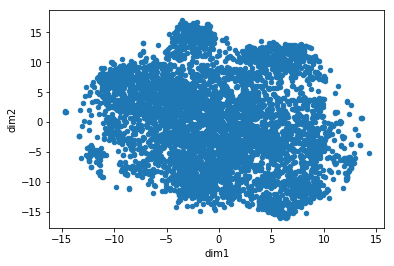

In [200]:
tsne = TSNE(n_jobs=8, perplexity=100)

# TSNE is taking too long for bigger dataset
reduced_X = theta_df_test.sample(n=5000)
tsne_data = tsne.fit_transform(reduced_X)
tsne_data = pd.DataFrame(tsne_data, columns=["dim1", "dim2"])
tsne_data.plot("dim1", "dim2", kind="scatter")

In [201]:
theta, _ = lda_model.inference(train)
theta /= theta.sum(axis=1)[:, None]
theta_df_train = pd.DataFrame(theta)

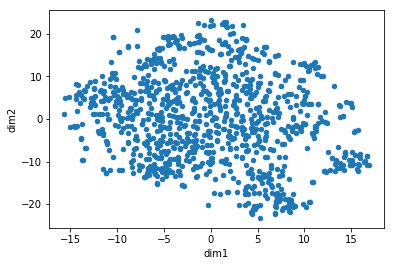

In [204]:
tsne = TSNE(n_jobs=8)

# TSNE is taking too long for bigger dataset
reduced_X = theta_df_train.sample(n=1000)
tsne_data = tsne.fit_transform(reduced_X)
tsne_data = pd.DataFrame(tsne_data, columns=["dim1", "dim2"])
tsne_data.plot("dim1", "dim2", kind="scatter")

In [207]:
# Build LDA model with the result from hyperparameter tuning
lda_model_2 = gensim.models.LdaMulticore(corpus=train,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.6,
                                            eta=0.05,
                                           per_word_topics=True)

In [9]:
from gensim.test.utils import datapath

In [15]:
m2 = gensim.models.LdaMulticore.load("./Metric/model_20")

In [17]:
m2.bound(test)

NameError: name 'test' is not defined

In [208]:
theta, _ = lda_model_2.inference(train)
theta /= theta.sum(axis=1)[:, None]
theta_df = pd.DataFrame(theta)

In [264]:
theta_df["labels"] = list(complete_df.iloc[test_index]['tag_0'])

In [265]:
theta_df["labels"].unique()

array(['Grocery & Gourmet Food', 'Health & Personal Care', 'Pet Supplies',
       'Home & Kitchen', 'Patio, Lawn & Garden', '', 'Baby', 'Beauty',
       'All Beauty', 'Sports & Outdoors', 'Industrial & Scientific',
       'Kitchen & Dining', 'Baby Products', 'Toys & Games',
       'Arts, Crafts & Sewing', 'Office & School Supplies', 'Movies & TV',
       'Wine', 'Tools & Home Improvement', 'Musical Instruments',
       'Automotive', 'Clothing, Shoes & Jewelry',
       'Collectibles & Fine Art', 'CDs & Vinyl'], dtype=object)

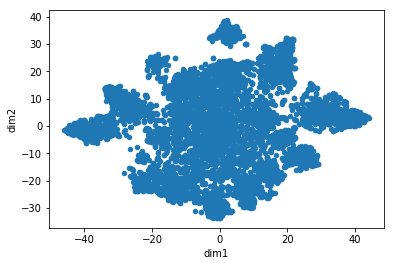

In [272]:
tsne = TSNE(n_jobs=8)

# Clean and sample the data from each categories
theta_df_clean = theta_df[ theta_df['labels'] != "" ]
theta_df_grouped = theta_df_clean.groupby(['labels'])
theta_df_grouped = theta_df_grouped.apply(lambda x: x.sample(frac=0.3))
# TSNE is taking too long for bigger dataset
reduced_X = theta_df_grouped.sample(n=6000)


tsne_data = tsne.fit_transform(reduced_X.ix[:, :30])
tsne_data = pd.DataFrame(tsne_data, columns=["dim1", "dim2"])
tsne_data.plot("dim1", "dim2", kind="scatter")

In [274]:
tsne_data['label'] = list(reduced_X["labels"])

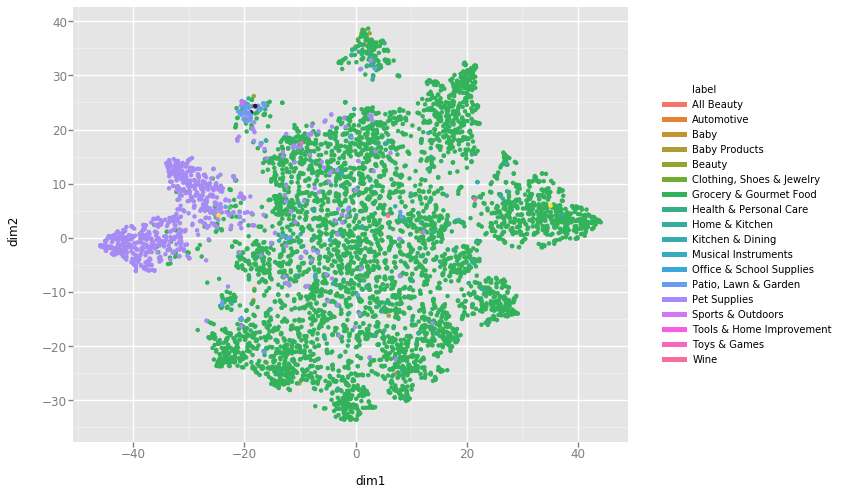

<ggplot: (-9223363308479336199)>

In [275]:
from ggplot import *
ggplot(tsne_data, aes(x='dim1', y='dim2', color='label')) +\
    geom_point()